# Figure 6-- analysis of genes in shared responses 
Last update: Dec 2021 <br>
Notes: Gene set enrichment in shared responses using only those genes with coordination. 

In [912]:
library(pathfindR)
library(dplyr)
library(stringr)
library(ggplot2)
library(pheatmap)
library(viridis)


In [913]:
res_output = '/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/'

In [929]:
dataPath = '/mnt/ibm_lg/covid_tissue_atlas/results/DGE/'
fileName = 'shared_DE_signatures_filter_Feb22.csv'

shared_df <- read.csv(paste0(dataPath, fileName))

head(shared_df)

gene       pval         log2fc    cell_type  tissue method covariate
1 ABL1       2.320011e-02 -1.370487 macrophage liver  MAST   ngenes   
2 AC009093.2 2.417820e-08 -3.535194 macrophage liver  MAST   ngenes   
3 AC009690.1 4.443810e-04 -1.507787 macrophage liver  MAST   ngenes   
4 ACSL1      1.242819e-60  9.878751 macrophage liver  MAST   ngenes   
5 ACSL3      3.666453e-11  2.867633 macrophage liver  MAST   ngenes   
6 ACTB       3.272325e-14  2.895327 macrophage liver  MAST   ngenes   
  cell_class cell_ontology_class full_cell_type    
1 macrophage Kupffer cell        liver : macrophage
2 macrophage Kupffer cell        liver : macrophage
3 macrophage Kupffer cell        liver : macrophage
4 macrophage Kupffer cell        liver : macrophage
5 macrophage Kupffer cell        liver : macrophage
6 macrophage Kupffer cell        liver : macrophage

In [915]:
master_df <- shared_df %>% dplyr::filter(cell_class %in% c('macrophage','endothelial'))

Filter only intersting cell types

In [916]:
master_df %>% group_by(tissue, cell_class) %>% count() 

tissue   cell_class  n   
1 heart    endothelial  773
2 heart    macrophage   227
3 kidney   endothelial  539
4 liver    endothelial  981
5 liver    macrophage   227
6 lung     endothelial 1059
7 lung     macrophage   227
8 prostate endothelial  787

## Vizualisation of shared response 

In [917]:
FIG_DIR = paste('/mnt/ibm_lg/covid_tissue_atlas/figures/figure5/',sep="")


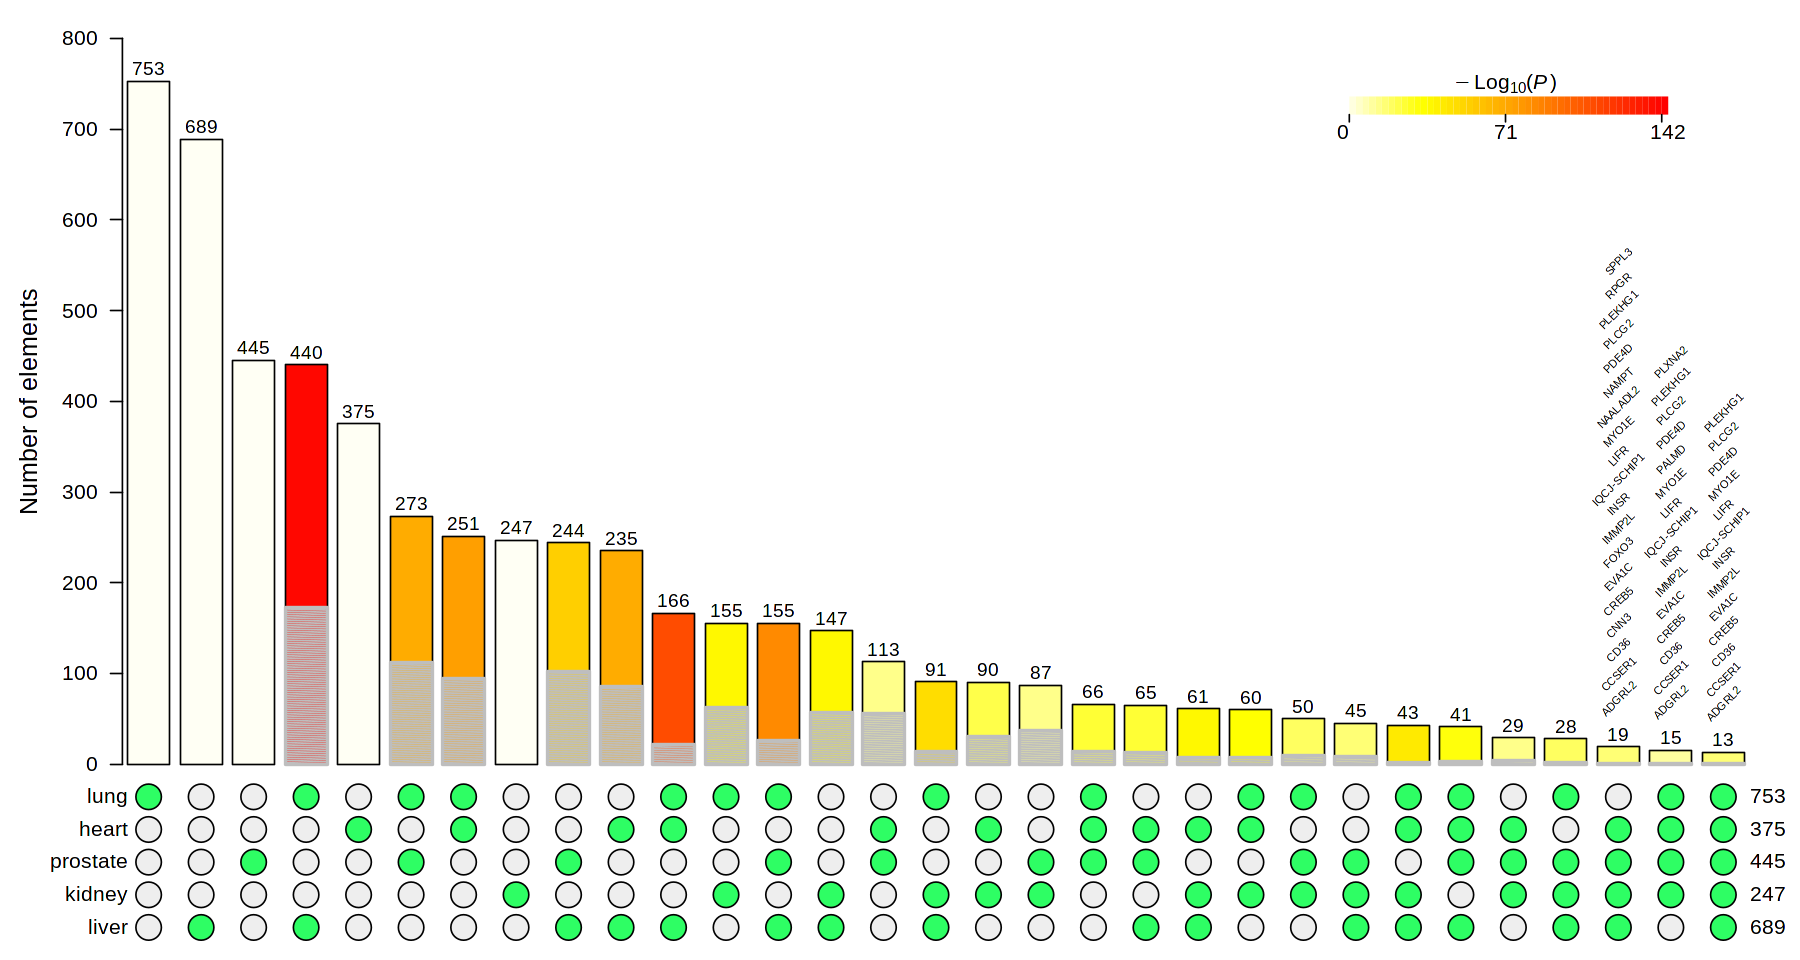

In [991]:
library(SuperExactTest)
which_class = 'endothelial'
class_df <- master_df %>% dplyr::filter(cell_class ==which_class, abs(log2fc) >1, pval<1e-3)
x <- list() 

tissues <- class_df$tissue %>% unique
n_genes <- class_df$gene %>% unique %>% length

for(t in tissues){
    genes <- class_df %>% dplyr::filter(tissue == t) %>% pull(gene) %>% unique 
    x[[t]] <- genes
    
}

res=supertest(x, n=3000)

options(repr.plot.width=15, repr.plot.height=8)

#pdf(paste(FIG_DIR, 'EC_sharedBarplot.pdf',sep = ""), width = 8, height =5)

plot(res, Layout="landscape", sort.by="size", keep=FALSE, show.elements=TRUE, elements.cex=0.5,
	elements.list=subset(summary(res)$Table,Observed.Overlap <= 20),
	show.expected.overlap=TRUE,expected.overlap.style="hatchedBox",
	color.expected.overlap='gray')

#dev.off()

Macrophages

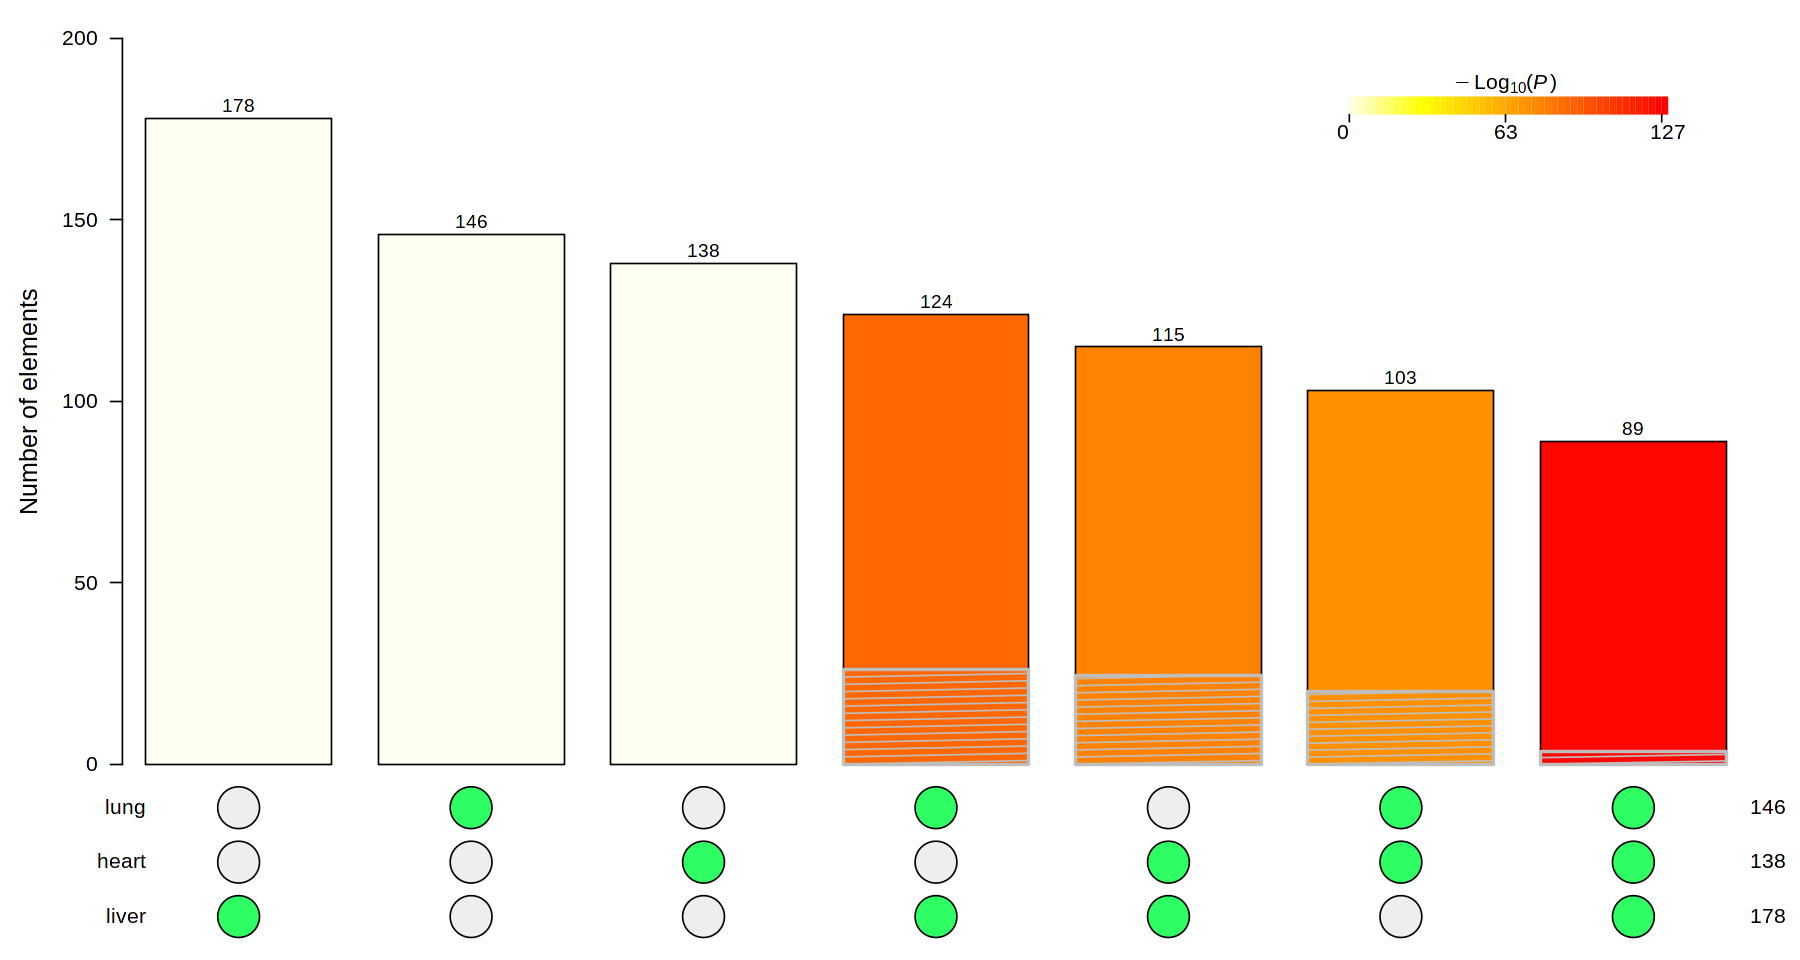

In [919]:
library(SuperExactTest)
which_class = 'macrophage'
class_df <- master_df %>% dplyr::filter(cell_class ==which_class, abs(log2fc) >1, pval<1e-3)
x <- list() 

tissues <- class_df$tissue %>% unique
n_genes <- class_df$gene %>% unique %>% length

for(t in tissues){
    genes <- class_df %>% dplyr::filter(tissue == t) %>% pull(gene) %>% unique 
    x[[t]] <- genes
    
}

res=supertest(x, n=1000)

options(repr.plot.width=15, repr.plot.height=8)

#pdf(paste(FIG_DIR, 'MA_sharedBarplot.pdf',sep = ""), width = 8, height =5)

plot(res, Layout="landscape", sort.by="size", keep=FALSE, show.elements=TRUE, elements.cex=1,
	elements.list=subset(summary(res)$Table,Observed.Overlap <= 20),
	show.expected.overlap=TRUE,expected.overlap.style="hatchedBox",
	color.expected.overlap='gray')

#dev.off()

For cell class and a set of (significantly coordinated) tissues, we take the coordinated genes (both up or both down) and perform gene set enrichment. We still calculate pathways on a per-tissue basiss

In [836]:
macrophage_overlap <- Reduce(intersect, x)

Top genes in the overlap for Macrophages

In [845]:
class_df %>% dplyr::filter(gene %in% macrophage_overlap) %>% group_by(gene) %>% 
    summarise(total_fc = sum(log2fc)) %>% arrange(desc(total_fc)) %>% head(20) 

gene     total_fc 
1  NAMPT    15.577606
2  FTL      15.040322
3  ACSL1    14.359314
4  B2M      14.152855
5  SIPA1L1  13.433608
6  ELL2     11.736869
7  SRGN     11.563845
8  RAB1A    11.483579
9  FTH1     11.476606
10 PLCG2    10.690940
11 SLC16A10 10.564476
12 HIF1A    10.413233
13 VMP1      9.913037
14 ACTB      8.848780
15 SLC2A3    8.775473
16 NUMB      8.483155
17 PSAP      8.411637
18 SAMSN1    8.349881
19 JUND      8.270782
20 KYNU      7.885500

## Run pathway anaysis on shared response

In [848]:
# For a given cell class, we analyze gene sets for each tissue. 
# We can then compare the results and find common pathways 

geneSetCellClass <- function(master_df, this_class = 'macrophage', tissue_set = c('liver','heart','lung') , 
                                direction = "up",
                                which_db= 'Reactome', 
                                mode = 'strict'){
    
    if(mode =='strict'){ #we require genes to be coordinated across all tissues -- default 
        path_input <- selectSharedGenes(master_df, this_class, direction)
        
    }else if(mode =='all_genes'){ #genes that show up in at least 2 tissues 
        path_input <- selectAllGenes(master_df, this_class, direction)
        
    }

    # Gene set enrichment for each tissue     
    i = 1
    out_list = list() 
    for(c in 1:length(tissue_set)){
            which_tissue = tissue_set[c]
            # main code for gnee set enrichment 
            tissue_input <- path_input %>% dplyr::filter(tissue ==which_tissue) %>% dplyr::select(gene,log2fc, pval)
            output_df <- run_pathfindR(tissue_input , 
                                       output_dir = paste0(res_output, which_tissue,'/', this_class,'/'),
                                       gene_sets = which_db, #database
                                       min_gset_size = 5,  #at leats genes
                                       max_gset_size = 300,  #at most genes, 
                                       adj_method = "fdr",  #pval adj method
                                       visualize_enriched_terms = FALSE, 
                                       enrichment_threshold = 0.01)
        
            
            # check that data.frame is not empty
            if(length(output_df)>0){
                # add cell type as unique ID 
                output_df$tissue = tissue_set[c]
                out_list[[i]]  = output_df          
                print(paste('Done cell type ', tissue_set[c], '... ', this_class))
                i = i+1
            }else{
                print(paste("Not pathways found ", tissue_set[c]))
            }
    
    }
    do.call(rbind, out_list) -> tissue_pathways

    # Write to disk
    write.table( tissue_pathways, 
                file = paste0('/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/cell_classes/',this_class, '/','all_tissues_',which_db,'_',direction,'.tsv'  ), 
               sep = '\t', quote =F)
    save(tissue_pathways, file = paste0('/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/cell_classes/',this_class, '/','all_tissues_',which_db,'_',direction,'.rda'))
        
        
}

# Alternative 
# include in gene set analysis only genes that show coordination across all three tissues 
# same fun as above with small difference <- test 

selectSharedGenes <- function(master_df  = data.frame(), this_class = "", direction = "up"){
    # select cell type and direction of change 
    if(direction =='up'){
        input_df <- master_df %>% dplyr::filter(cell_class ==this_class & log2fc > 0) 
    }else if(direction =='down'){
        input_df <- master_df %>% dplyr::filter(cell_class ==this_class & log2fc < 0) 
    }
        # select genes that appear in all tissues (strict coordination)
    input_df  %>% group_by(gene) %>% dplyr::count() %>% arrange(desc(n)) %>% 
        dplyr::filter(n==3) %>% pull(gene) -> gene_list 
    input_df <- input_df %>% dplyr::filter(gene %in% gene_list )
    # return data.frame only for the selected gene list 
    return(input_df)
}

selectAllGenes <- function(master_df = data.frame() , this_class = '', direction = "up"){
        if(direction=="up"){
        path_input <- master_df %>% dplyr::filter(tissue %in% tissue_set) %>% 
                dplyr::filter( log2fc >0) %>% filter(cell_class == this_class)
    }else if(direction =="down"){
        path_input <- master_df %>% dplyr::filter(tissue %in% tissue_set) %>% 
                dplyr::filter( log2fc <0) %>% filter(cell_class == this_class)
    }else if(direction =="both"){
        path_input <- master_df %>% dplyr::filter(tissue %in% tissue_set) %>% 
                filter(cell_class == this_class)
    }
    return(path_input)
}


Run analysis for each tissue within the cell class. We now that the shared response is significantly correlated between pairs of tissues. So here we just focus on geneset enrichment

Gene sets available in pathfindR are KEGG, Reactome, BioCarta, GO-Biological Process (GO-BP), GO-Cellular Component (GO-CC), GO-Molecular Function (GO-MF) and GO-All (GO-BP, GO-CC, and GO-MF combined).

In [849]:
# For a given class, run both up and down regulated pathways across a list of databases
runAll_databases <- function(master_df = data.frame() ,
                             this_class = 'macrophage',
                             db_list = c('Reactome','KEGG','BioCarta','GO-All') ,
                             tissue_list = c('liver','heart','lung')){
        for(this_db in db_list){
            geneSetCellClass(master_df, this_class,tissue_set = tissue_list ,
                             direction ='up', 
                             which_db=this_db)

            }

        for(this_db in db_list){
            geneSetCellClass(master_df, this_class,tissue_set = tissue_list ,
                             direction ='down', 
                             which_db=this_db)

            }
    }

`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(22)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 82

Number of genes in input after p-value filtering: 82

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13



Found interactions for all genes in the PIN

Final number of genes in input: 82

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file: results.Rmd



  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b1576b8c7.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b47a1a80.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b294125b.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b7cc4d5de.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b7c3496e0.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b63424e2a.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart

Found 112 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(22)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(18)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 82

Number of genes in input after p-value filtering: 82

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Found interactions for all genes in the PIN

Final number of genes in input: 82

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file: results.Rmd



  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b68afe394.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b23b84f2.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b1972c75e.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b6e1f907f.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b1a57a2e7.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b799c3f05.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart

Found 123 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(18)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(18)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 82

Number of genes in input after p-value filtering: 82

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Found interactions for all genes in the PIN

Final number of genes in input: 82

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file: results.Rmd



  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b7247fbf.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b6a1861c5.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b53bbd0e4.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b6486fbd9.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b7e499eaf.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b58dac385.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



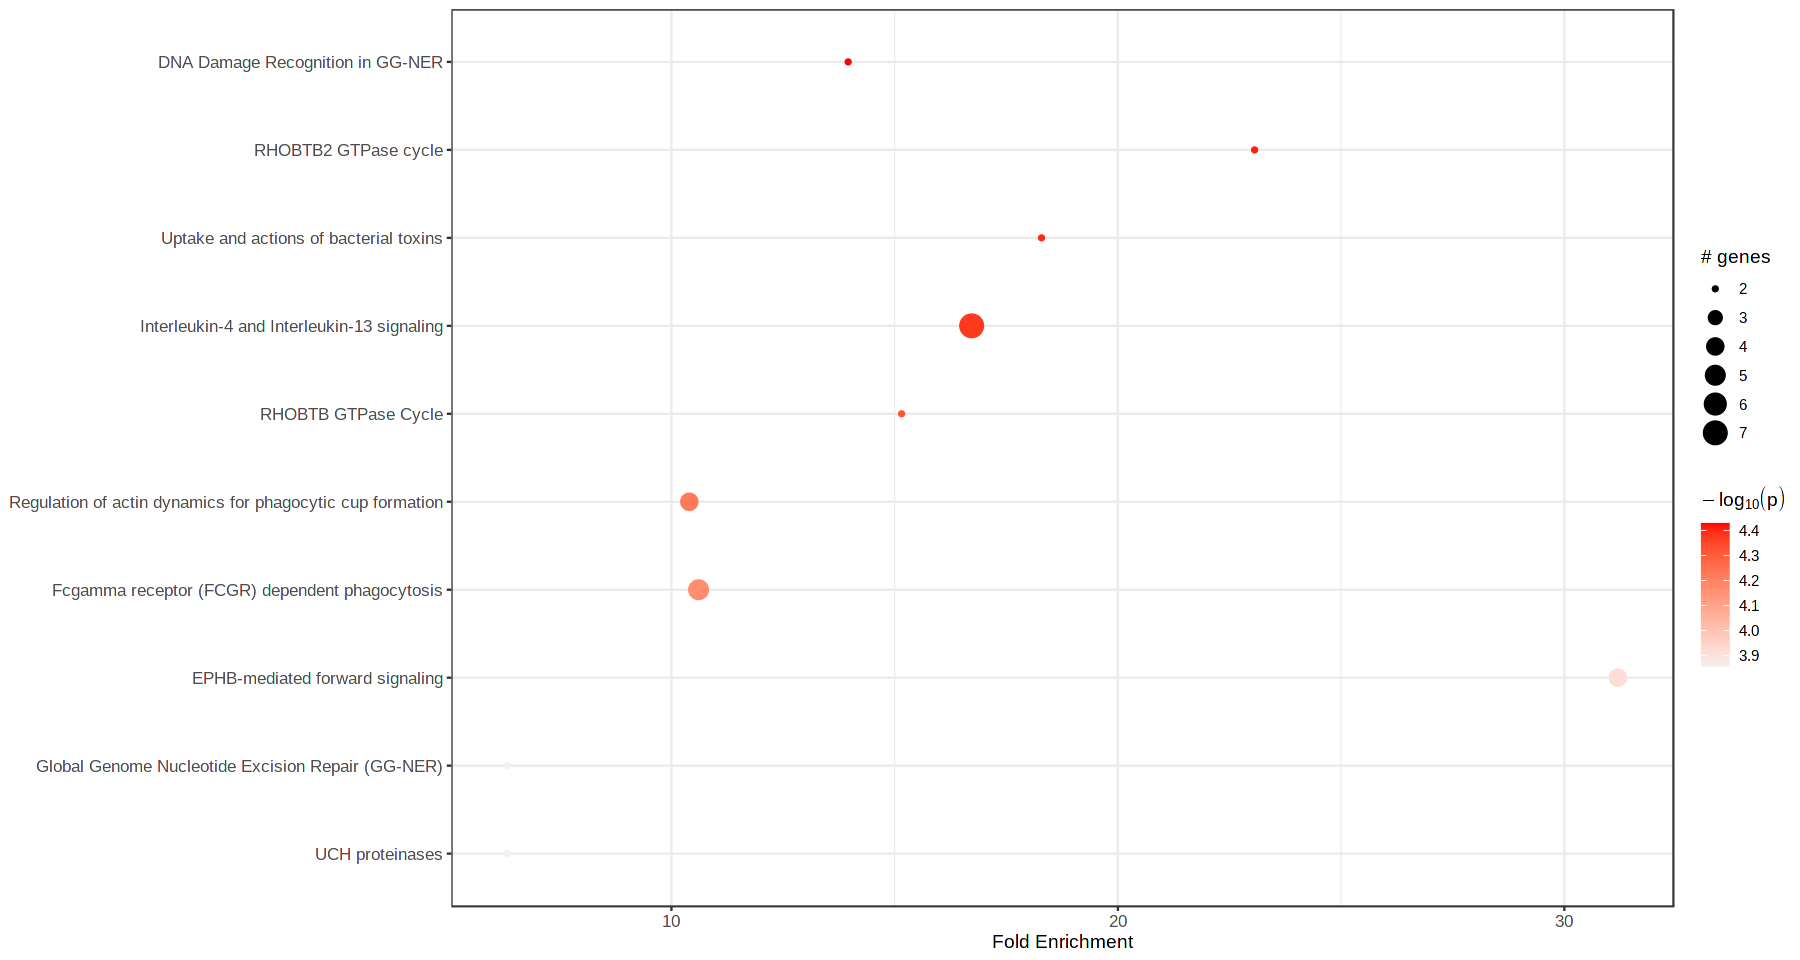

Found 97 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(18)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(23)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 82

Number of genes in input after p-value filtering: 82

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Found interactions for all genes in the PIN

Final number of genes in input: 82

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file: results.Rmd



  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b3d7c1ac9.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b5457ea96.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b6c7d1dd2.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b3864adbb.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b431ece83.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b1a1b7dd4.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



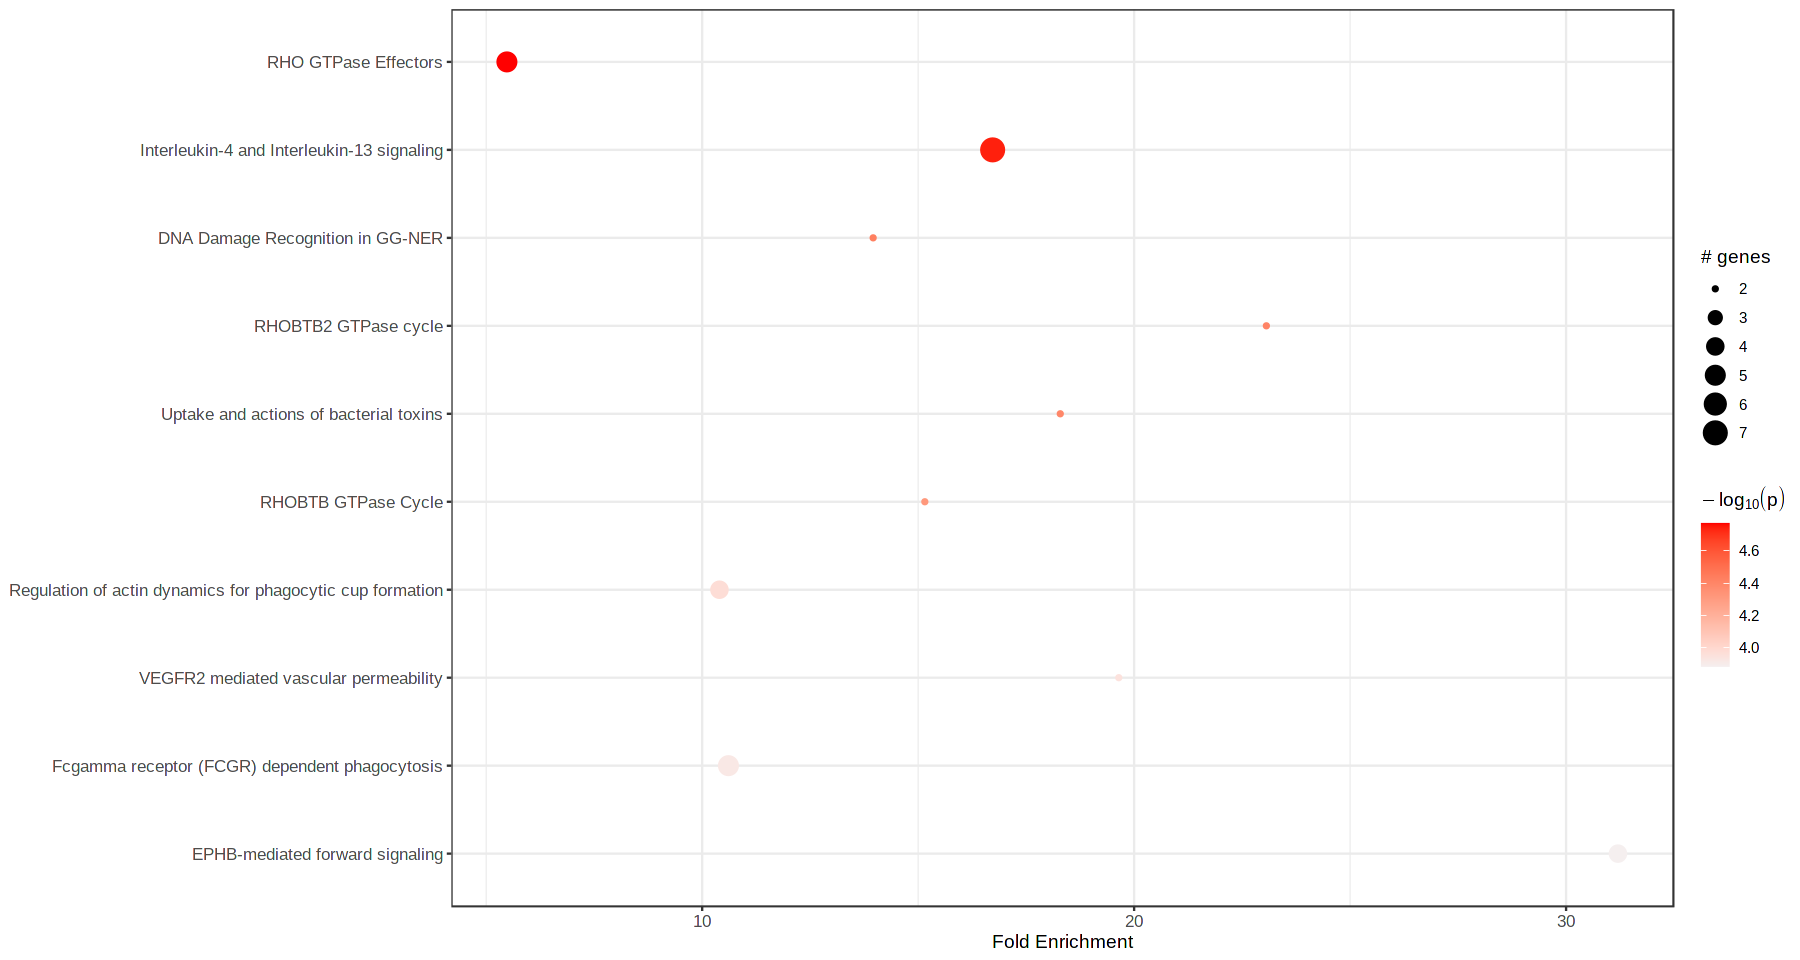

Found 115 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(23)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(19)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 82

Number of genes in input after p-value filtering: 82

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Found interactions for all genes in the PIN

Final number of genes in input: 82

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file: results.Rmd



  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b94e7628.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b78071d23.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b6859d5b1.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b7a13710c.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b4efc7c0a.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b46894809.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



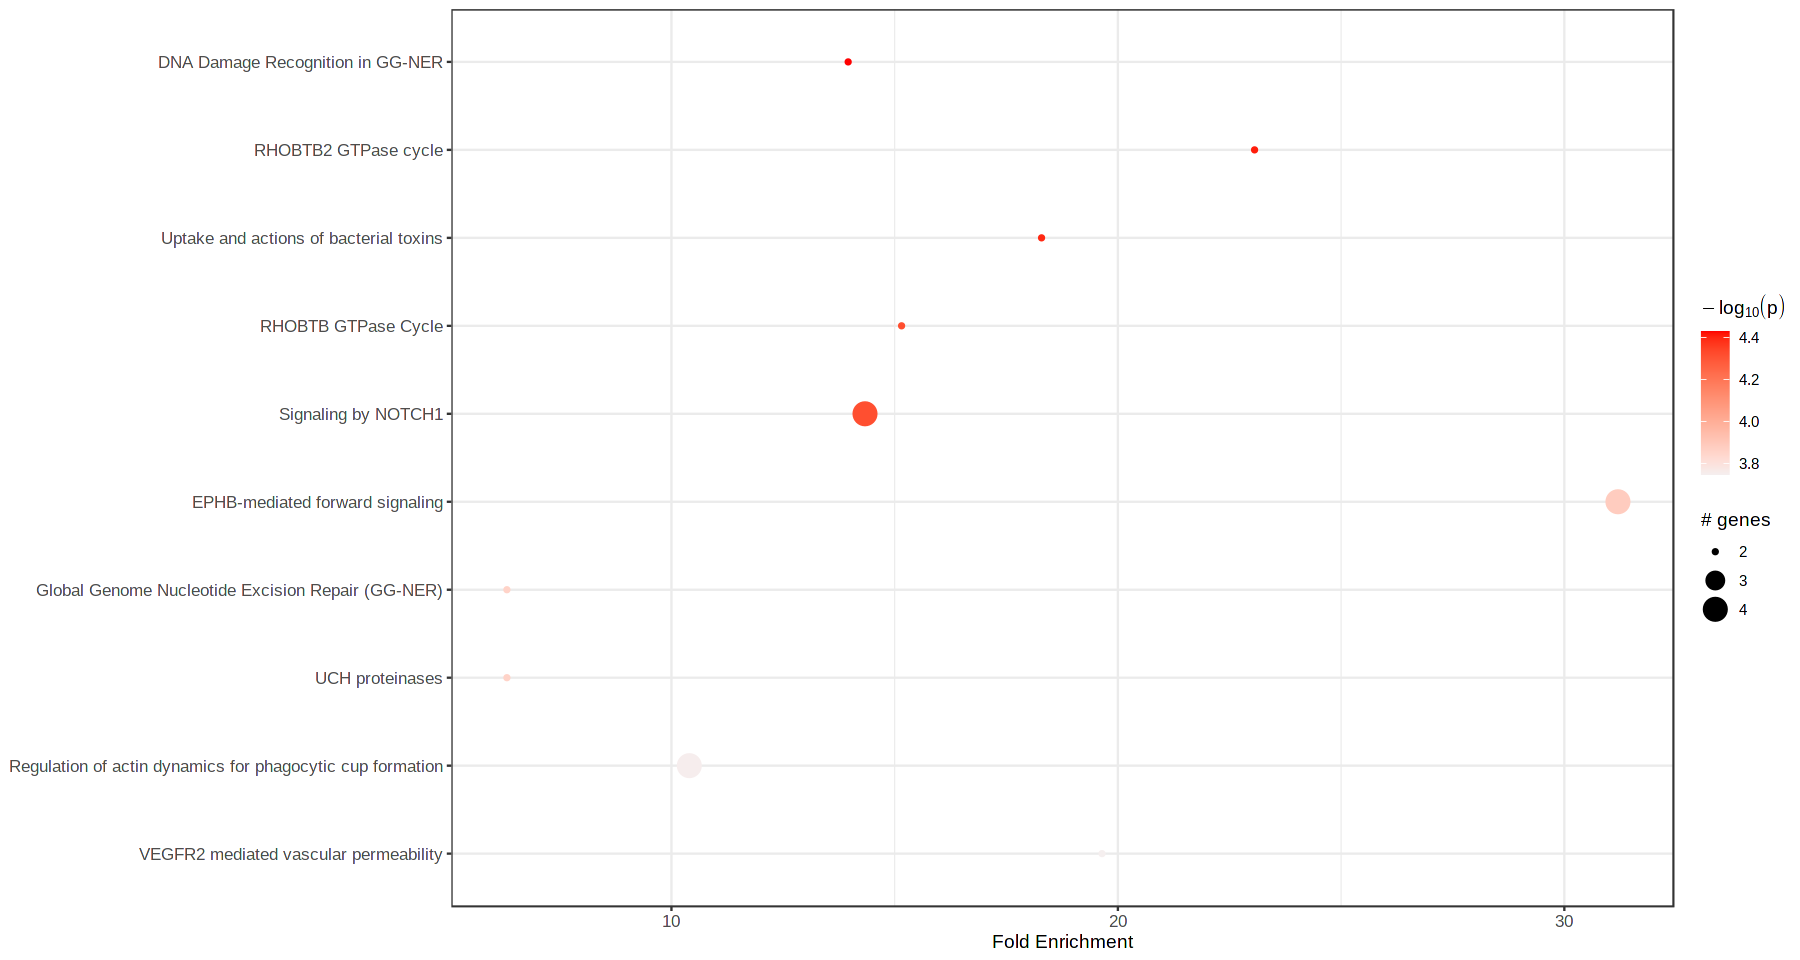

Found 114 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(19)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(19)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 82

Number of genes in input after p-value filtering: 82

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Found interactions for all genes in the PIN

Final number of genes in input: 82

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file: results.Rmd



  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b47bfd7d1.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b4c038be0.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b62f6514a.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b1210fe3c.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b2cf79e68.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b1c639043.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



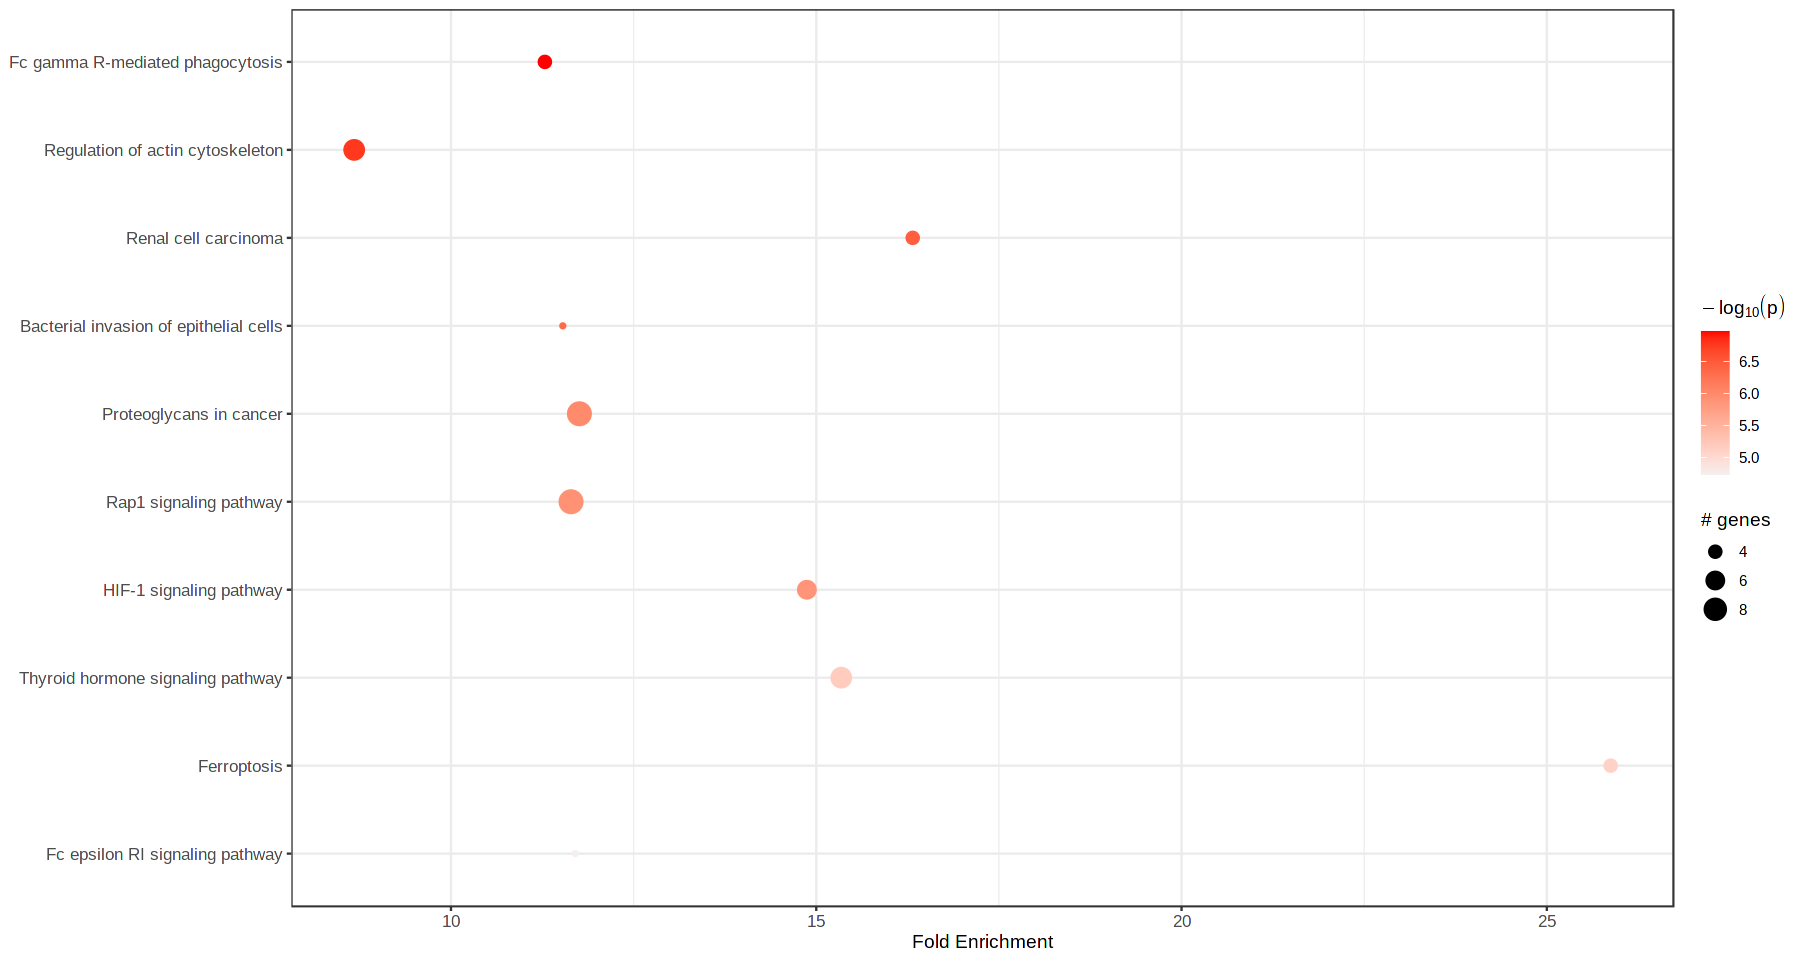

Found 118 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(19)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(24)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 82

Number of genes in input after p-value filtering: 82

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Found interactions for all genes in the PIN

Final number of genes in input: 82

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file: results.Rmd



  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b7bcf355f.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b6163e13e.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b16baa2e3.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b3eeabff3.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b5275842a.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165beb43ed9.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



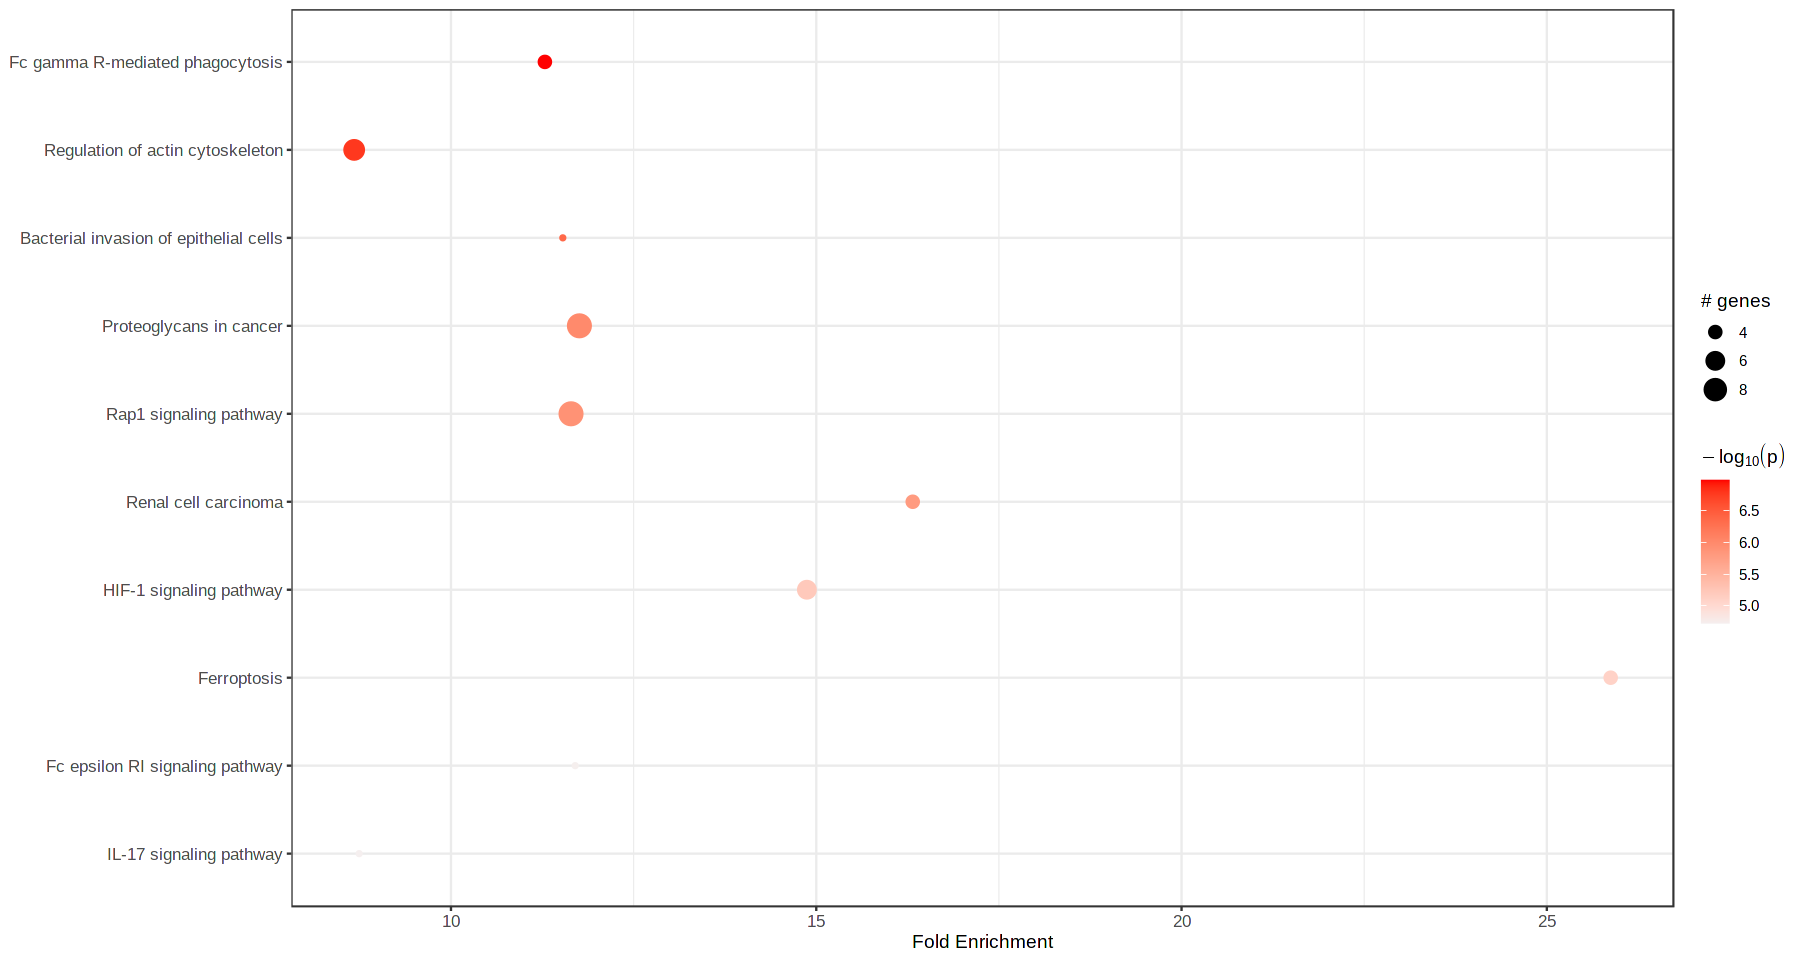

Found 68 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(24)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(20)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 82

Number of genes in input after p-value filtering: 82

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Found interactions for all genes in the PIN

Final number of genes in input: 82

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file: results.Rmd



  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b2bc2f769.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b5edc189b.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b293bba8a.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b29aede53.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b622043a5.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b597cb47a.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



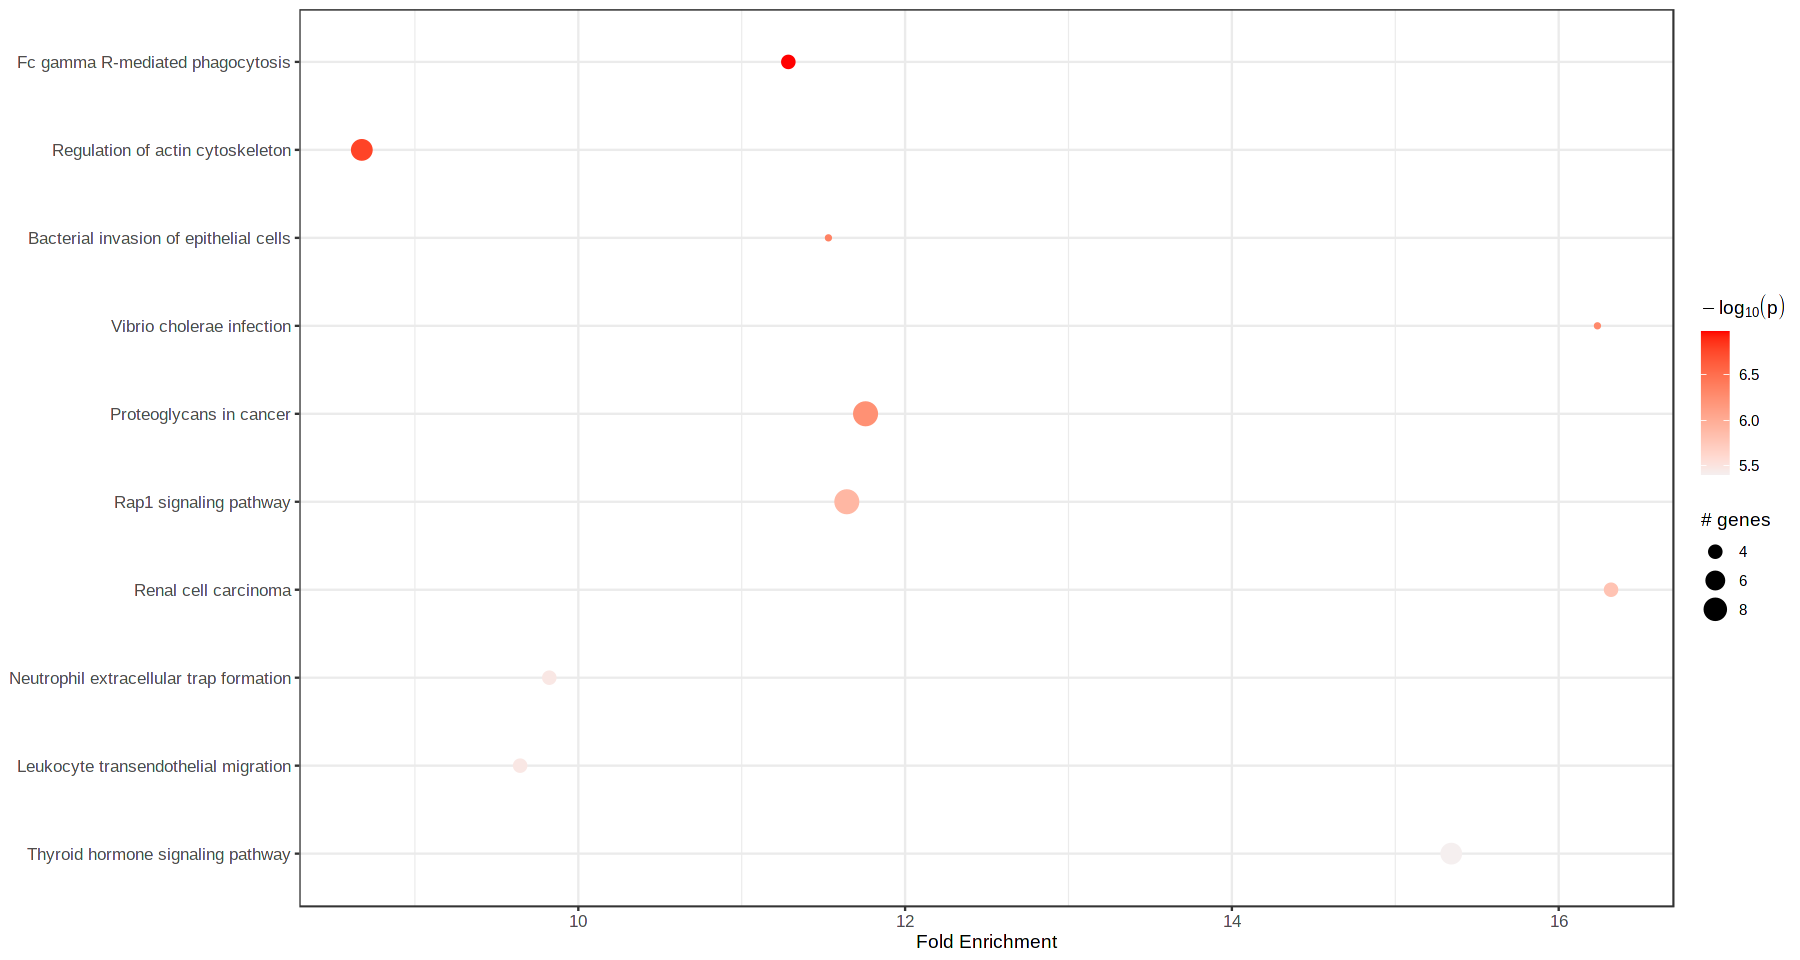

Found 68 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(20)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(20)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 82

Number of genes in input after p-value filtering: 82

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Found interactions for all genes in the PIN

Final number of genes in input: 82

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file: results.Rmd



  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b734eb5ed.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b18021bc.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b5e188fdf.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b39659230.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b22124f78.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b297dbd01.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



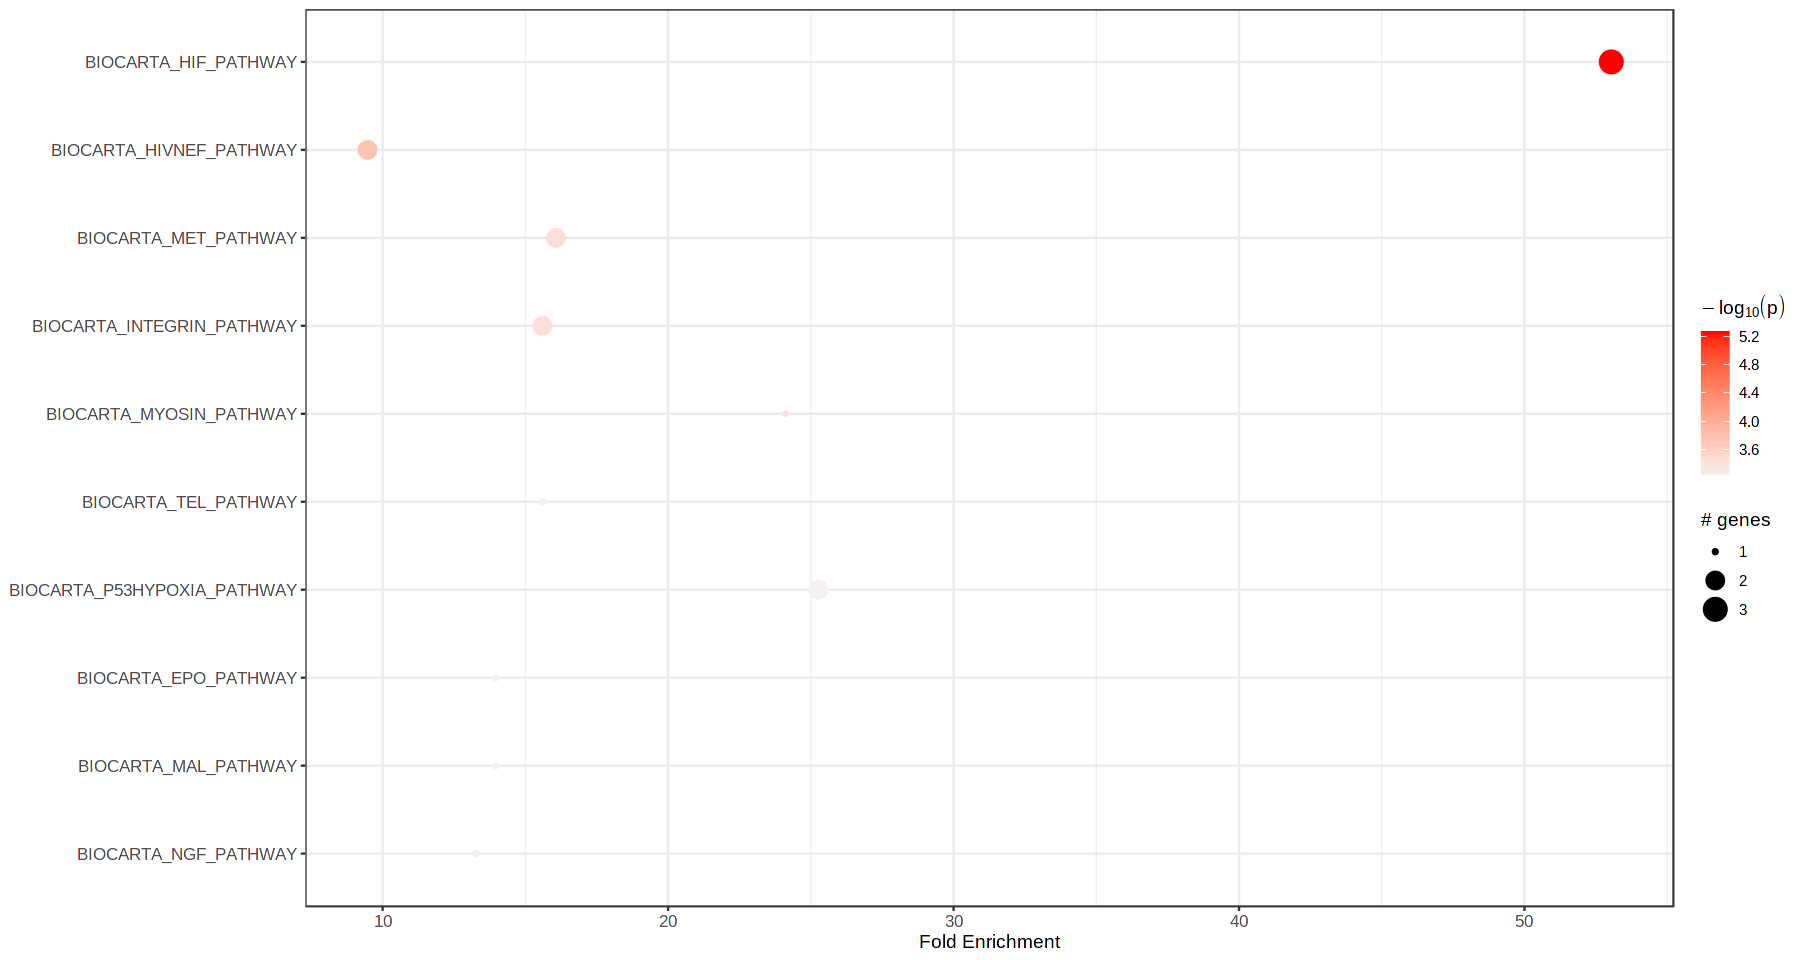

Found 68 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(20)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(25)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 82

Number of genes in input after p-value filtering: 82

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Found interactions for all genes in the PIN

Final number of genes in input: 82

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file: results.Rmd



  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b34a8ab51.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b345b6ec0.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b74214879.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b17e9dacc.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b503b4da8.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b6db6133b.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



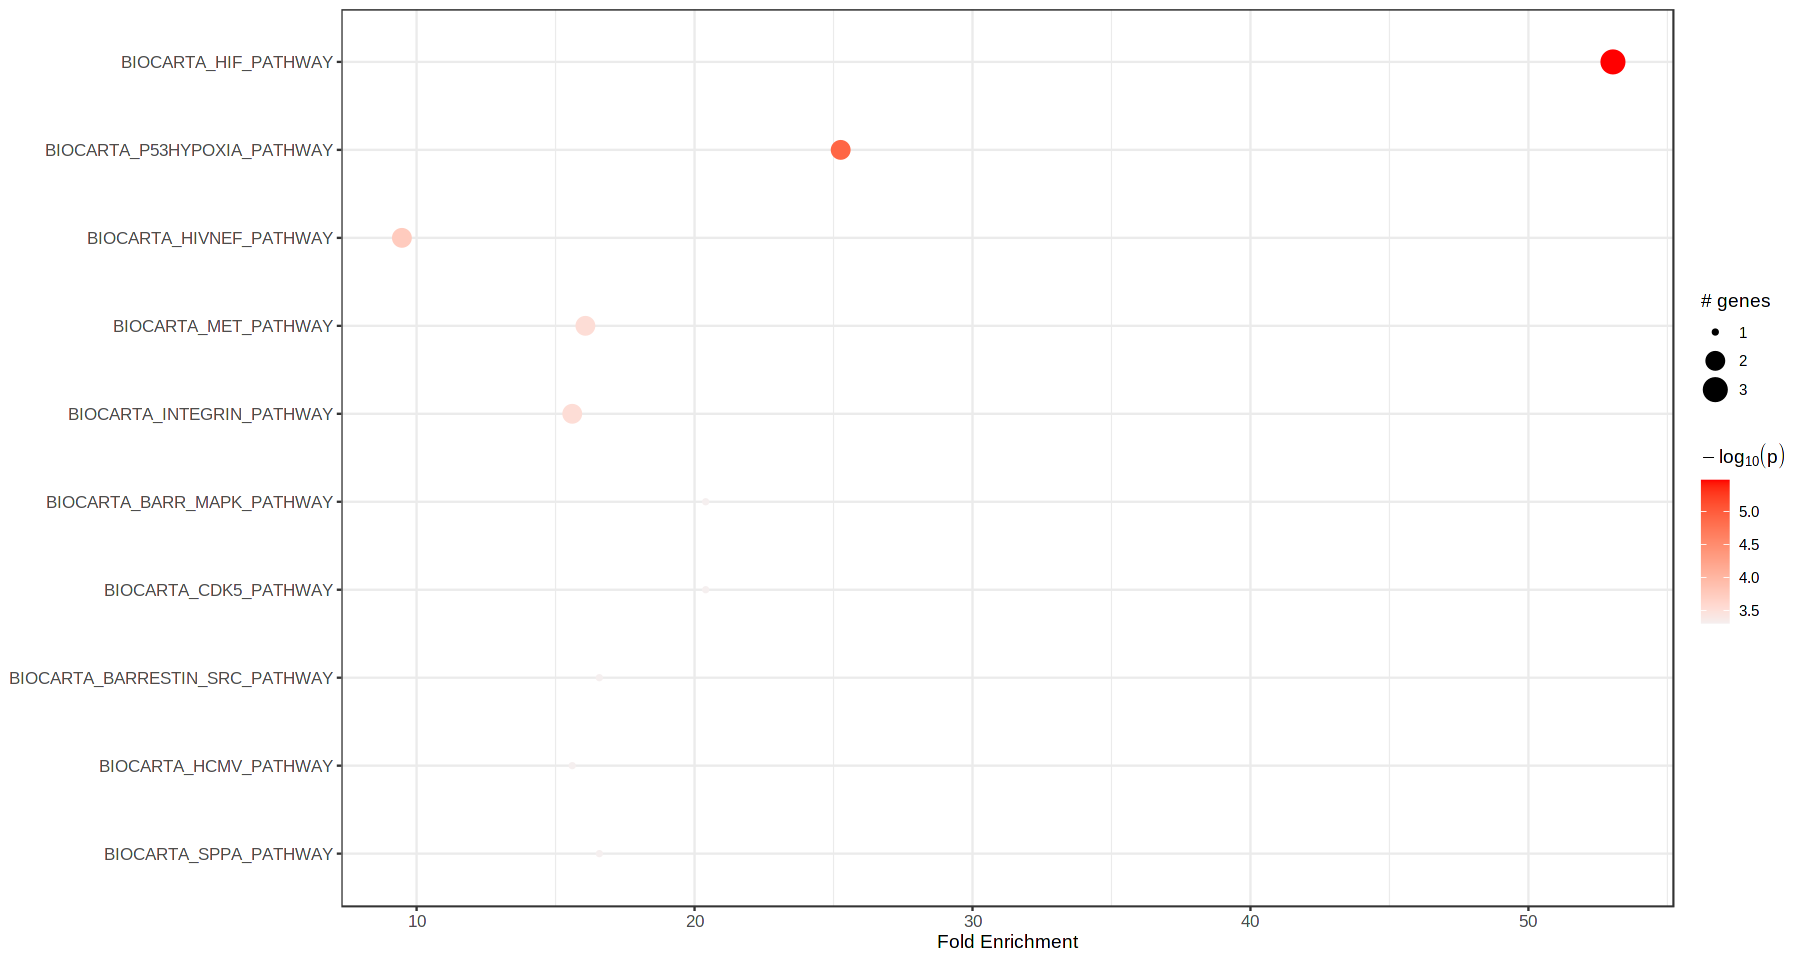

Found 63 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(25)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(21)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 82

Number of genes in input after p-value filtering: 82

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Found interactions for all genes in the PIN

Final number of genes in input: 82

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file: results.Rmd



  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b57fa081d.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b79417f47.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165bcca234e.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b5f3f5dee.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b2460e191.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b17b17387.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



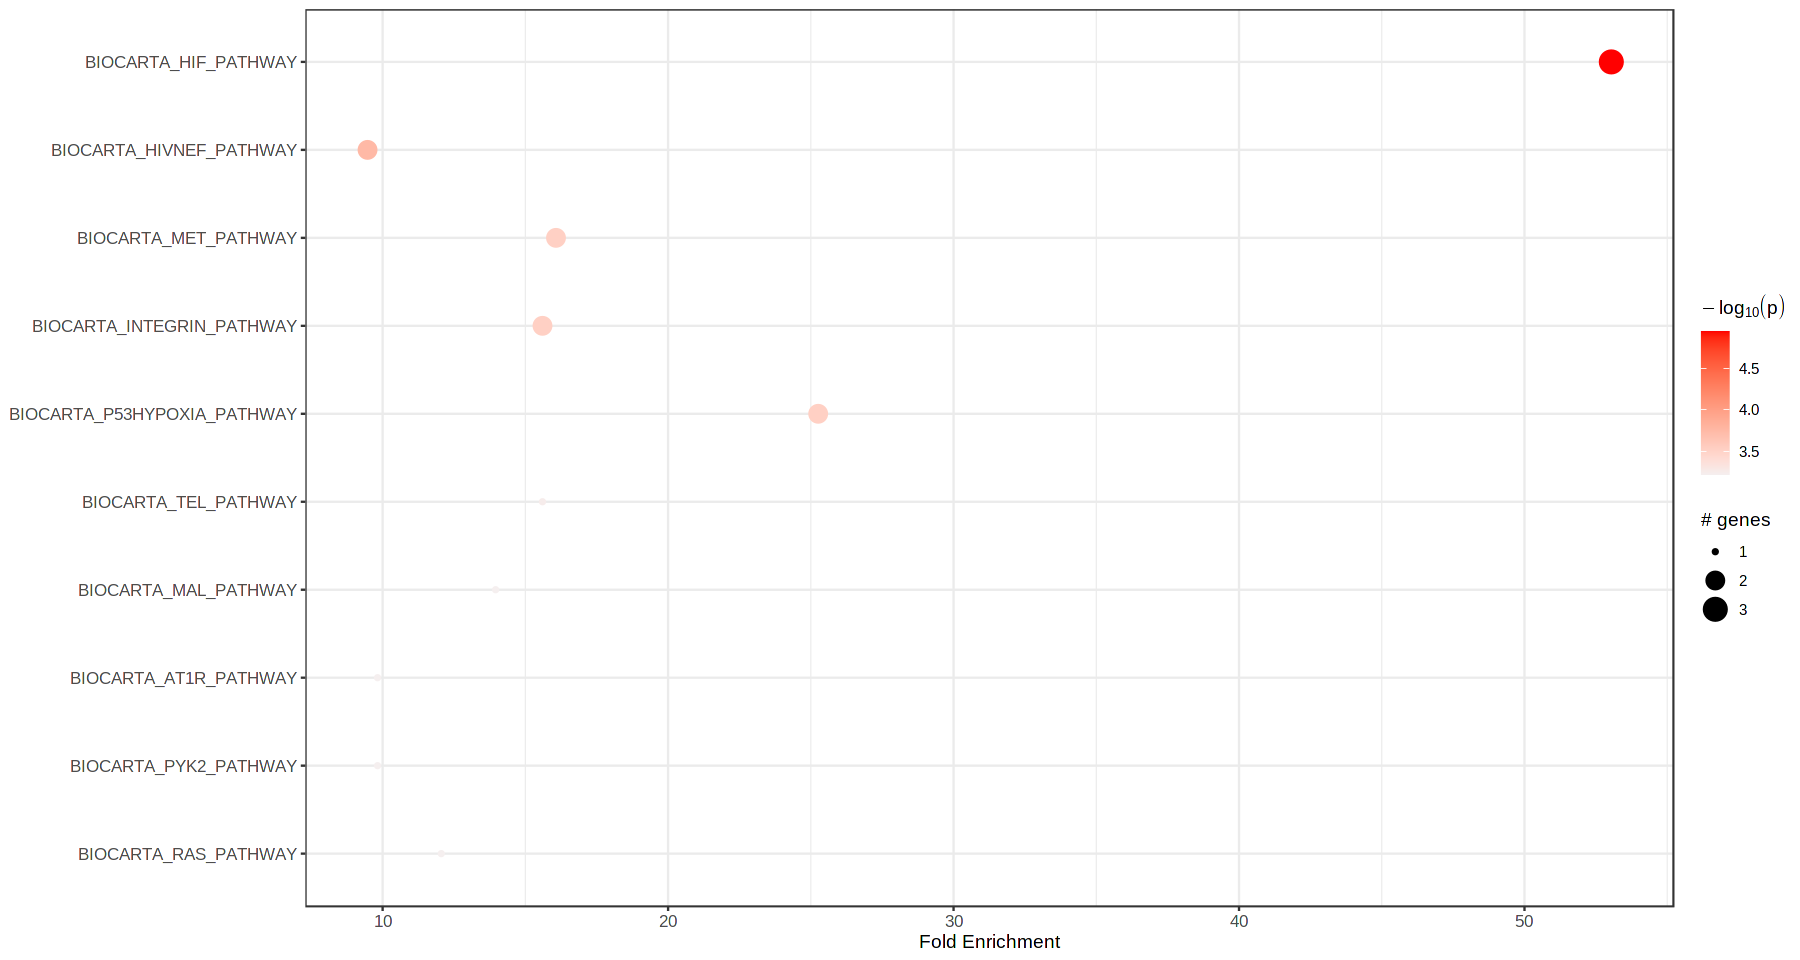

Found 63 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(21)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(21)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 82

Number of genes in input after p-value filtering: 82

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Found interactions for all genes in the PIN

Final number of genes in input: 82

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file: results.Rmd



  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b25c94b63.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165bdef2f72.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b5d029fda.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b2c33b45a.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b5cfa061a.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b399762b7.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



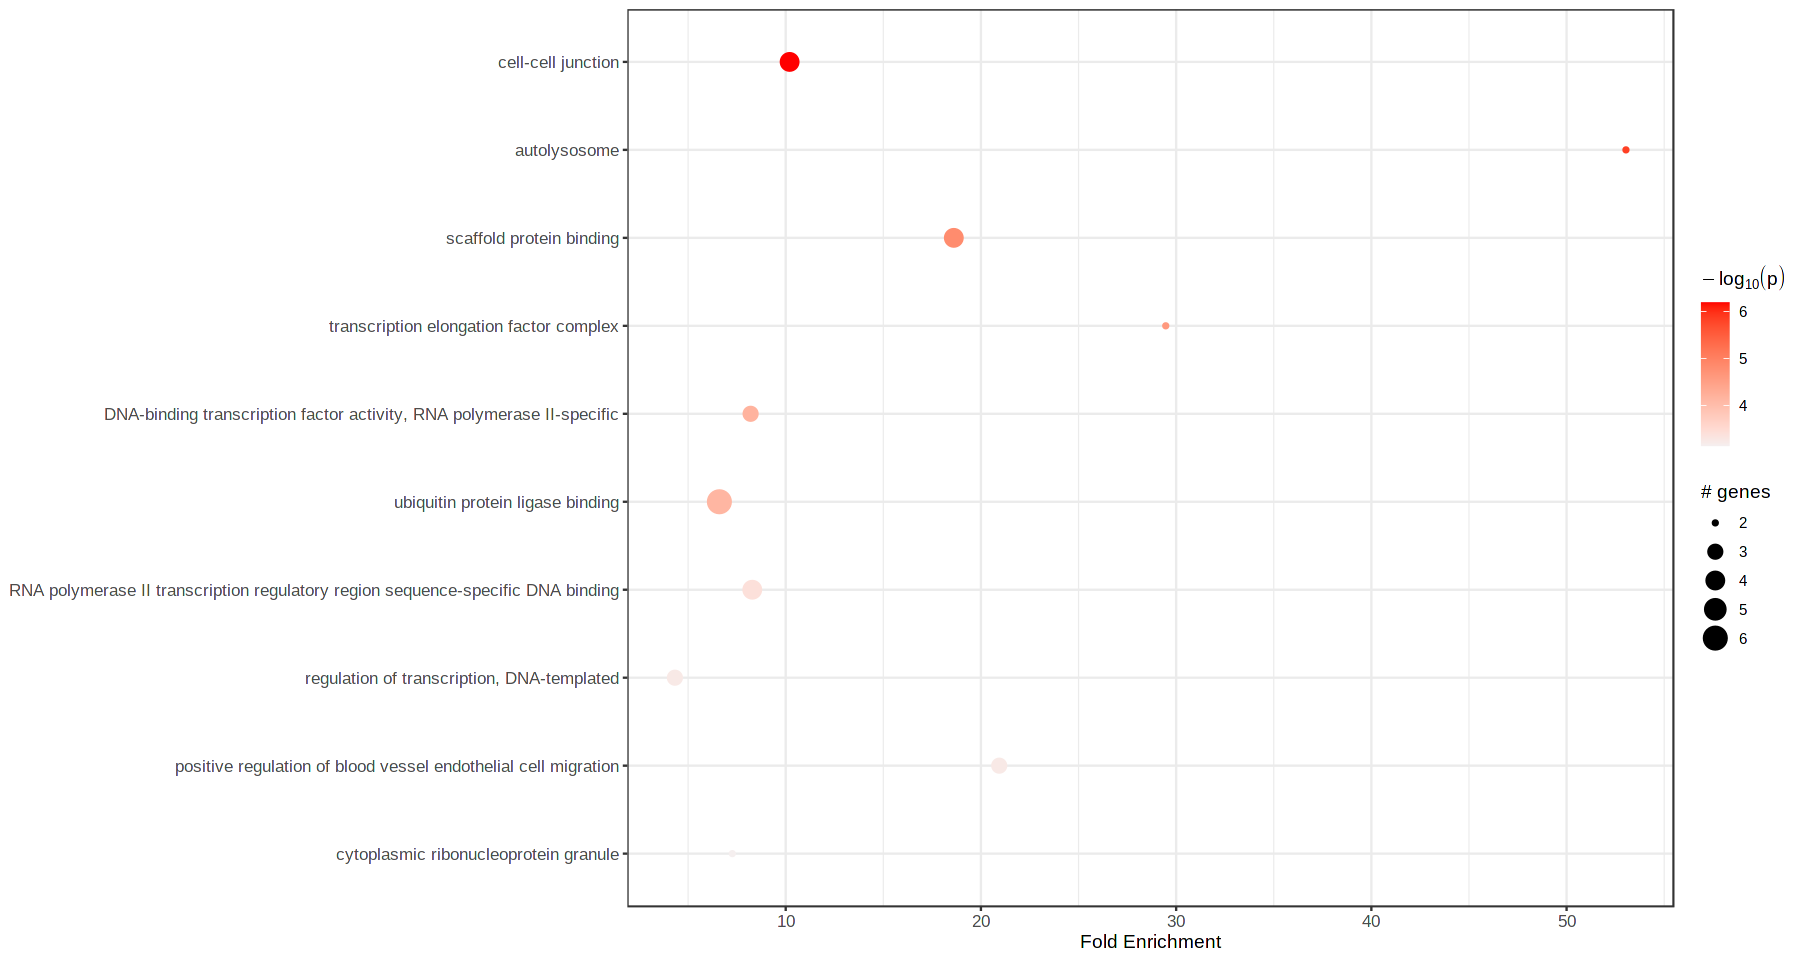

Found 60 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(21)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(26)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 47

Number of genes in input after p-value filtering: 47

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 4 (8.51%) genes in the PIN

Final number of genes in input: 43

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing fil

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b2f3df3c.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b1a296c4a.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b5b4ed81f.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b1843f4a.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b4577315f.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b9dec522.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



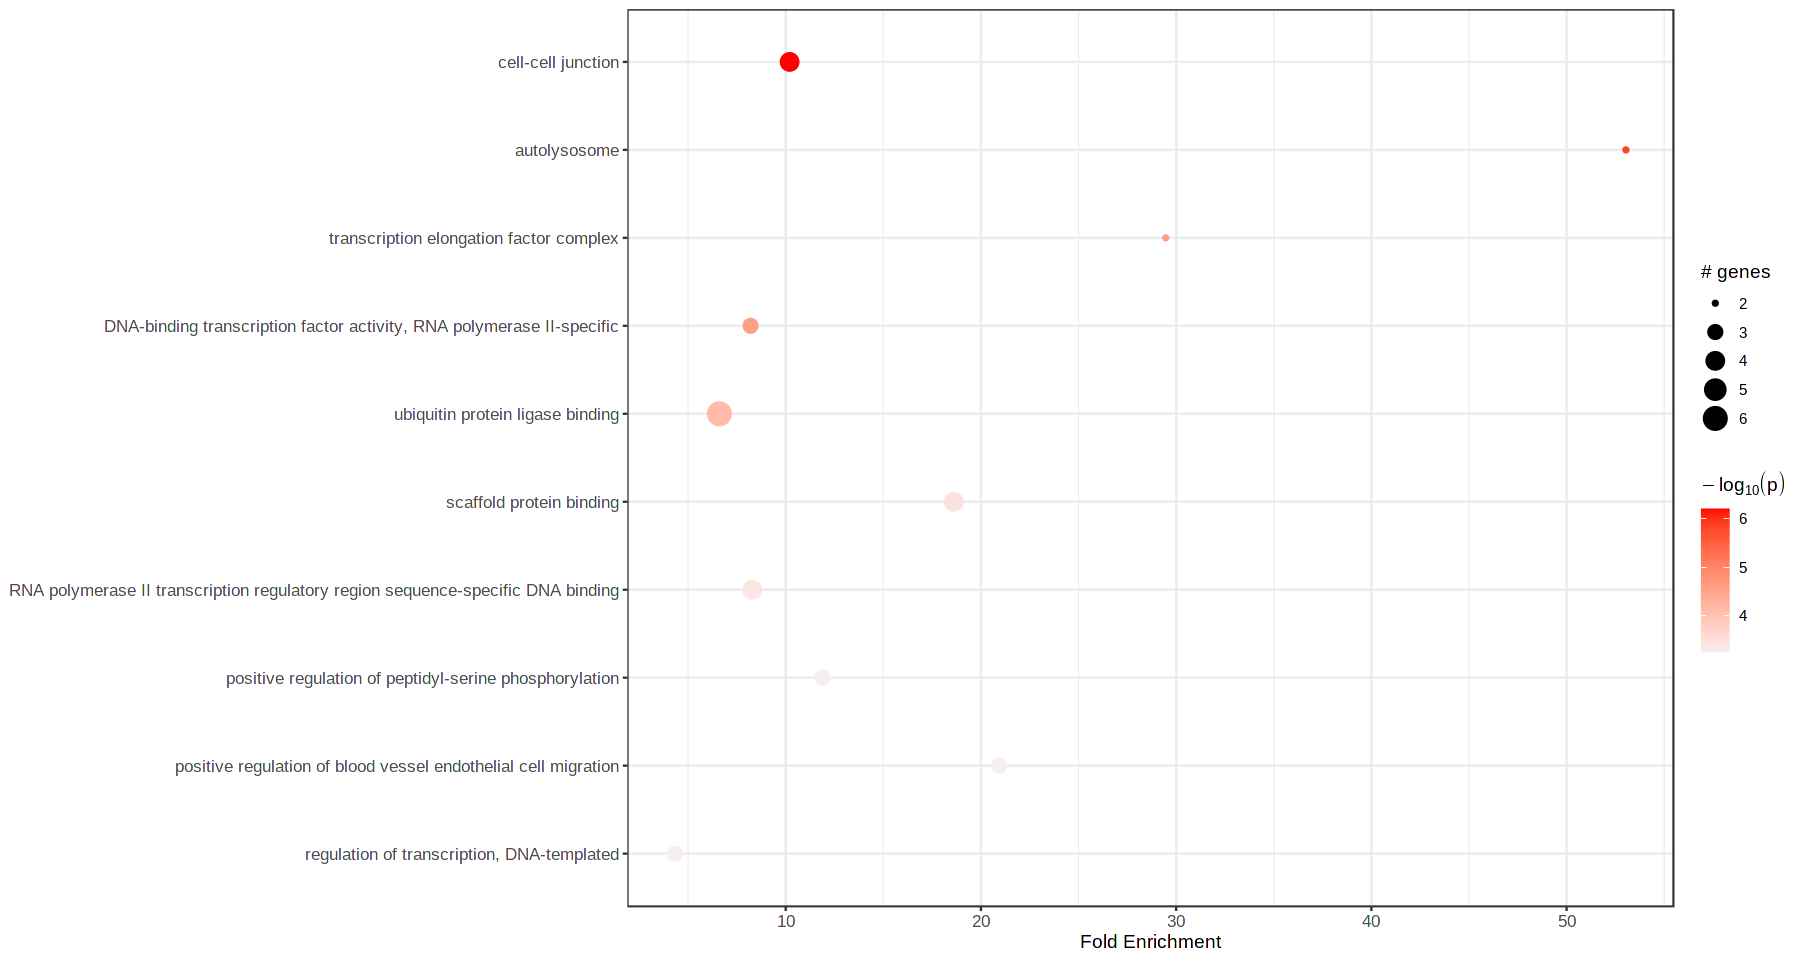

Found 23 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(26)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(22)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 47

Number of genes in input after p-value filtering: 47

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 4 (8.51%) genes in the PIN

Final number of genes in input: 43

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing fil

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b19414f98.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b47d0ffc3.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b38177ad2.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b6b31658f.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b8e0bf1c.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b50495877.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



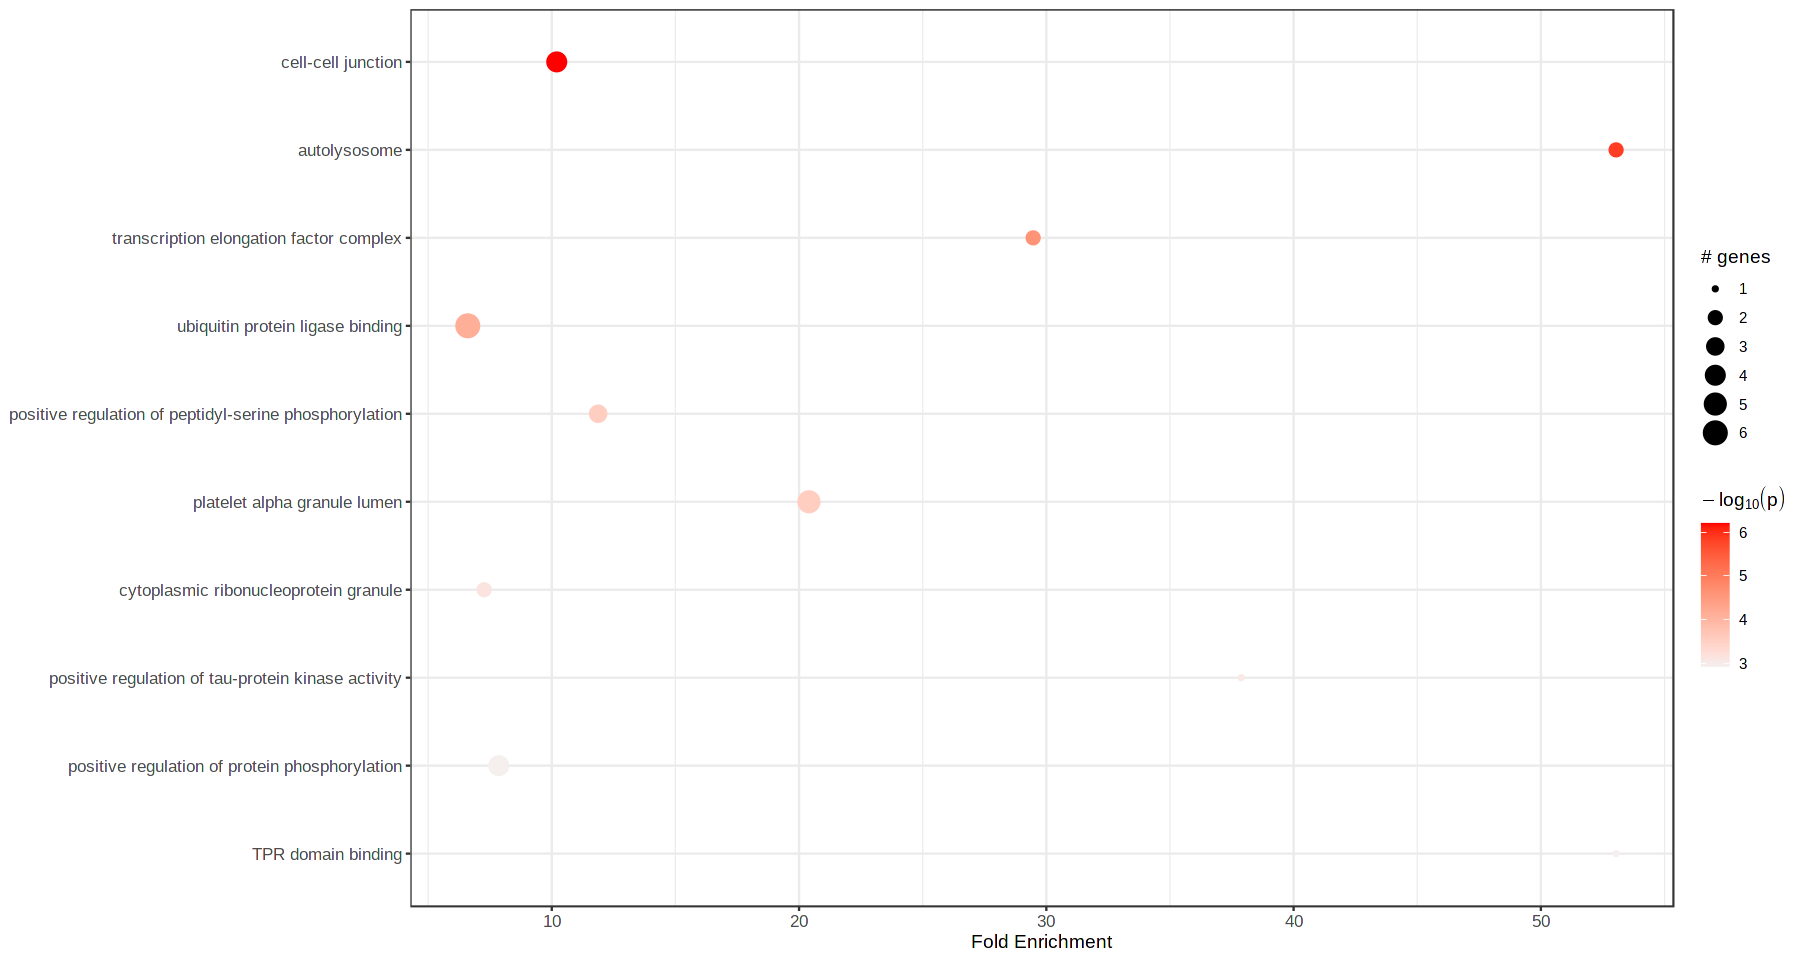

Found 22 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(22)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(22)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 47

Number of genes in input after p-value filtering: 47

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 4 (8.51%) genes in the PIN

Final number of genes in input: 43

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file:

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b6360f573.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b5f6b1db4.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b37e5541c.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b552a4369.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b3f9d6406.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b62b4712a.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



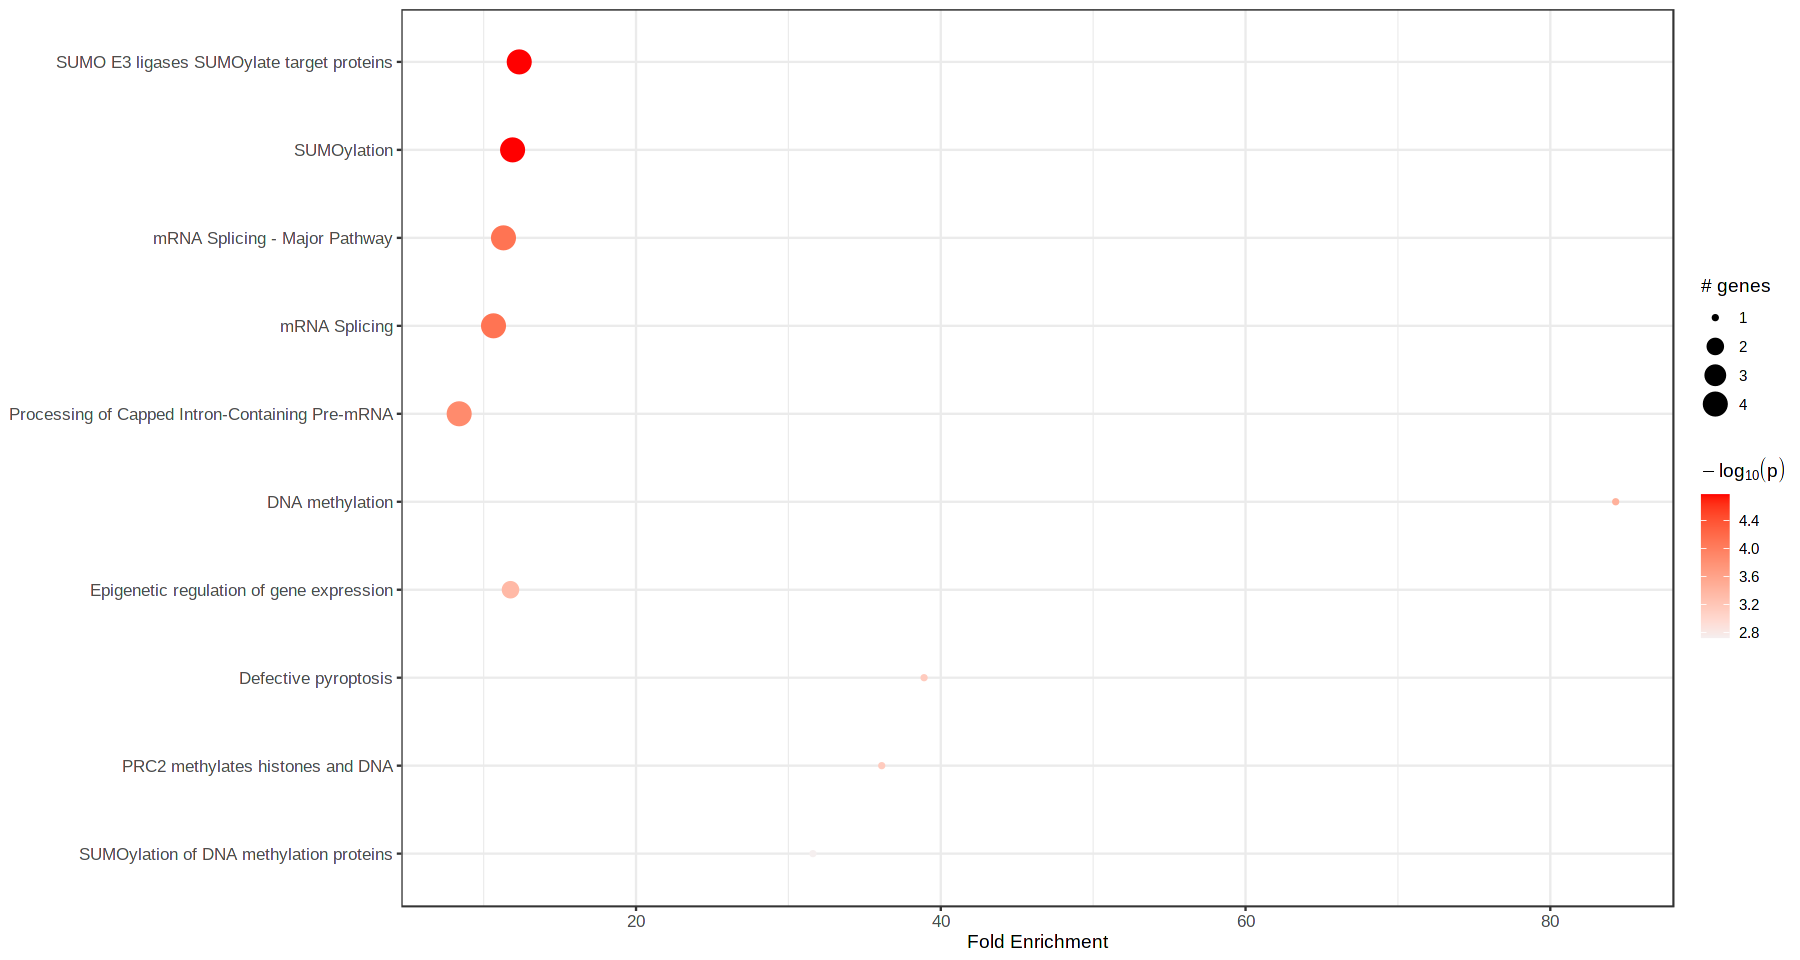

Found 19 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(22)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(27)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 47

Number of genes in input after p-value filtering: 47

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 4 (8.51%) genes in the PIN

Final number of genes in input: 43

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing fil

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b2ef042a2.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b6f8cb3d0.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b9d23e21.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b10bbaa78.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b39add3f5.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b18552adc.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



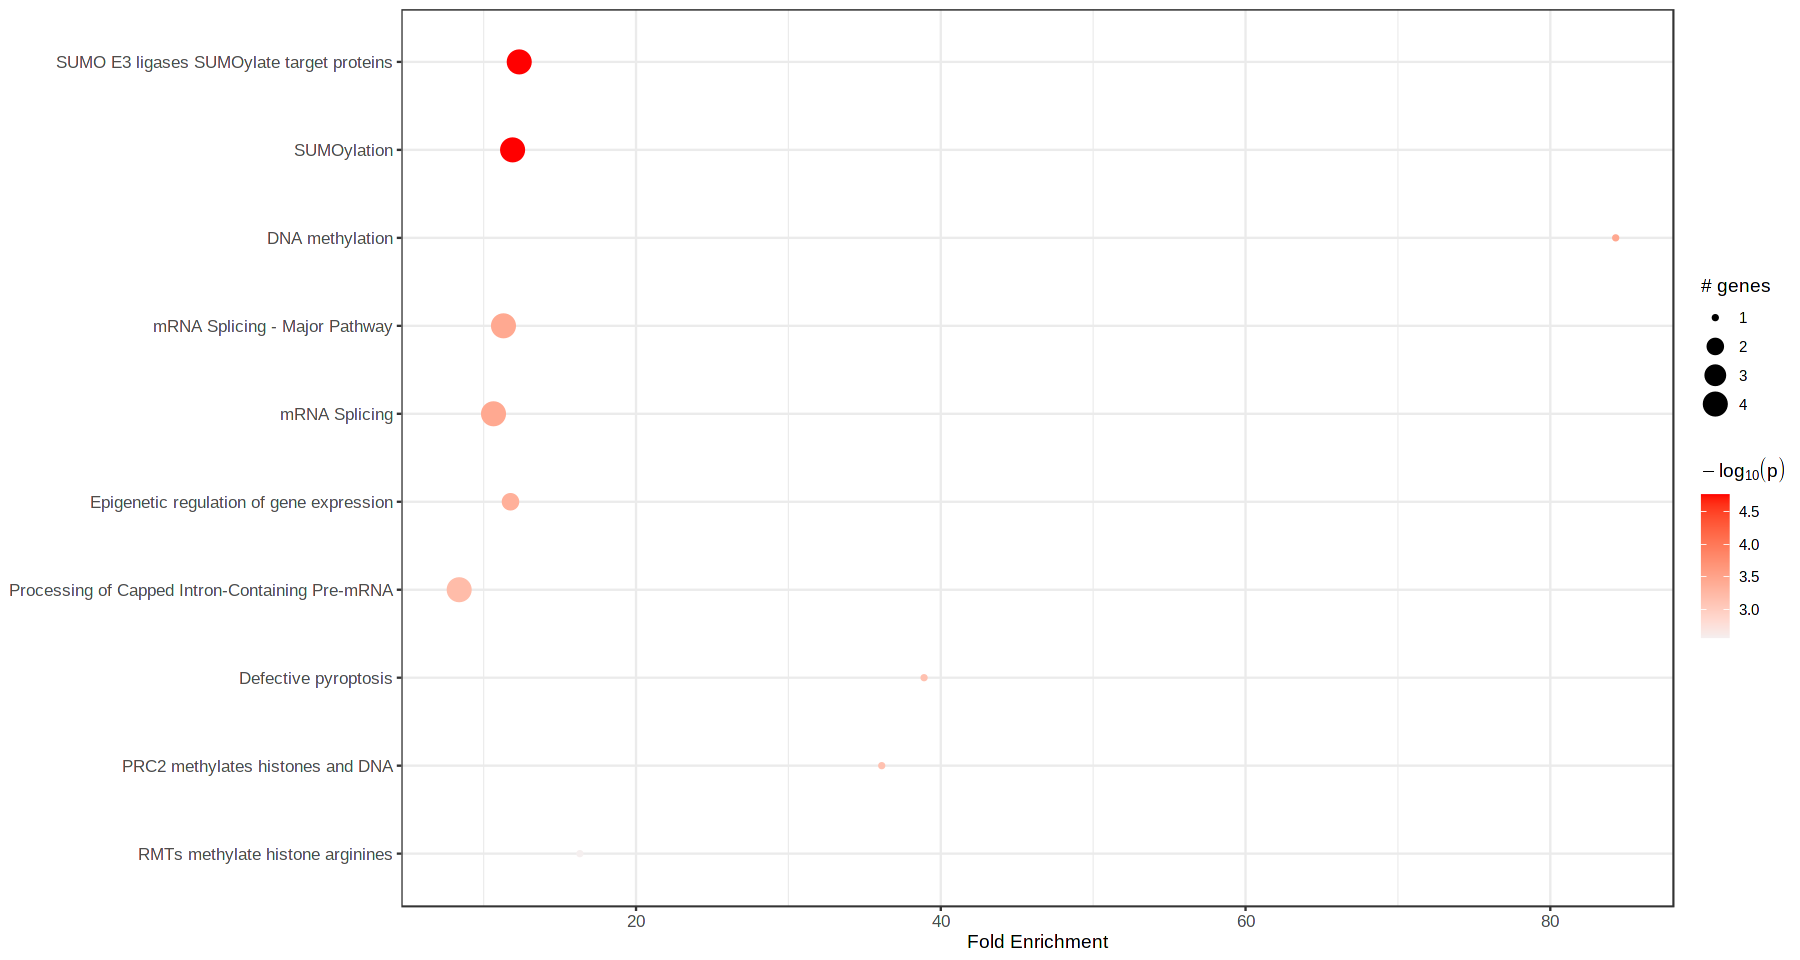

Found 34 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(27)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(23)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 47

Number of genes in input after p-value filtering: 47

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 4 (8.51%) genes in the PIN

Final number of genes in input: 43

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing fil

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b1a25d333.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b21a078a1.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b45a3b036.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b71b4430f.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165bf4c2698.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b7cf9fc2d.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



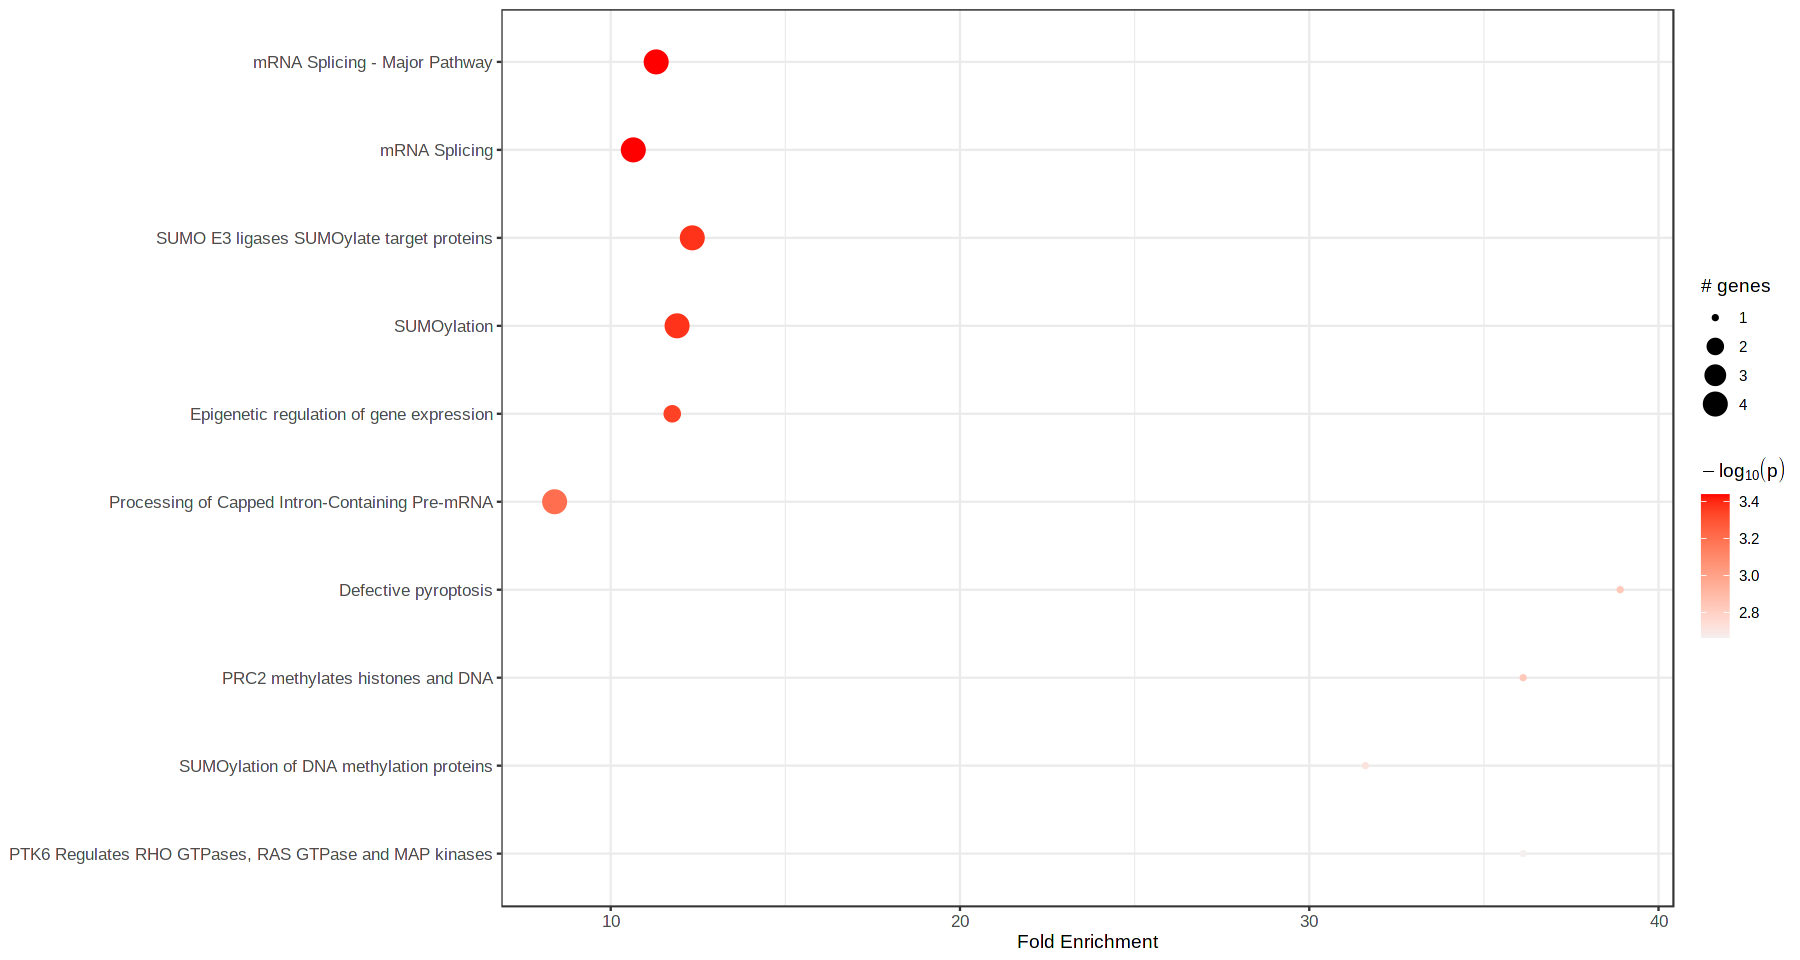

Found 32 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(23)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(23)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 47

Number of genes in input after p-value filtering: 47

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 4 (8.51%) genes in the PIN

Final number of genes in input: 43

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file:

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b7ffb0509.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b65c5f80d.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b5791503f.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b3a5984c4.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b50296199.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b78310342.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



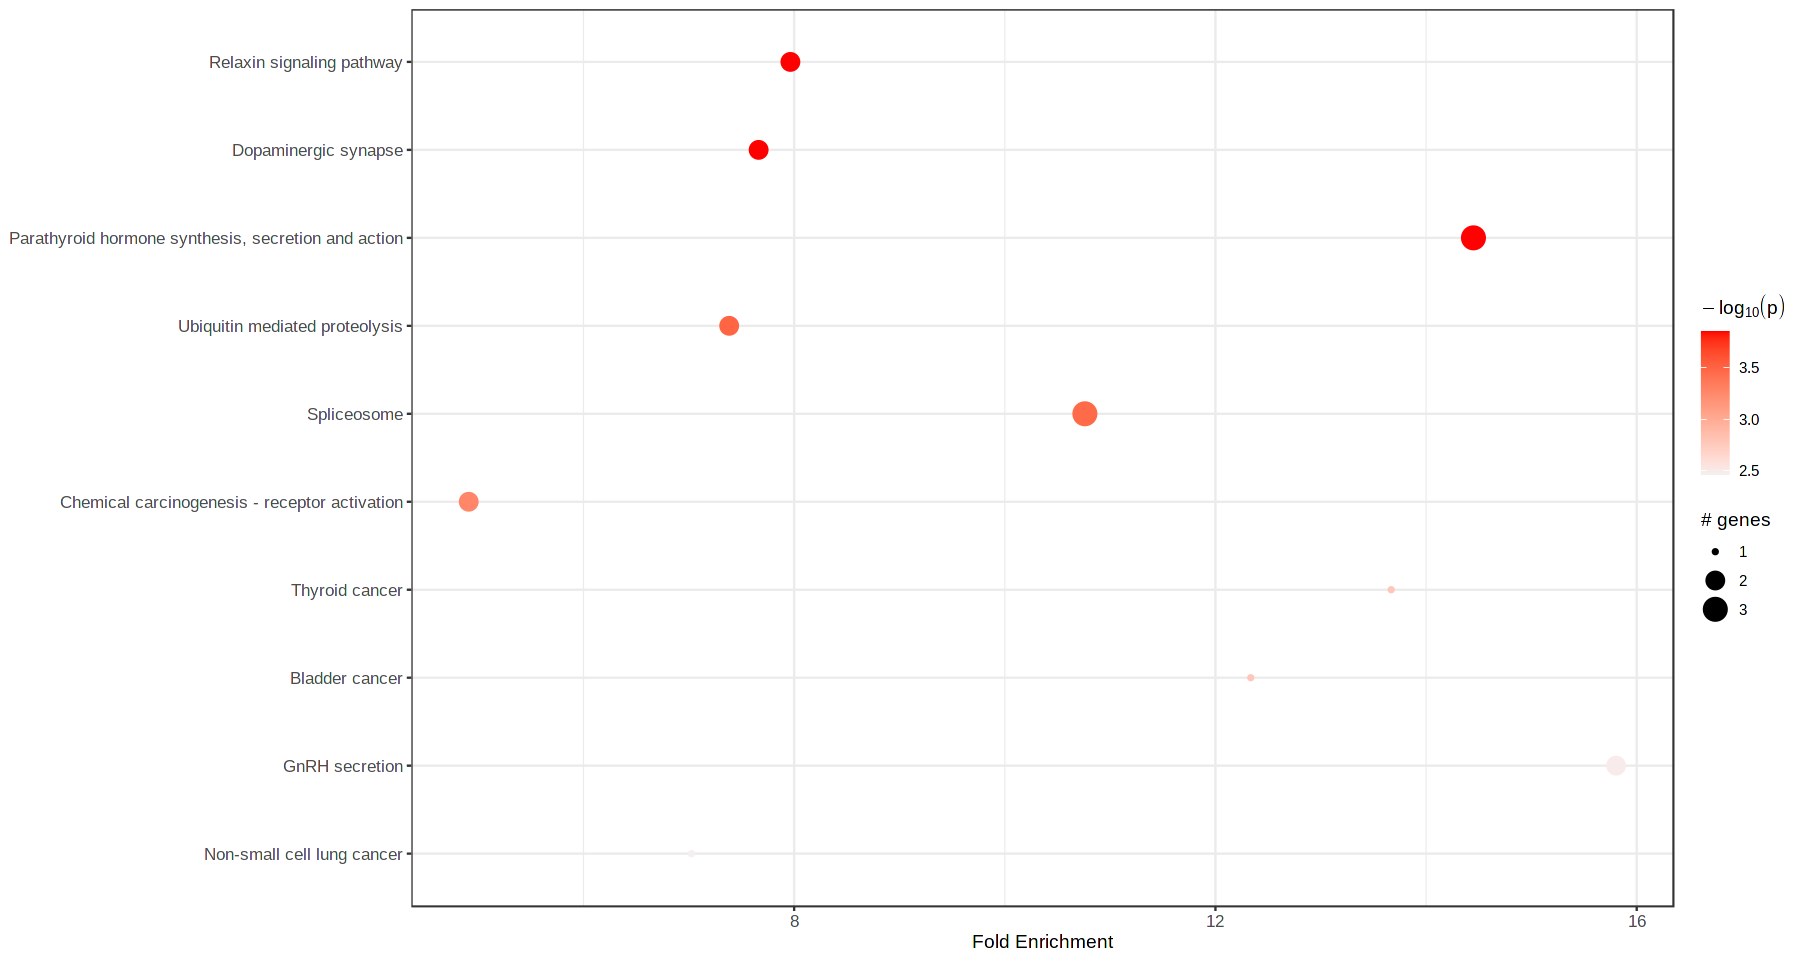

Found 33 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(23)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(28)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 47

Number of genes in input after p-value filtering: 47

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 4 (8.51%) genes in the PIN

Final number of genes in input: 43

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing fil

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b70b4f325.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b488eef1e.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b1fc5522e.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b5c442c86.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b5a66b08d.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b5b49e1c5.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



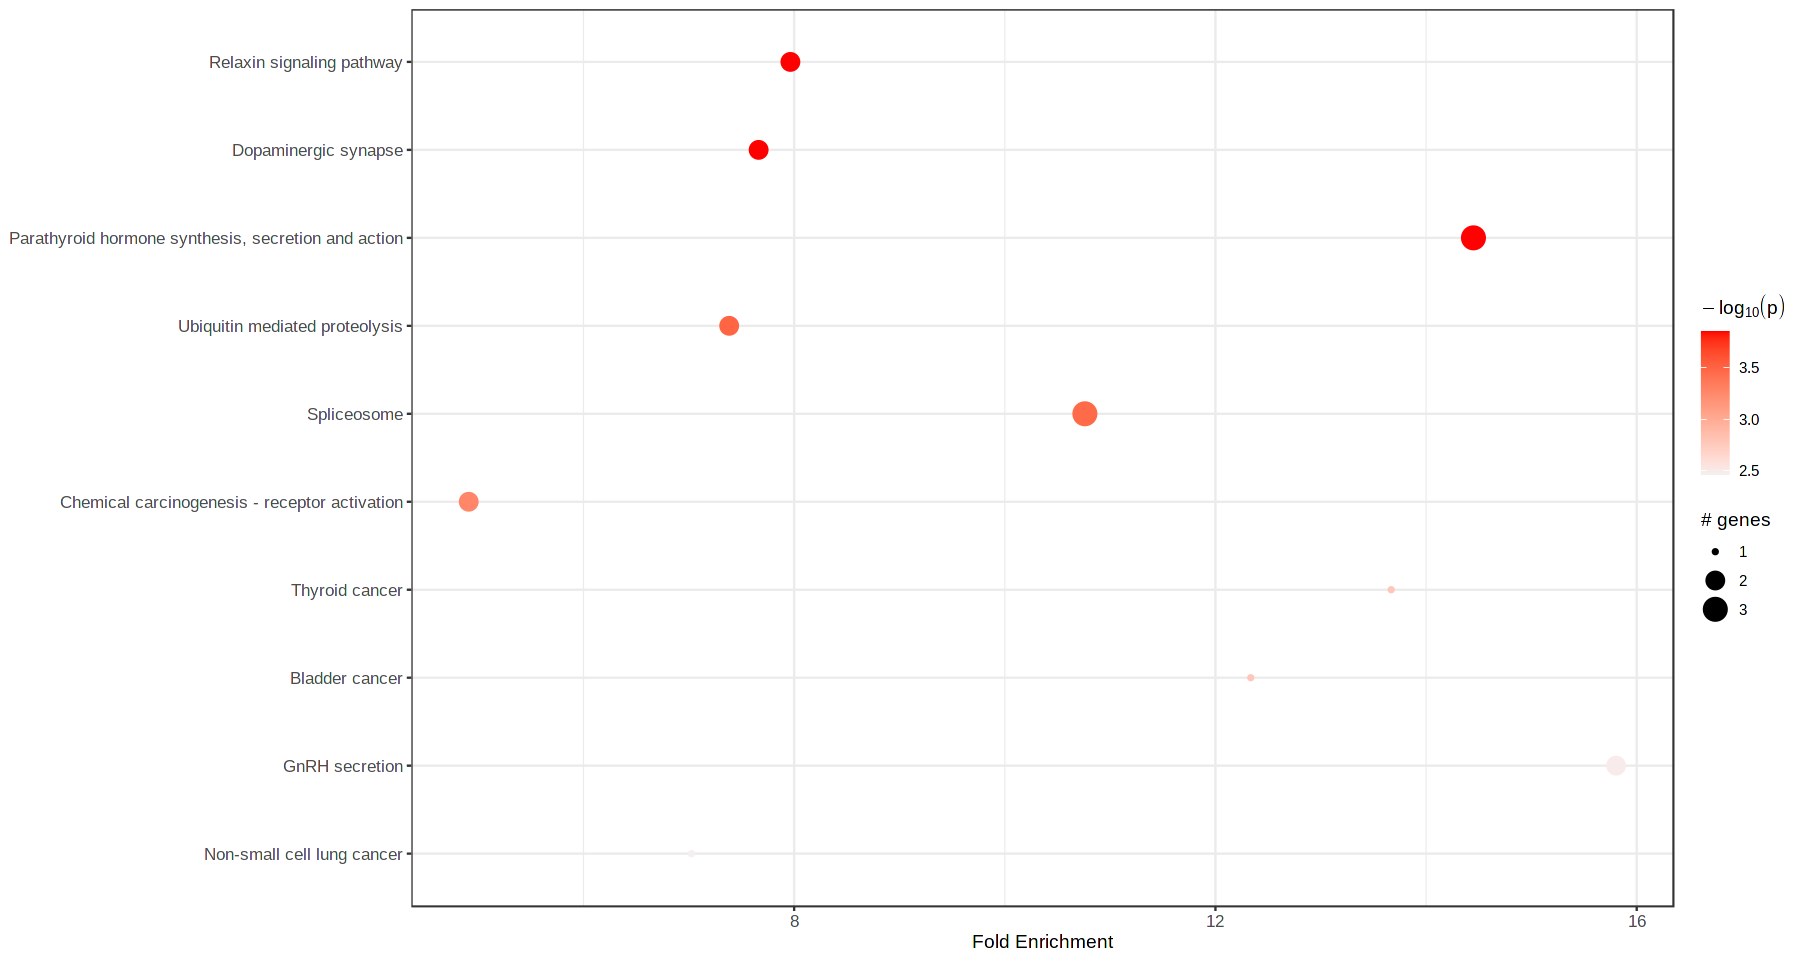

Found 4 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(28)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(24)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 47

Number of genes in input after p-value filtering: 47

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 4 (8.51%) genes in the PIN

Final number of genes in input: 43

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing fil

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165bf216ae7.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b2c4b4ca2.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b6e7df2e1.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b3321205a.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b64d8b249.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b6f3fa3f9.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



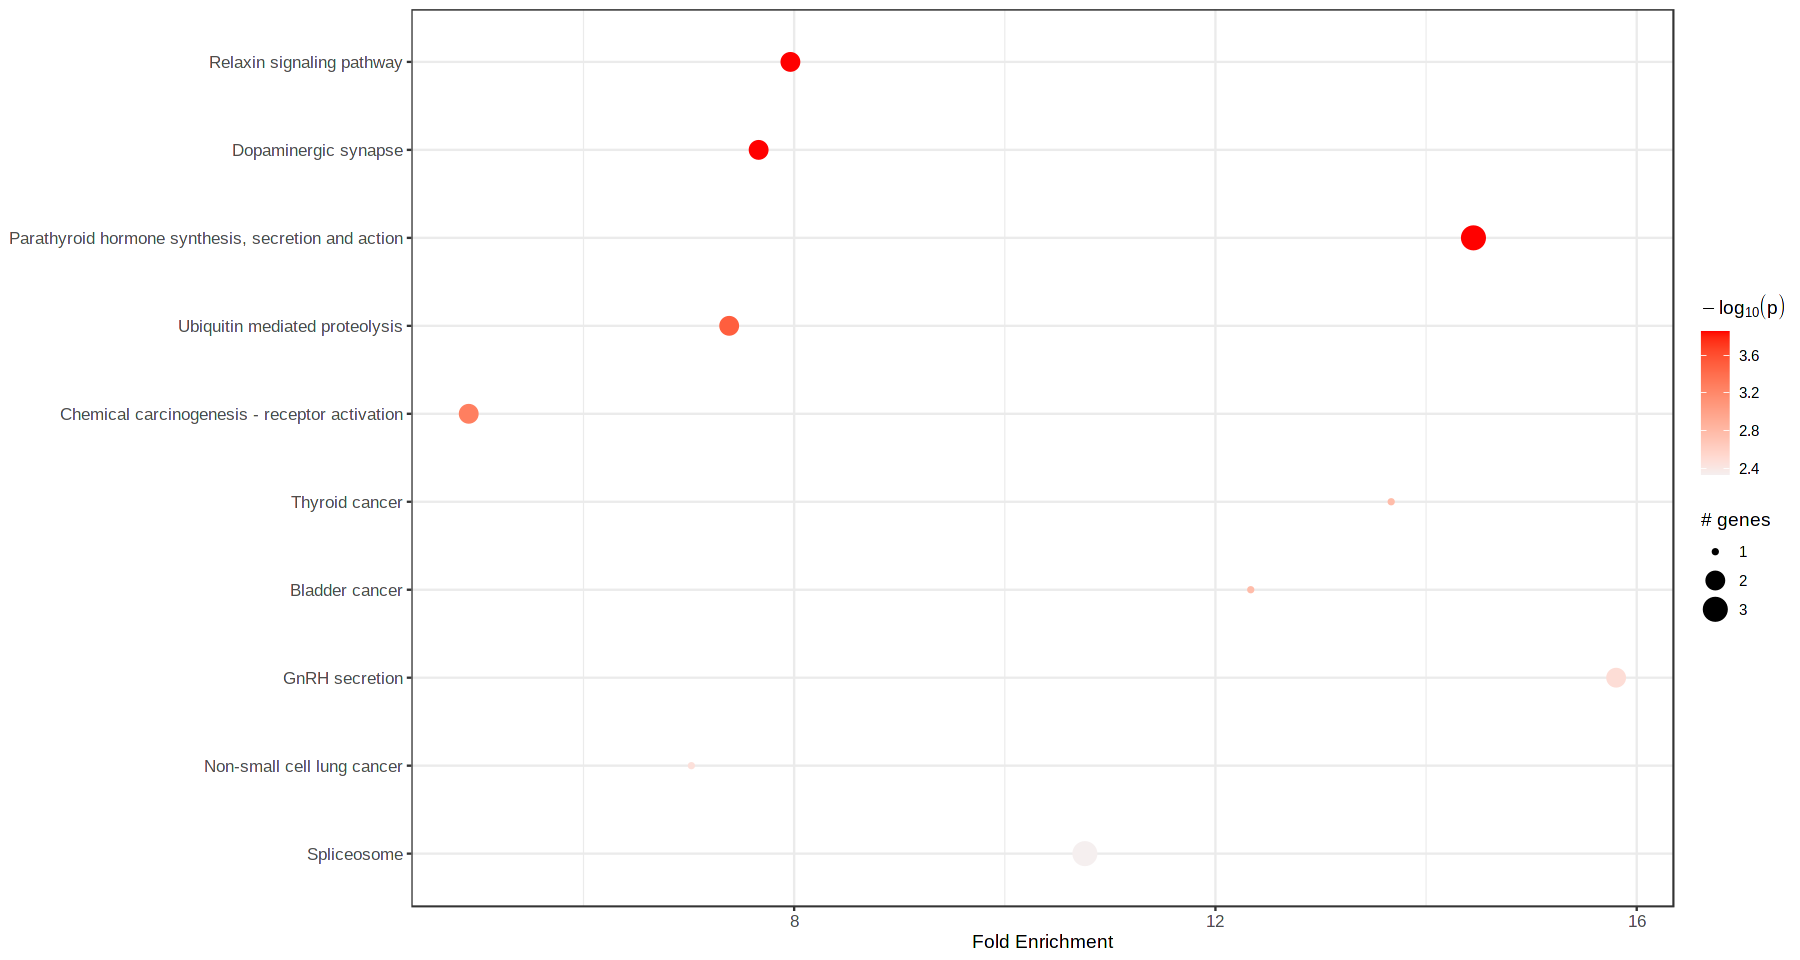

Found 4 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(24)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(24)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 47

Number of genes in input after p-value filtering: 47

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 4 (8.51%) genes in the PIN

Final number of genes in input: 43

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file:

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b1cd42f95.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b68880372.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b68cee608.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165bfa2a683.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b70db3251.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b6cededc0.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



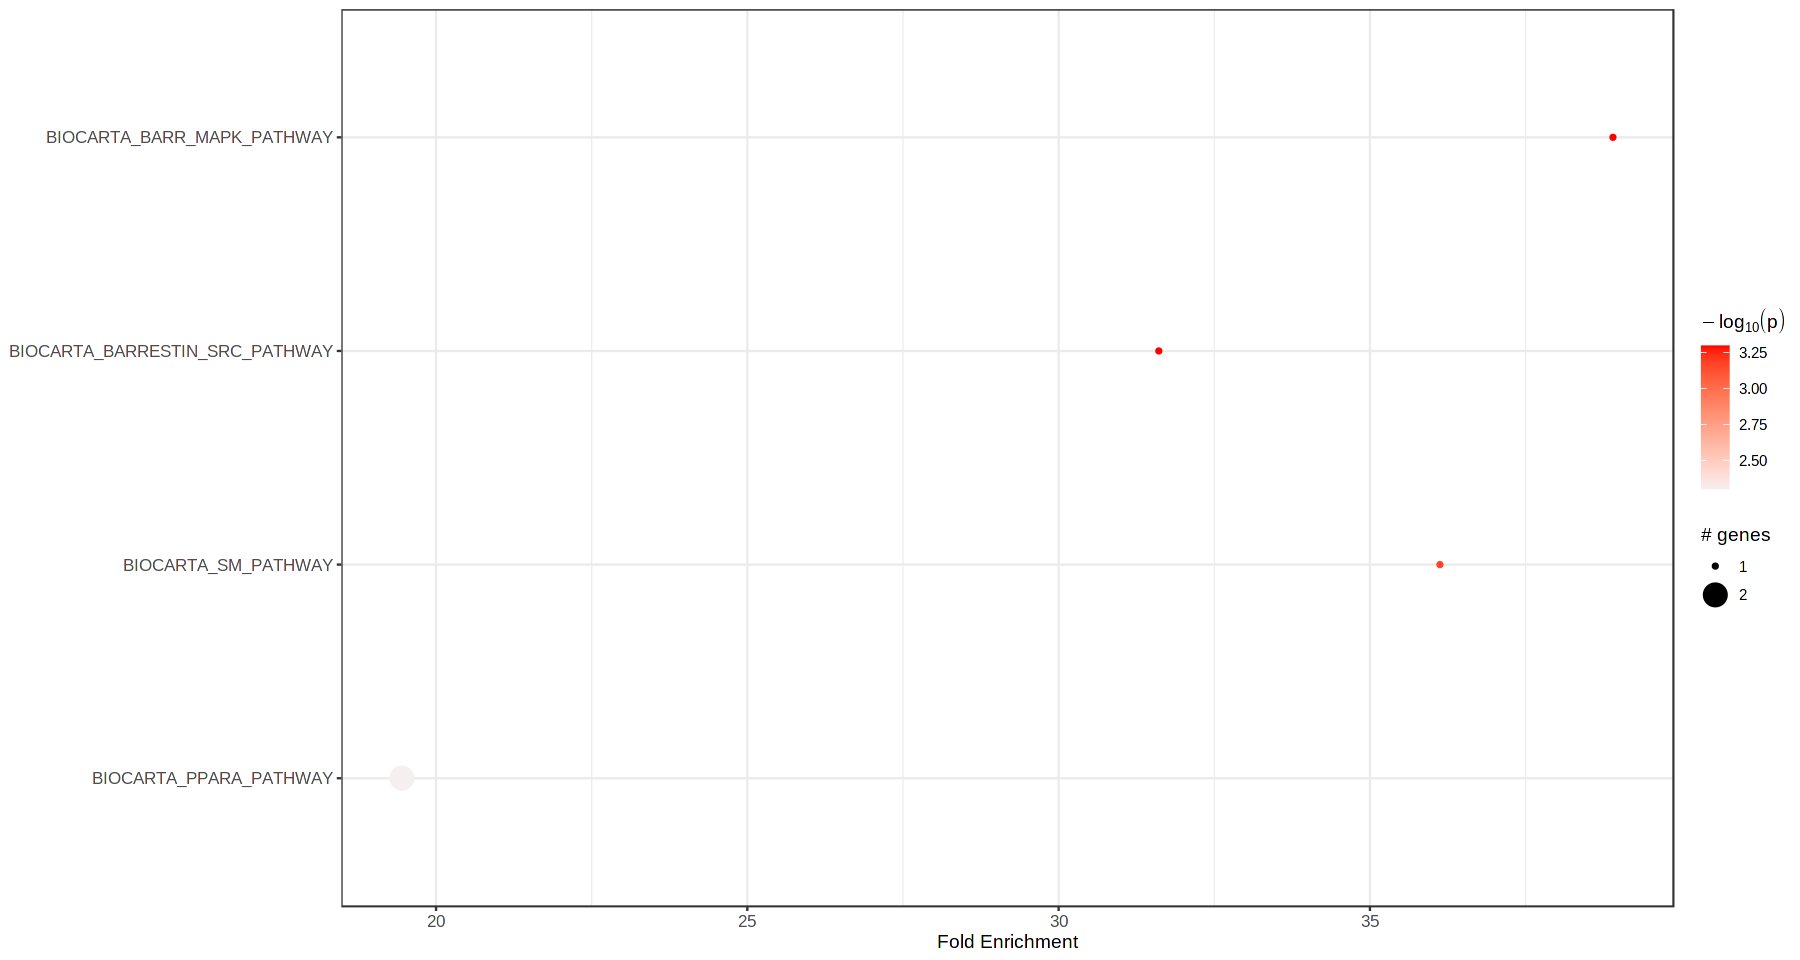

Found 4 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(24)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(29)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 47

Number of genes in input after p-value filtering: 47

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 4 (8.51%) genes in the PIN

Final number of genes in input: 43

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing fil

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b2e4cbe23.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b4279f23f.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b5ce8f2b8.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b36d9901b.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b4690e65f.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b311b24e.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



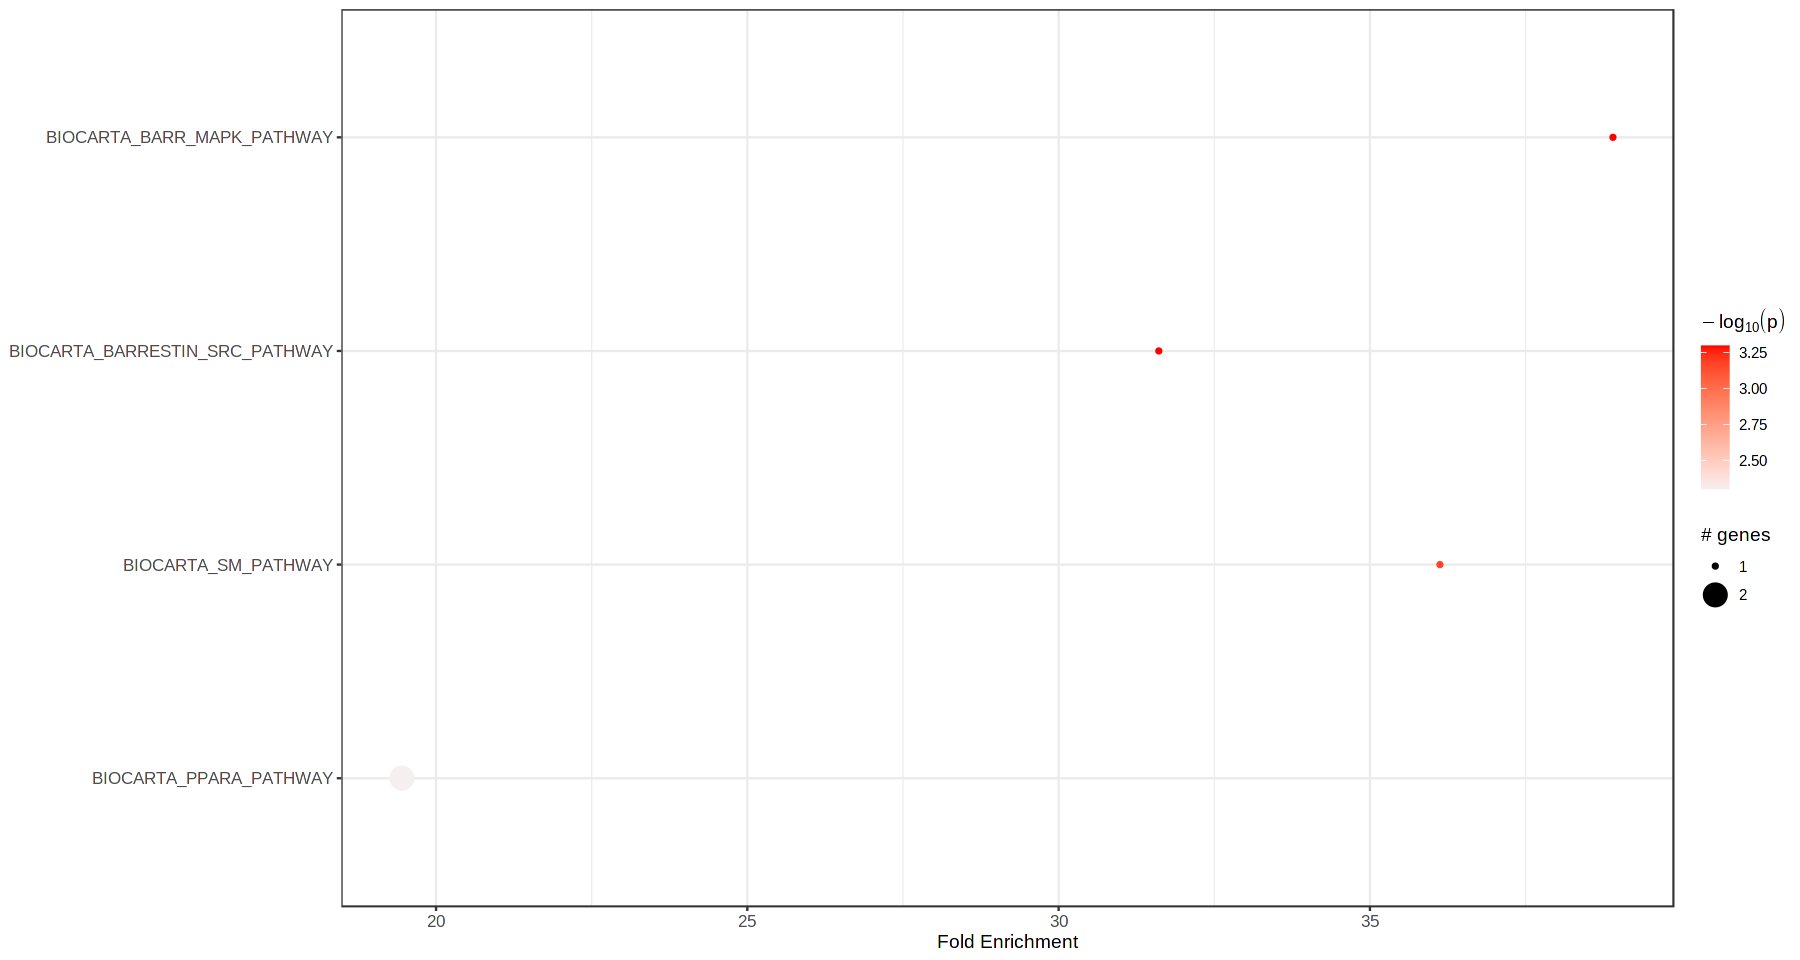

Found 4 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/macrophage(29)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(25)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 47

Number of genes in input after p-value filtering: 47

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 4 (8.51%) genes in the PIN

Final number of genes in input: 43

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing fil

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b59b10756.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b72f337ec.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b1c12797f.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b55c8770a.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b3cff67a2.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b7c5c1d38.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



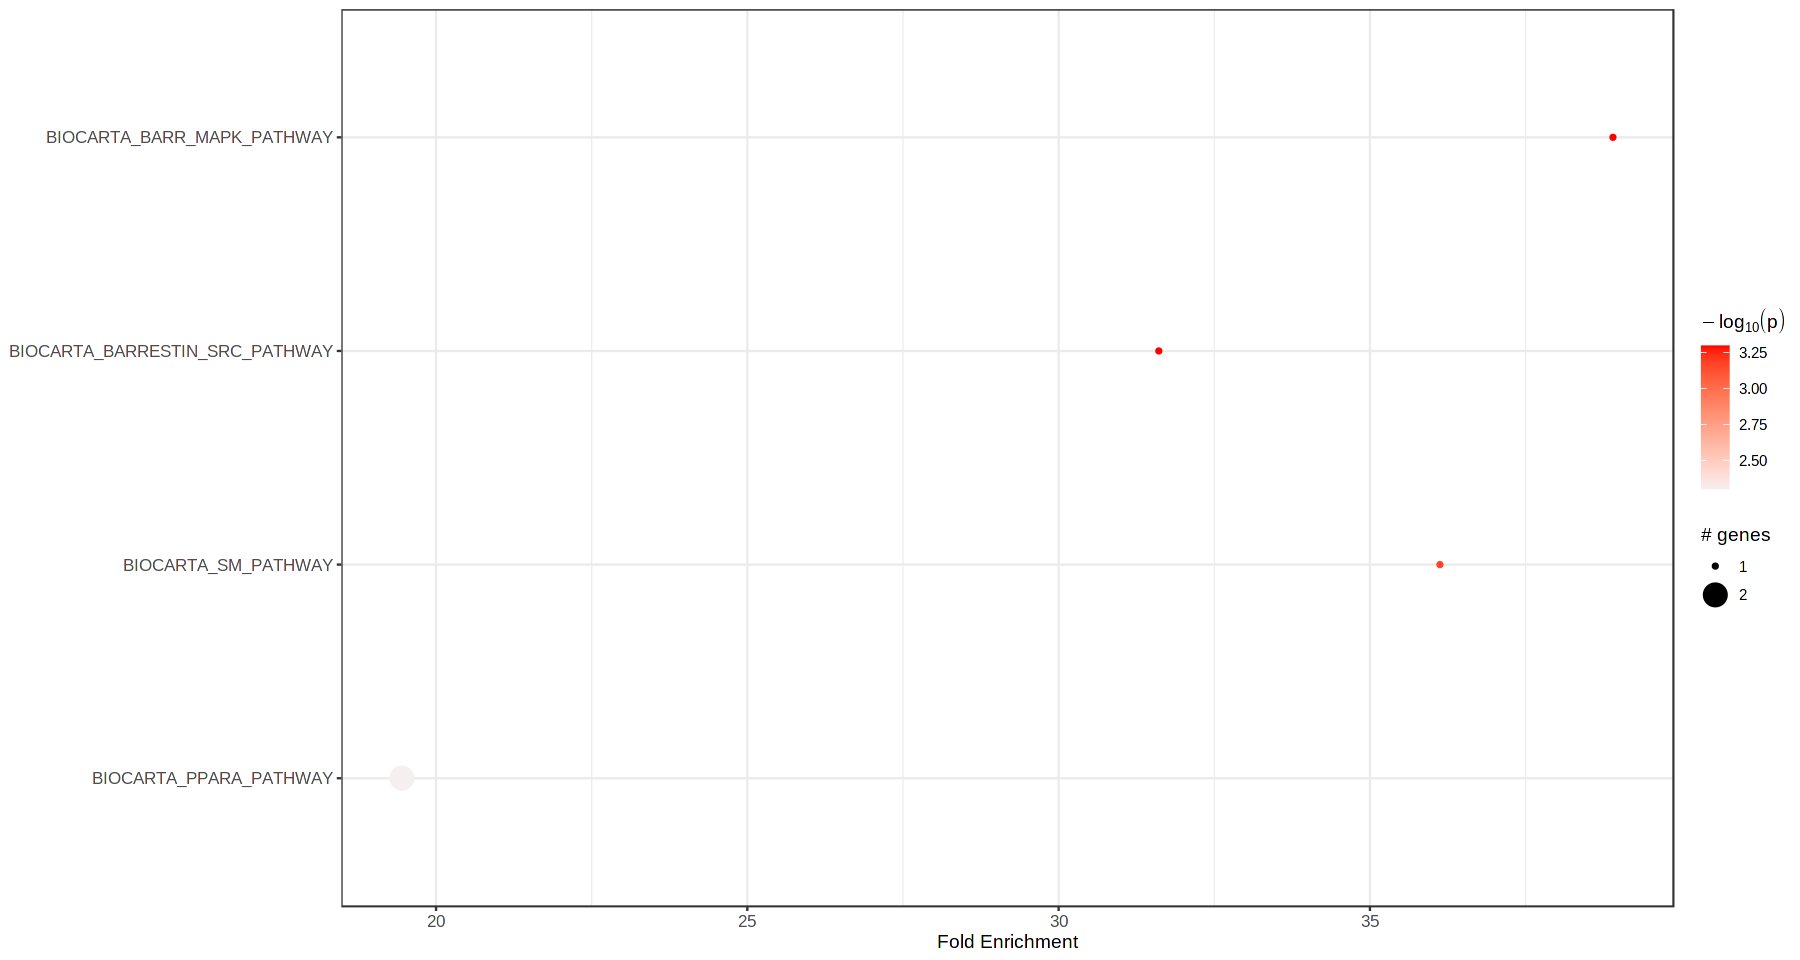

Found 5 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/macrophage(25)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  macrophage"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(25)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 47

Number of genes in input after p-value filtering: 47

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 4 (8.51%) genes in the PIN

Final number of genes in input: 43

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing file:

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b6facd12a.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b1d4f0fa9.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b6aa3ab5e.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b1af7f87a.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b799753fa.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b3b54bcc9.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



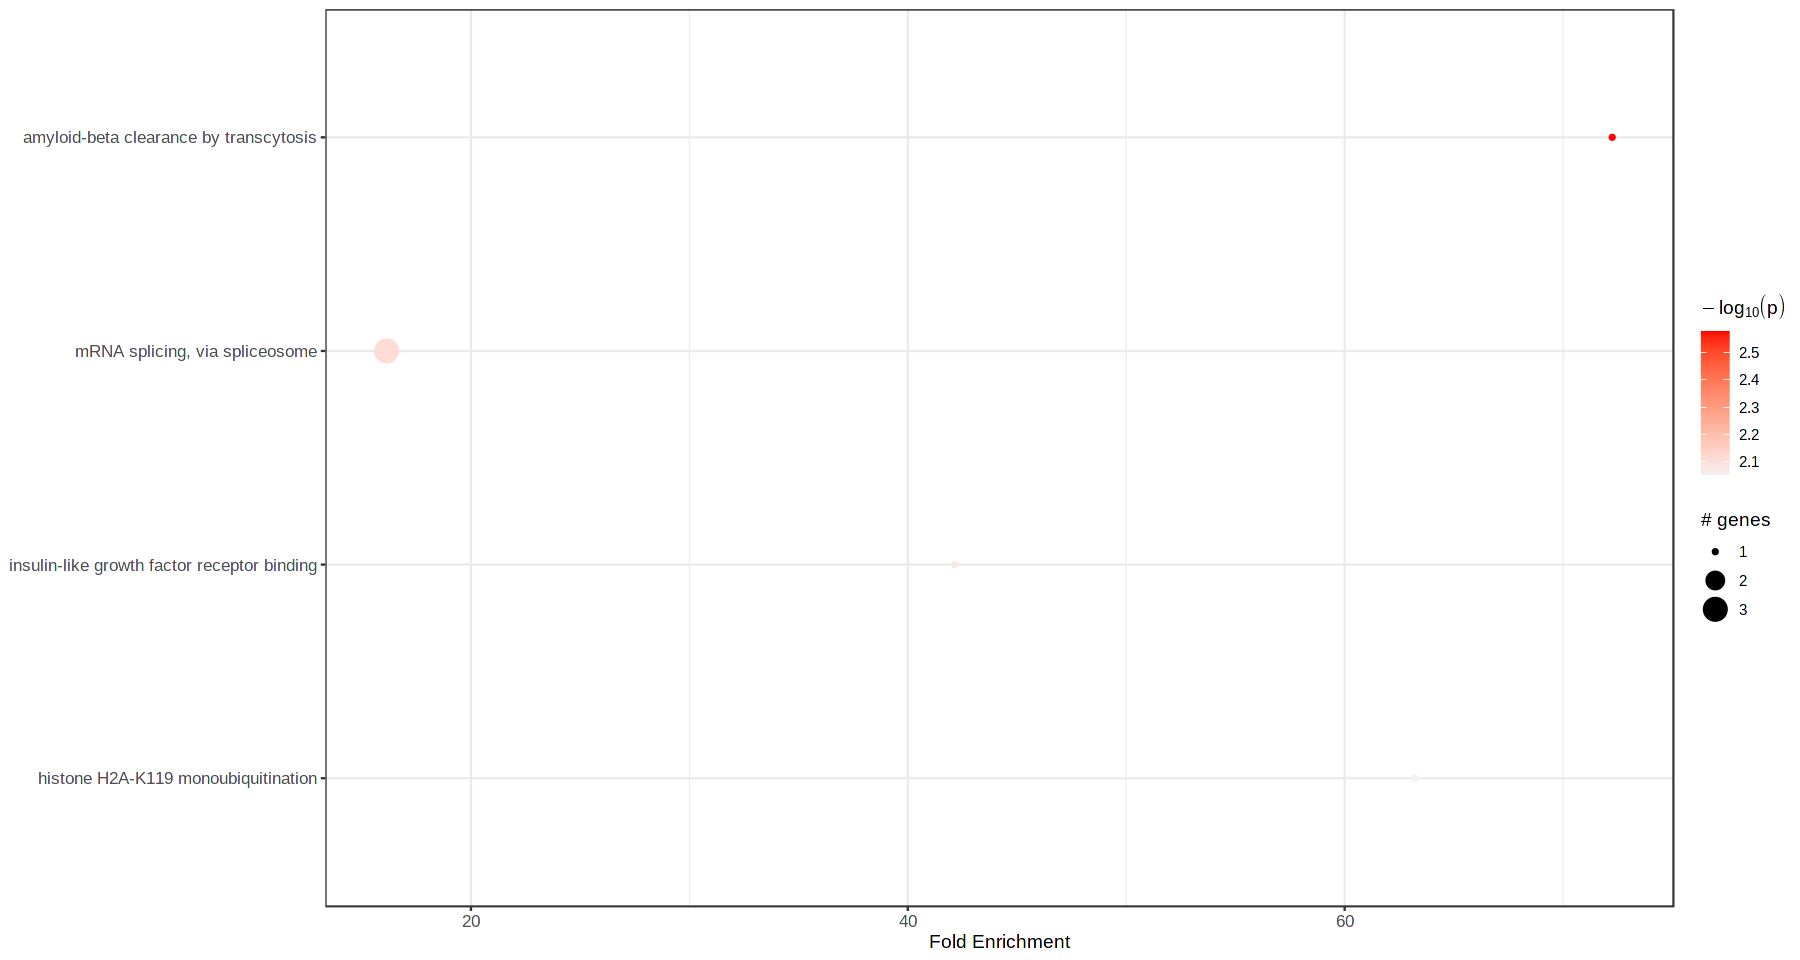

Found 7 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/macrophage(25)"


Run cluster_enriched_terms() for clustering enriched terms





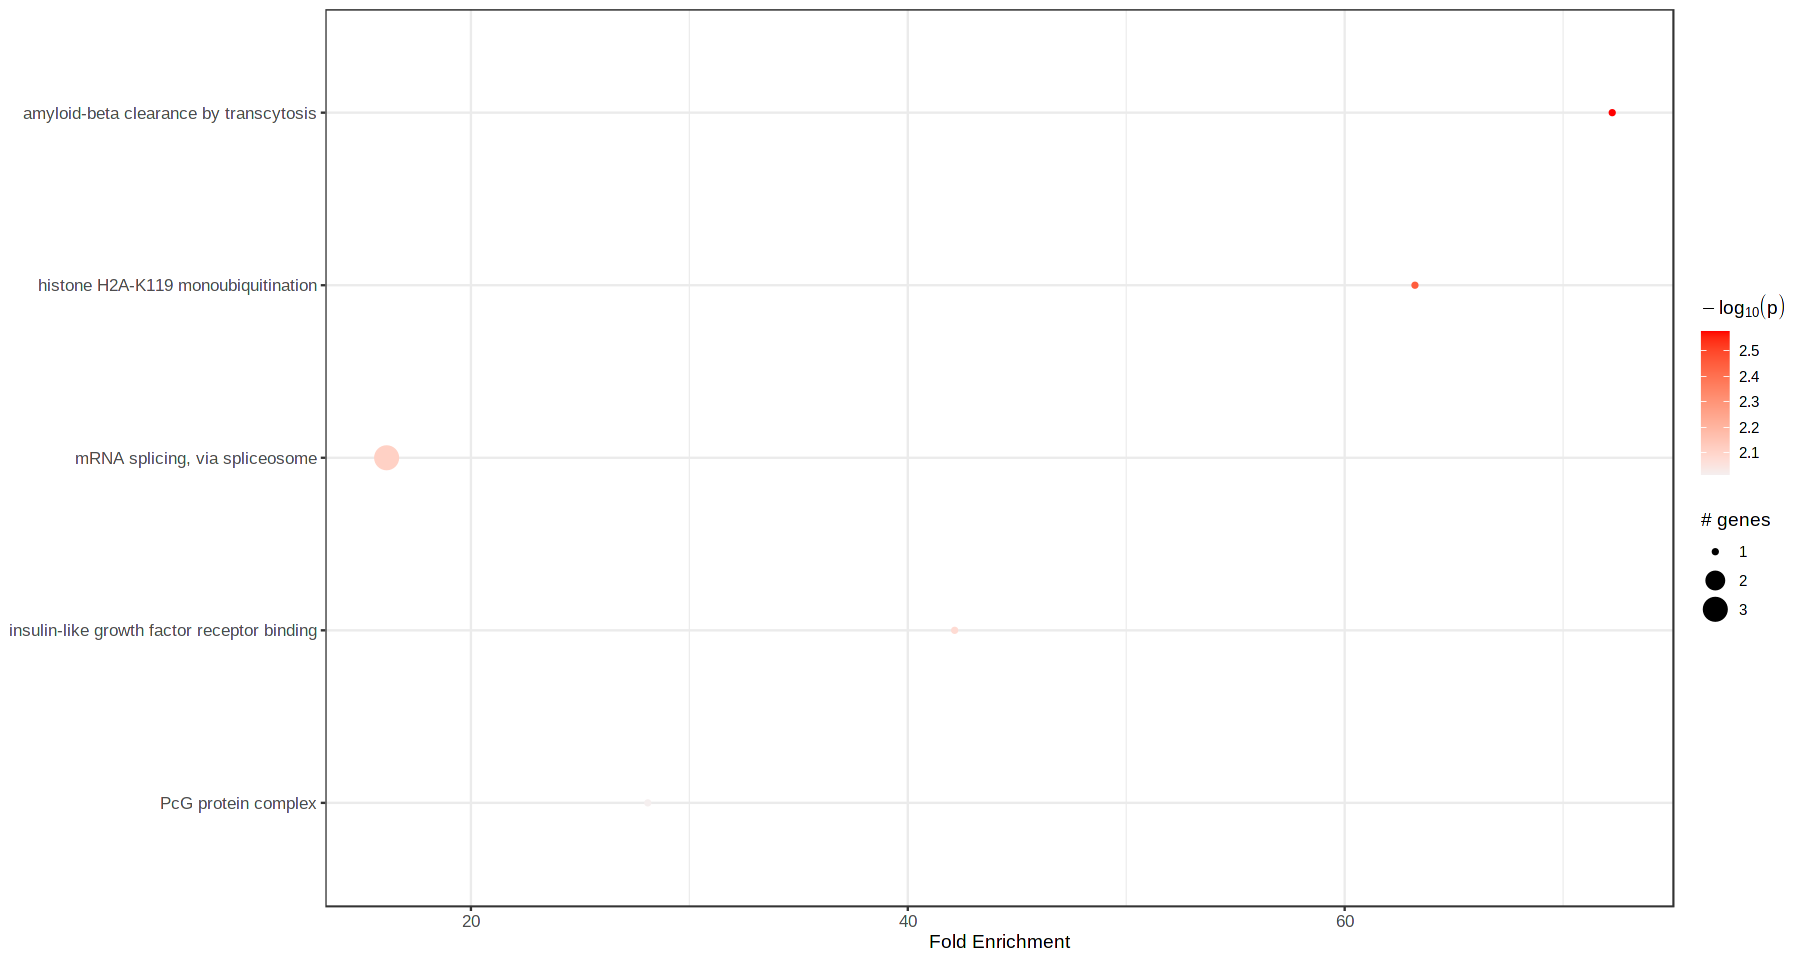

[1] "Done cell type  lung ...  macrophage"


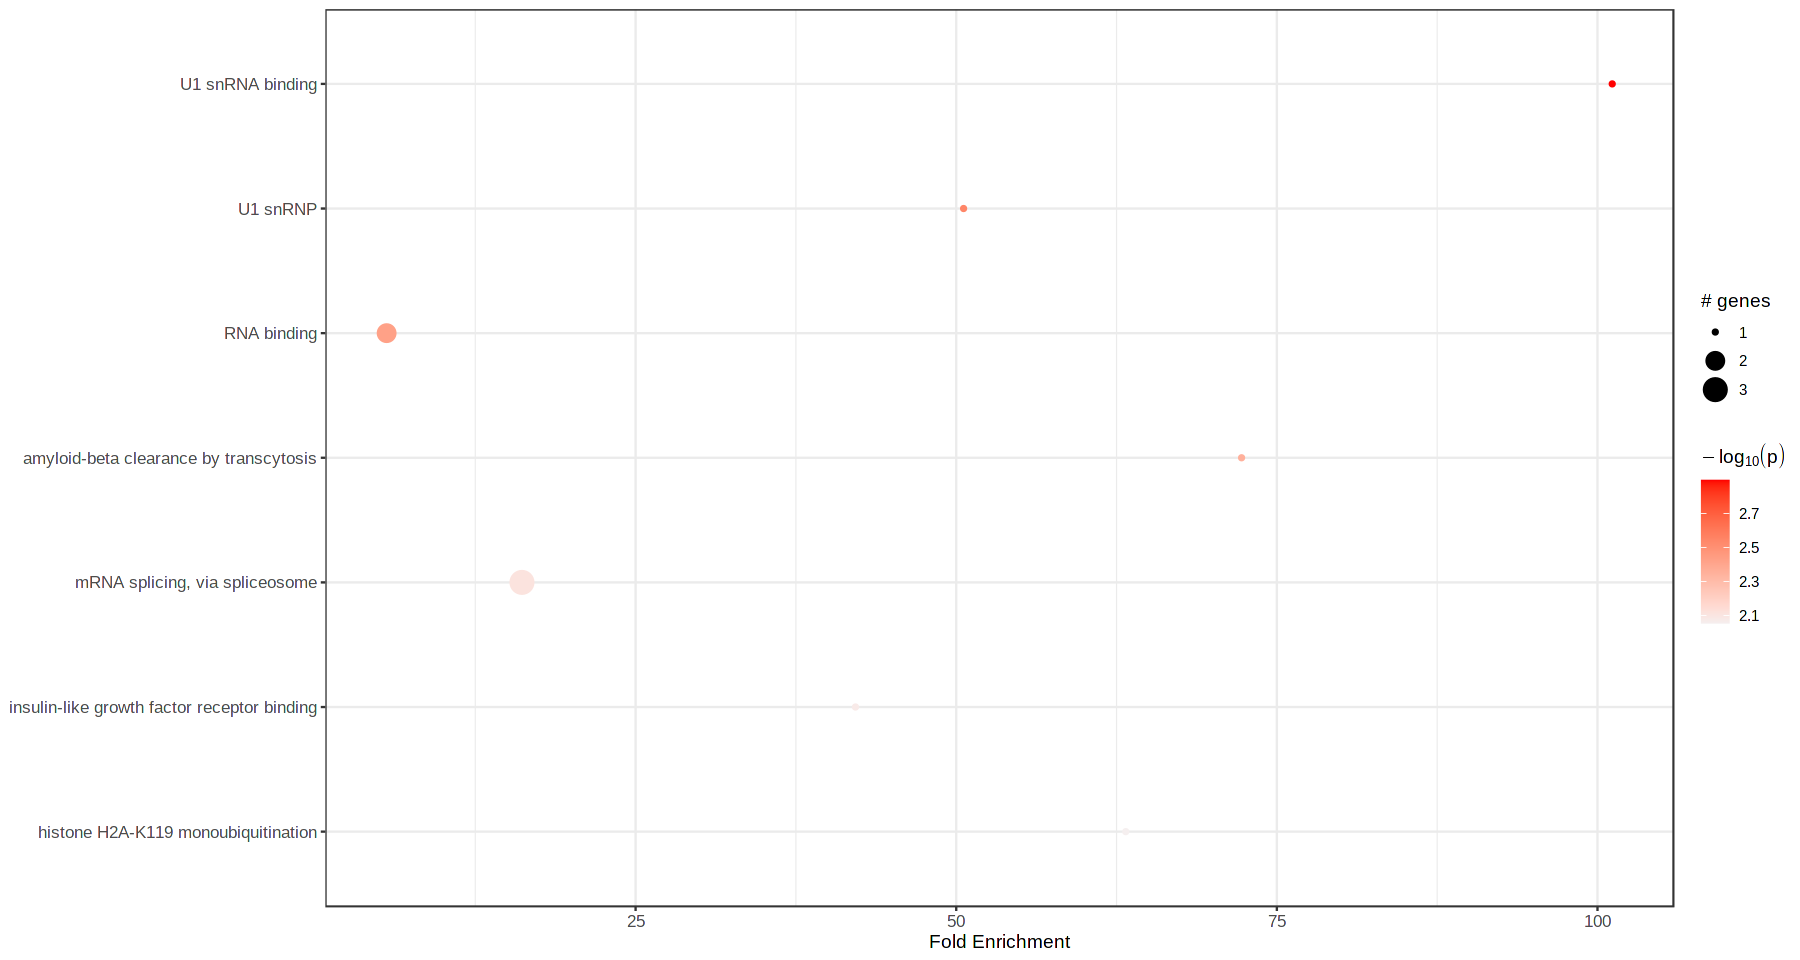

In [850]:
# Macrophages 

runAll_databases(master_df, this_class = 'macrophage',
                             db_list = c('Reactome','KEGG','BioCarta','GO-All') ,
                             tissue_list = c('liver','heart','lung'))

`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(24)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 297

Number of genes in input after p-value filtering: 297

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 2 (0.67%) genes in the PIN

Final number of genes in input: 295

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processin

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165bb45d9f5.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b494f6ab2.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b7ea65a0b.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b3397048e.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b5bb8409f.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b7612f09b.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart

Found 315 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(24)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(24)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 213

Number of genes in input after p-value filtering: 213

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 2 (0.94%) genes in the PIN

Final number of genes in input: 211

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processin

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b44abc89c.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b6bd9eb8c.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b109eb292.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b79ced098.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b4ee49edf.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b6e9276b2.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart

Found 258 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(24)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(24)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 330

Number of genes in input after p-value filtering: 330

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 5 (1.52%) genes in the PIN

Final number of genes in input: 325

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing 

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b756afd10.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b34119c4c.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b1ac28b73.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b2a48f2d4.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b933ea0c.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b68a4c647.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



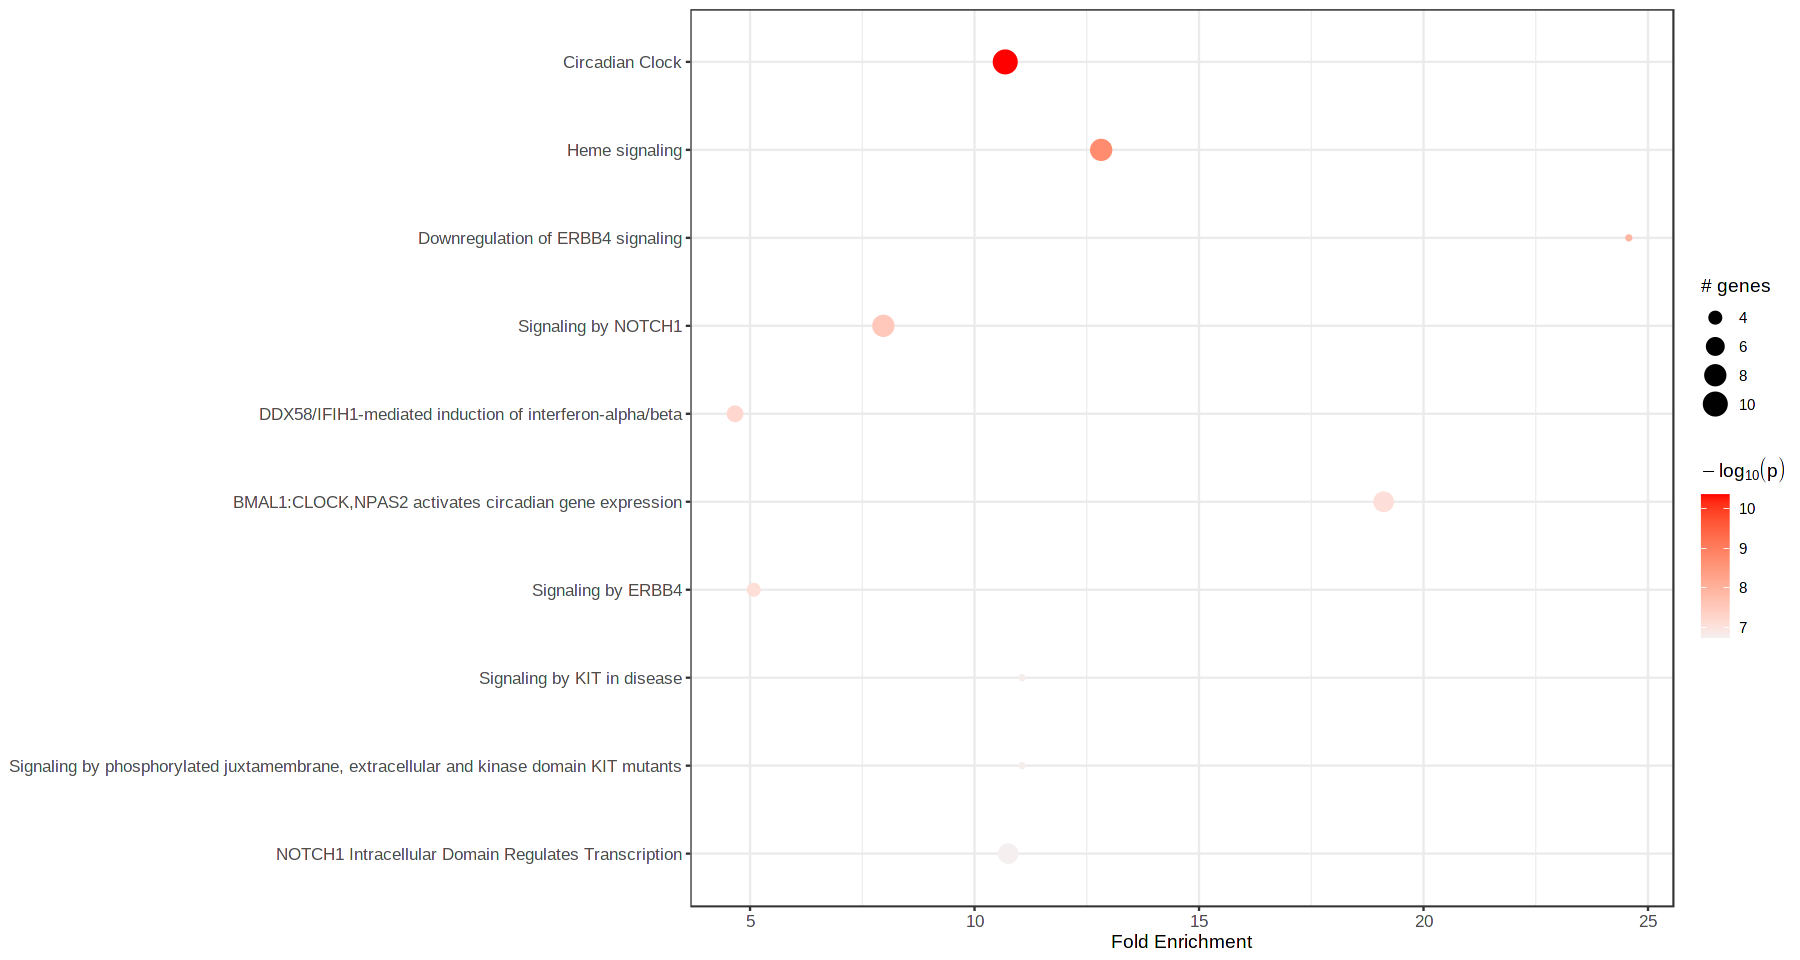

Found 306 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(24)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(25)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 297

Number of genes in input after p-value filtering: 297

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 2 (0.67%) genes in the PIN

Final number of genes in input: 295

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processin

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165becaeea7.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b2111e344.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b64b7ffb3.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b3ff449ec.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165beaf37f6.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b43aca7bb.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



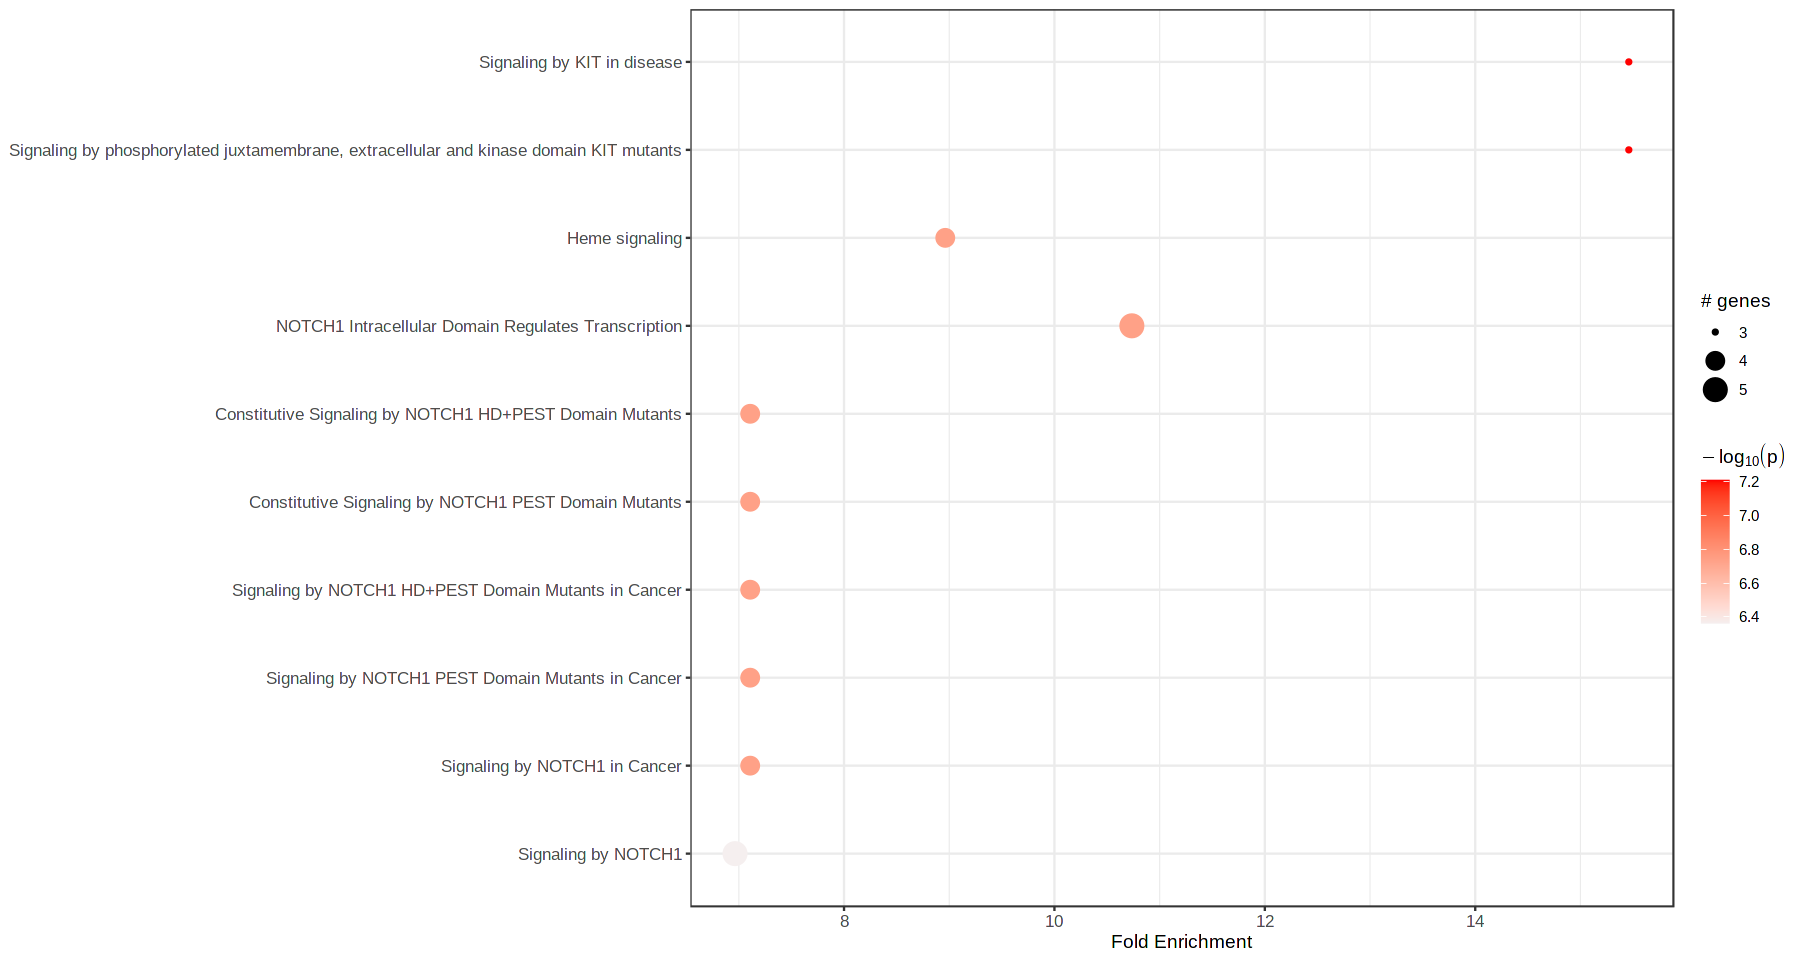

Found 96 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(25)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(25)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 213

Number of genes in input after p-value filtering: 213

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 2 (0.94%) genes in the PIN

Final number of genes in input: 211

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processin

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b631f42a3.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b25c6a2c5.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b3eadfb4a.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b5972d4d.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b3dc5b76f.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b25e82d76.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



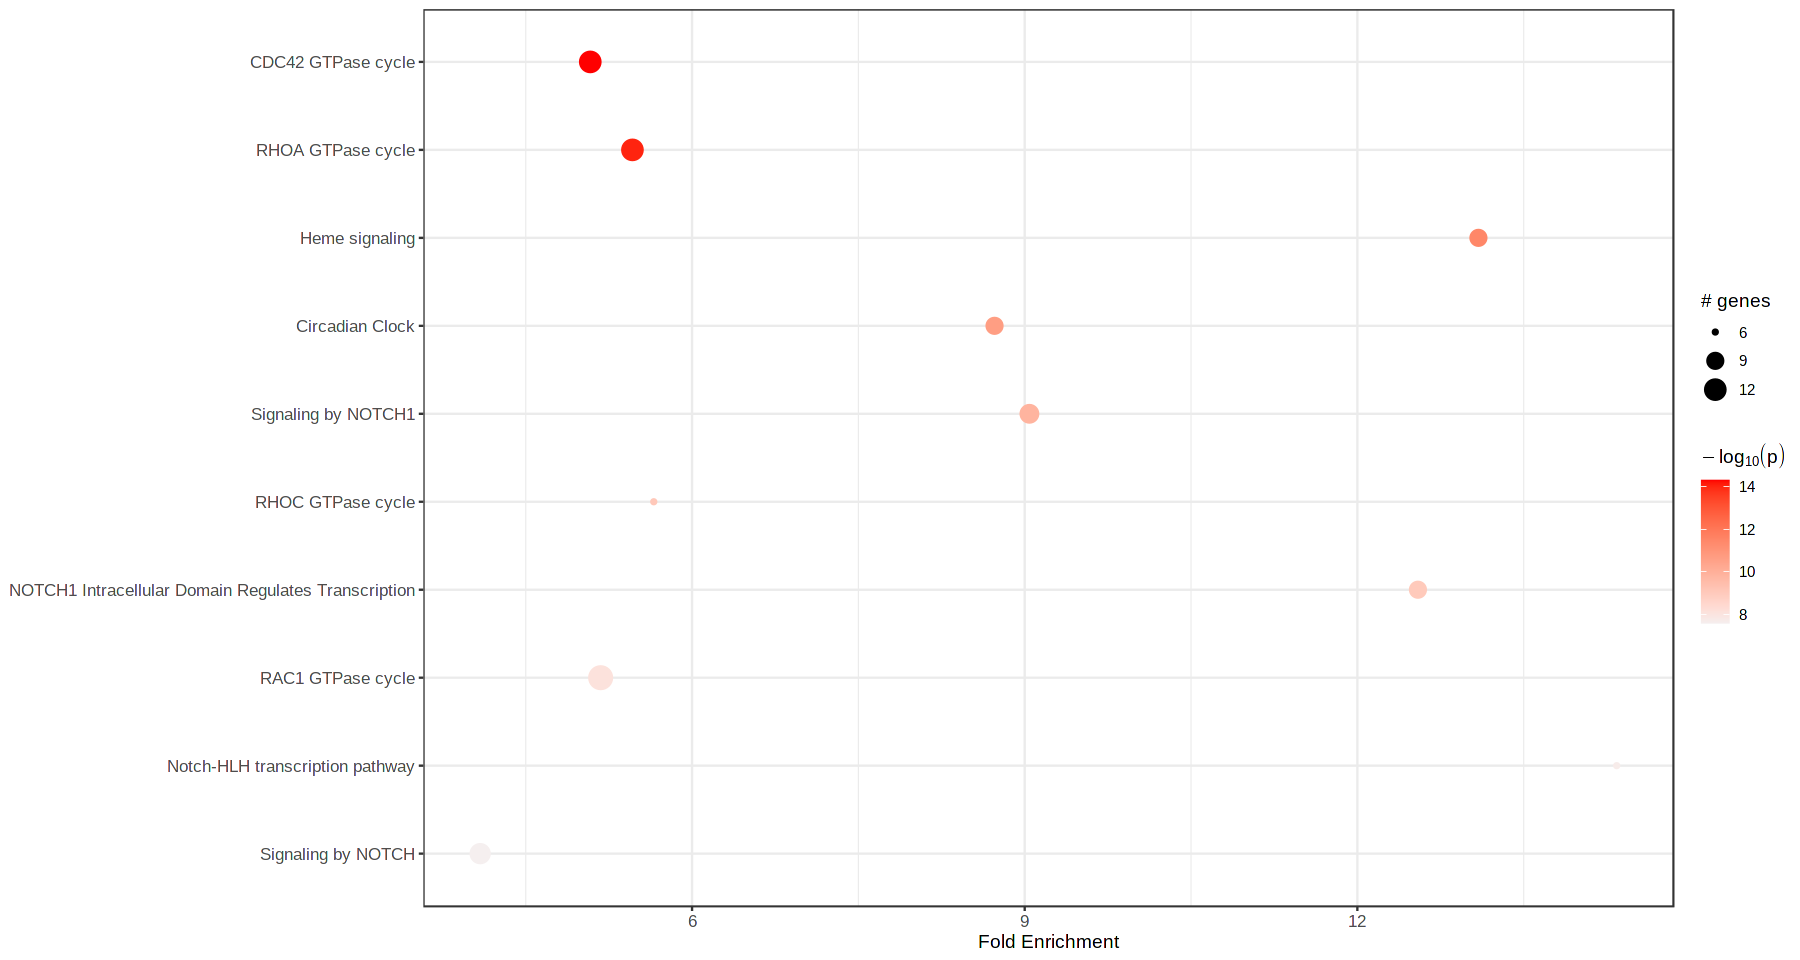

Found 81 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(25)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(25)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 330

Number of genes in input after p-value filtering: 330

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 5 (1.52%) genes in the PIN

Final number of genes in input: 325

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing 

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b35e22e15.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b4fe93848.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b46c953da.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b6520237.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b7138b56f.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b73a3adc0.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



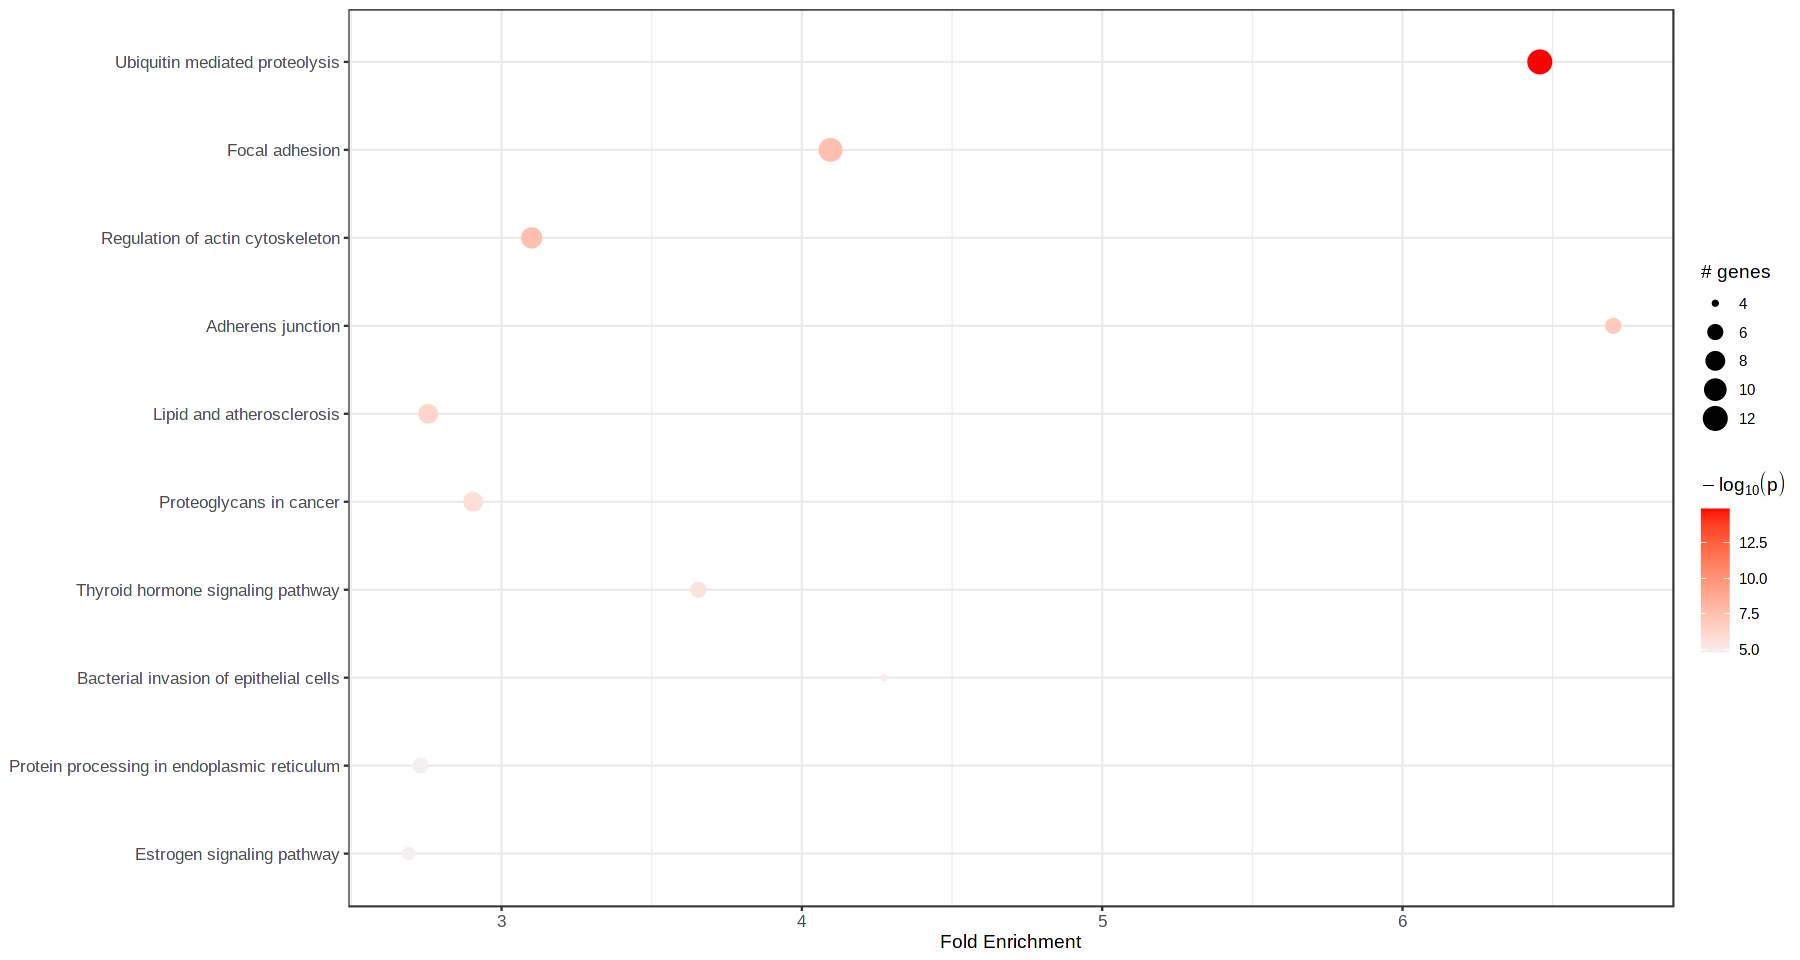

Found 105 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(25)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(26)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 297

Number of genes in input after p-value filtering: 297

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 2 (0.67%) genes in the PIN

Final number of genes in input: 295

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processin

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b25ba5b56.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b78dad980.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b65c47976.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b5c364cfb.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b78b0b7a6.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b1f4ba54f.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



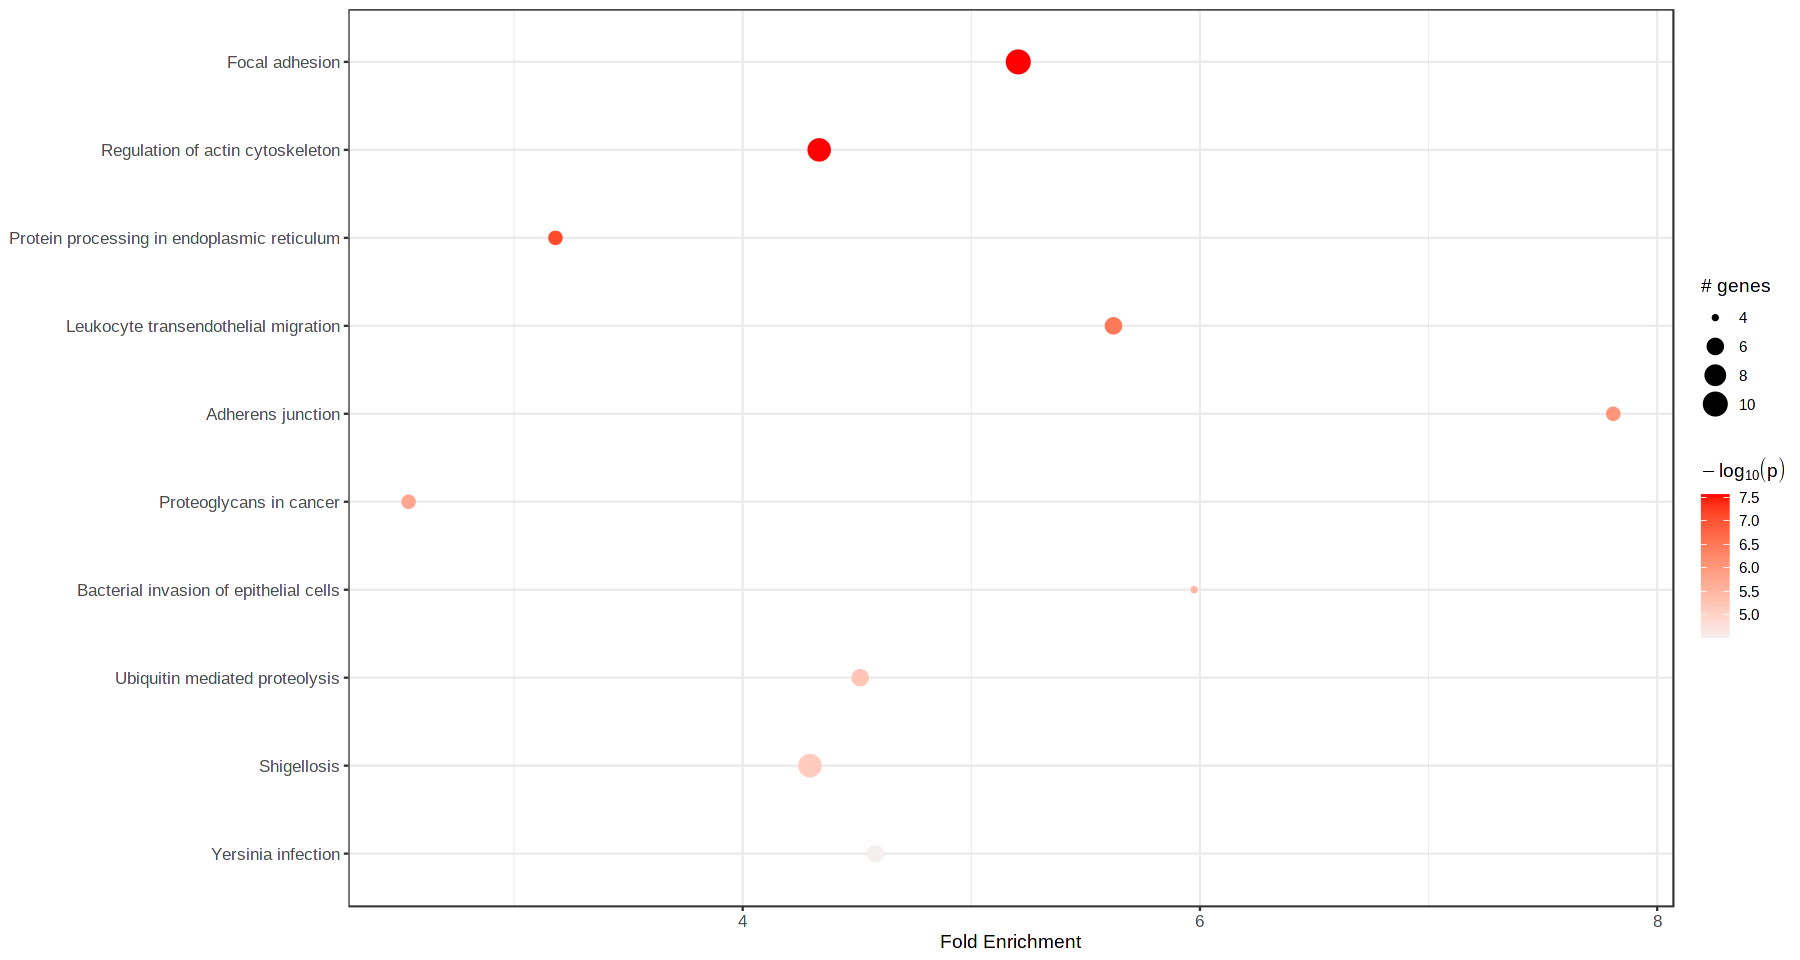

Found 42 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(26)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(26)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 213

Number of genes in input after p-value filtering: 213

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 2 (0.94%) genes in the PIN

Final number of genes in input: 211

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processin

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b4cd840ed.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b13b317f1.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165bdec428f.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b586563de.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b79dd8611.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b59f490c1.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



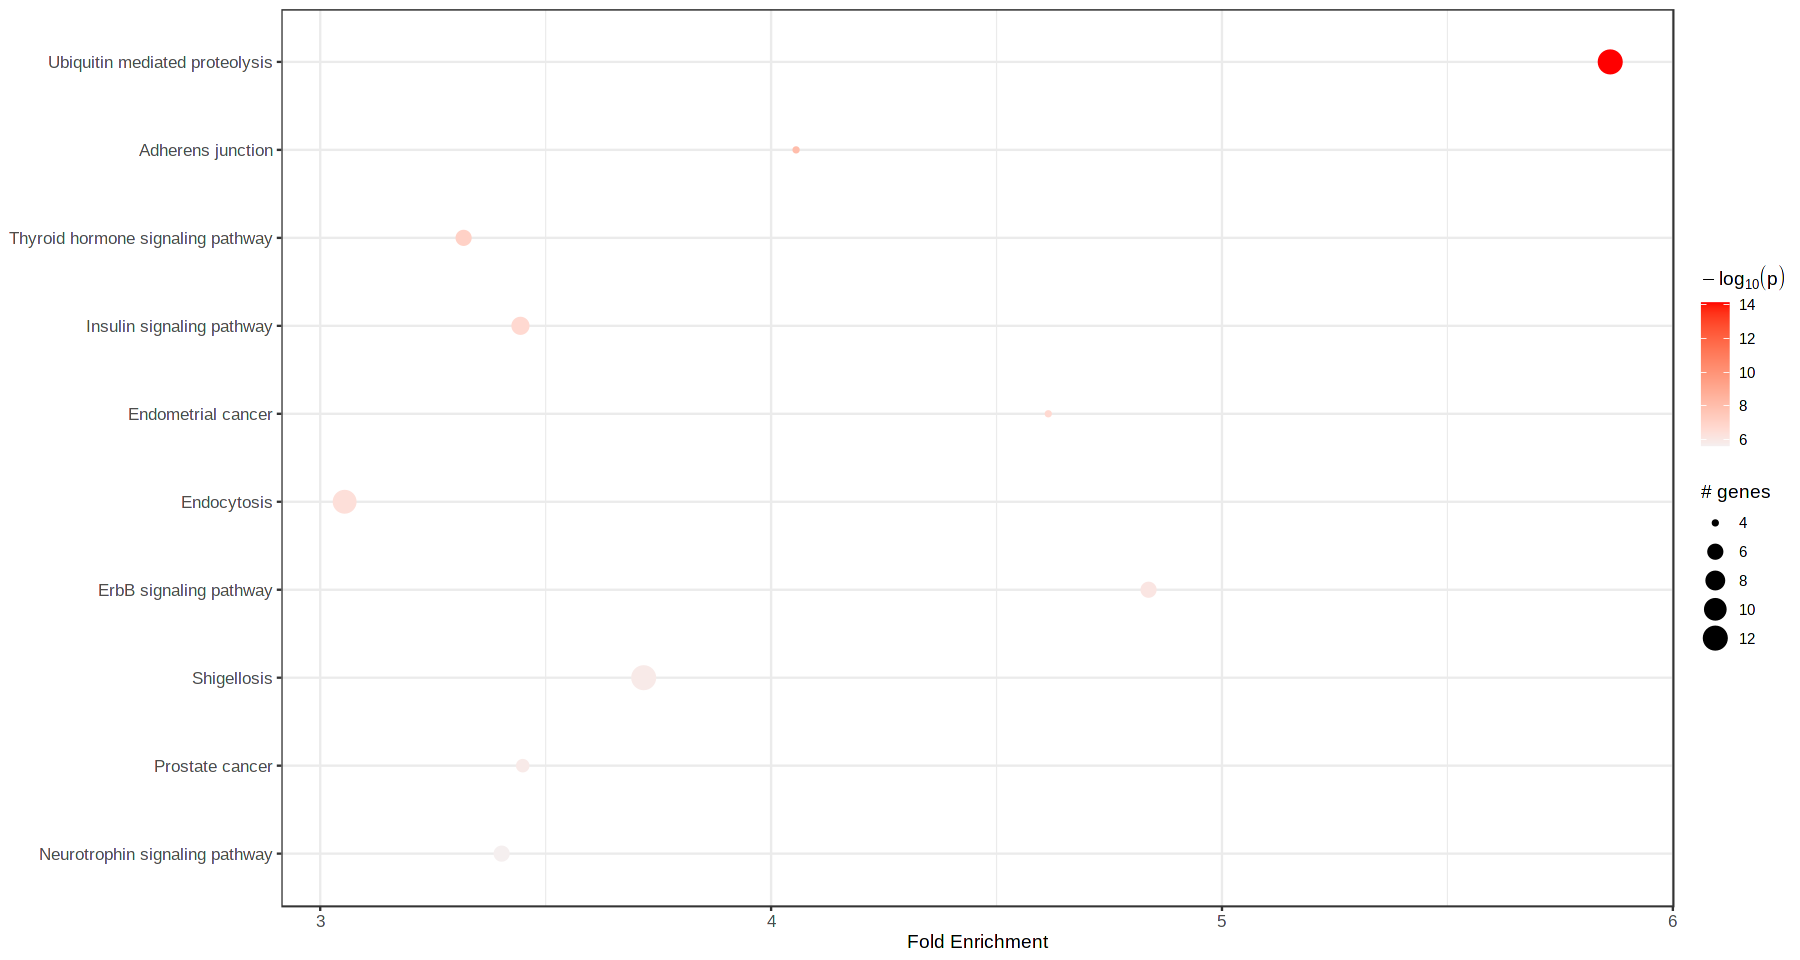

Found 38 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(26)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(26)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 330

Number of genes in input after p-value filtering: 330

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 5 (1.52%) genes in the PIN

Final number of genes in input: 325

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing 

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b17906f95.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b7063e487.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b1cf8f494.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b30986f4a.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b77f9862b.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b38c22faa.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



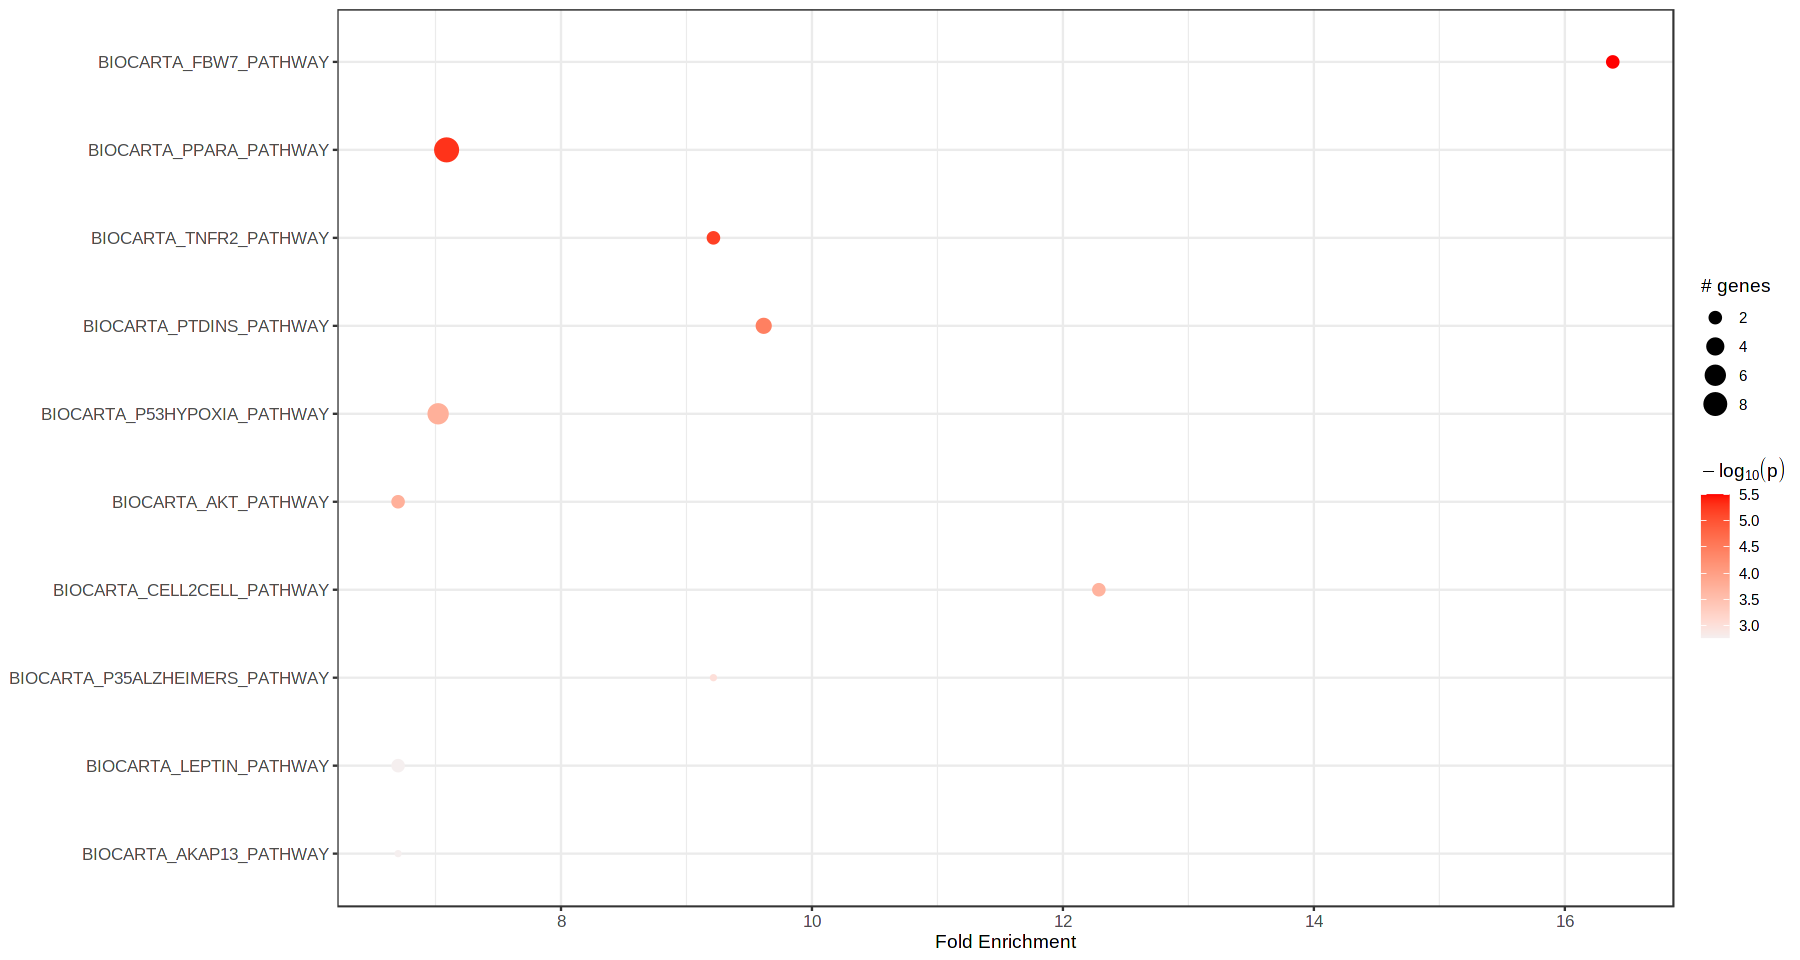

Found 39 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(26)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(27)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 297

Number of genes in input after p-value filtering: 297

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 2 (0.67%) genes in the PIN

Final number of genes in input: 295

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processin

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b29bce233.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b43a9b981.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b5b7eeaa5.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165beb57892.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b766247dd.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b718a2fb2.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



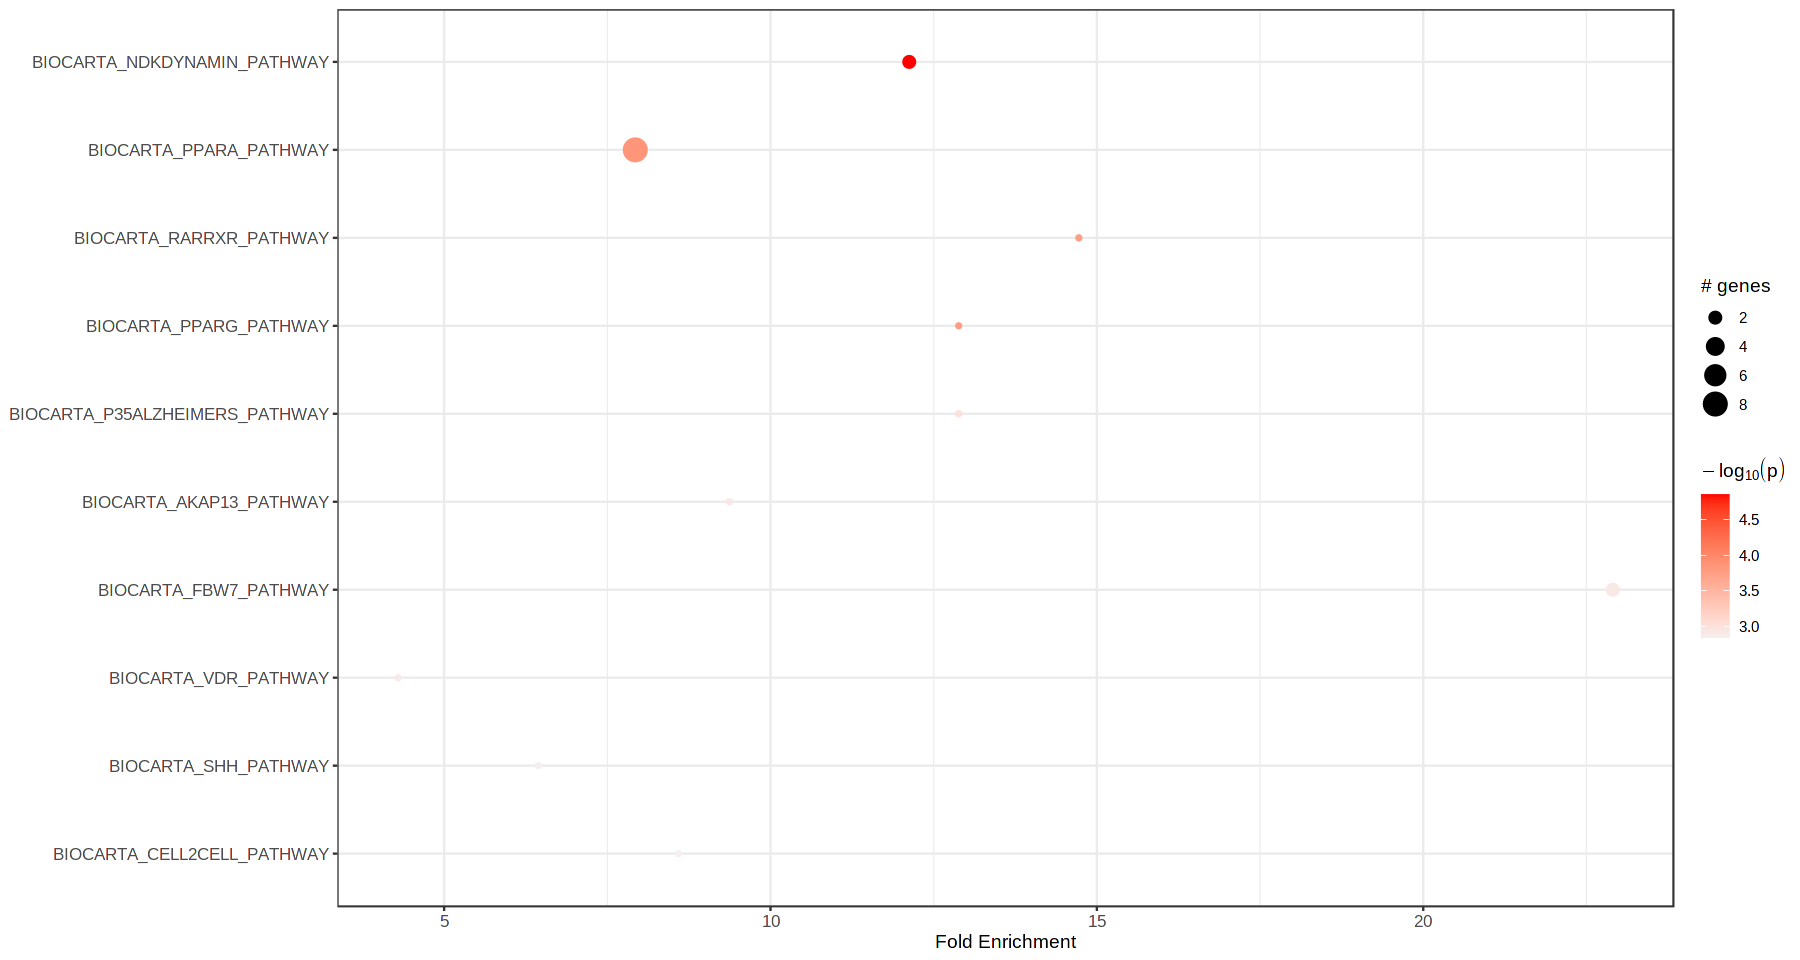

Found 90 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(27)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(27)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 213

Number of genes in input after p-value filtering: 213

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 2 (0.94%) genes in the PIN

Final number of genes in input: 211

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processin

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b72a4f539.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165bfc72aa0.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b123a3320.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b1107f801.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b35660ef5.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b5a3d4185.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



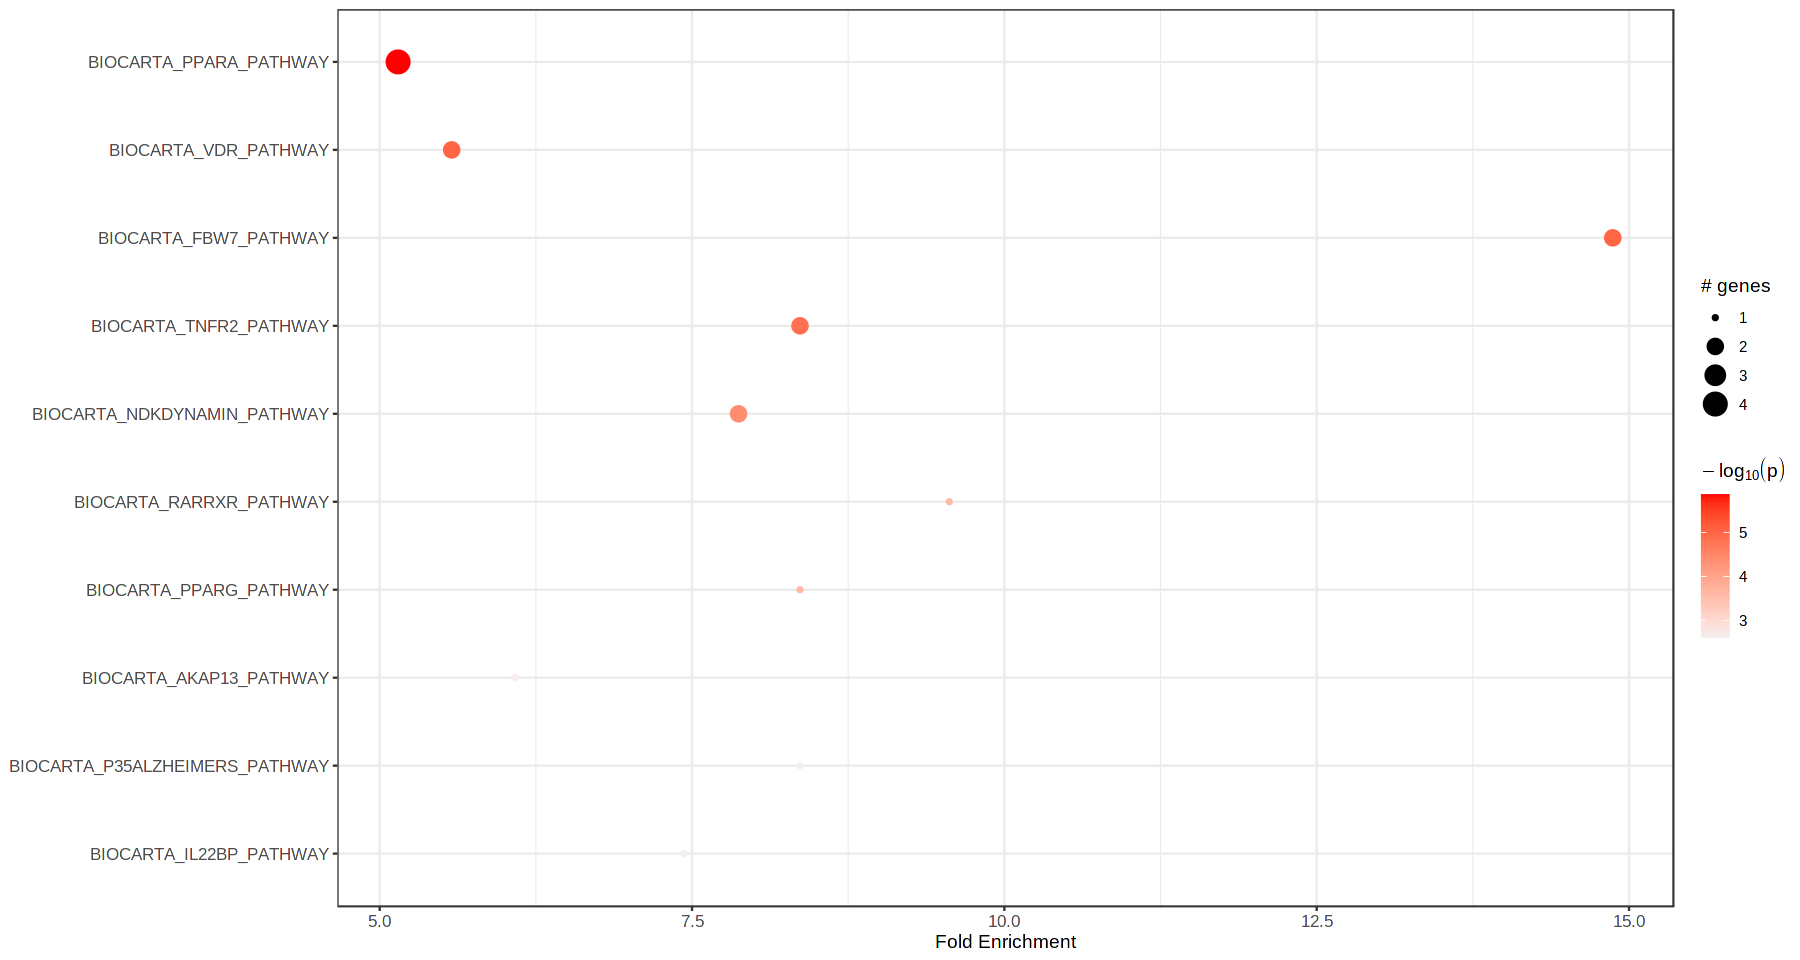

Found 74 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(27)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(27)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 330

Number of genes in input after p-value filtering: 330

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 5 (1.52%) genes in the PIN

Final number of genes in input: 325

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing 

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b5c999aea.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b25840234.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b647490eb.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b7c0b1e3e.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b396f8fe8.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b7eae058f.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



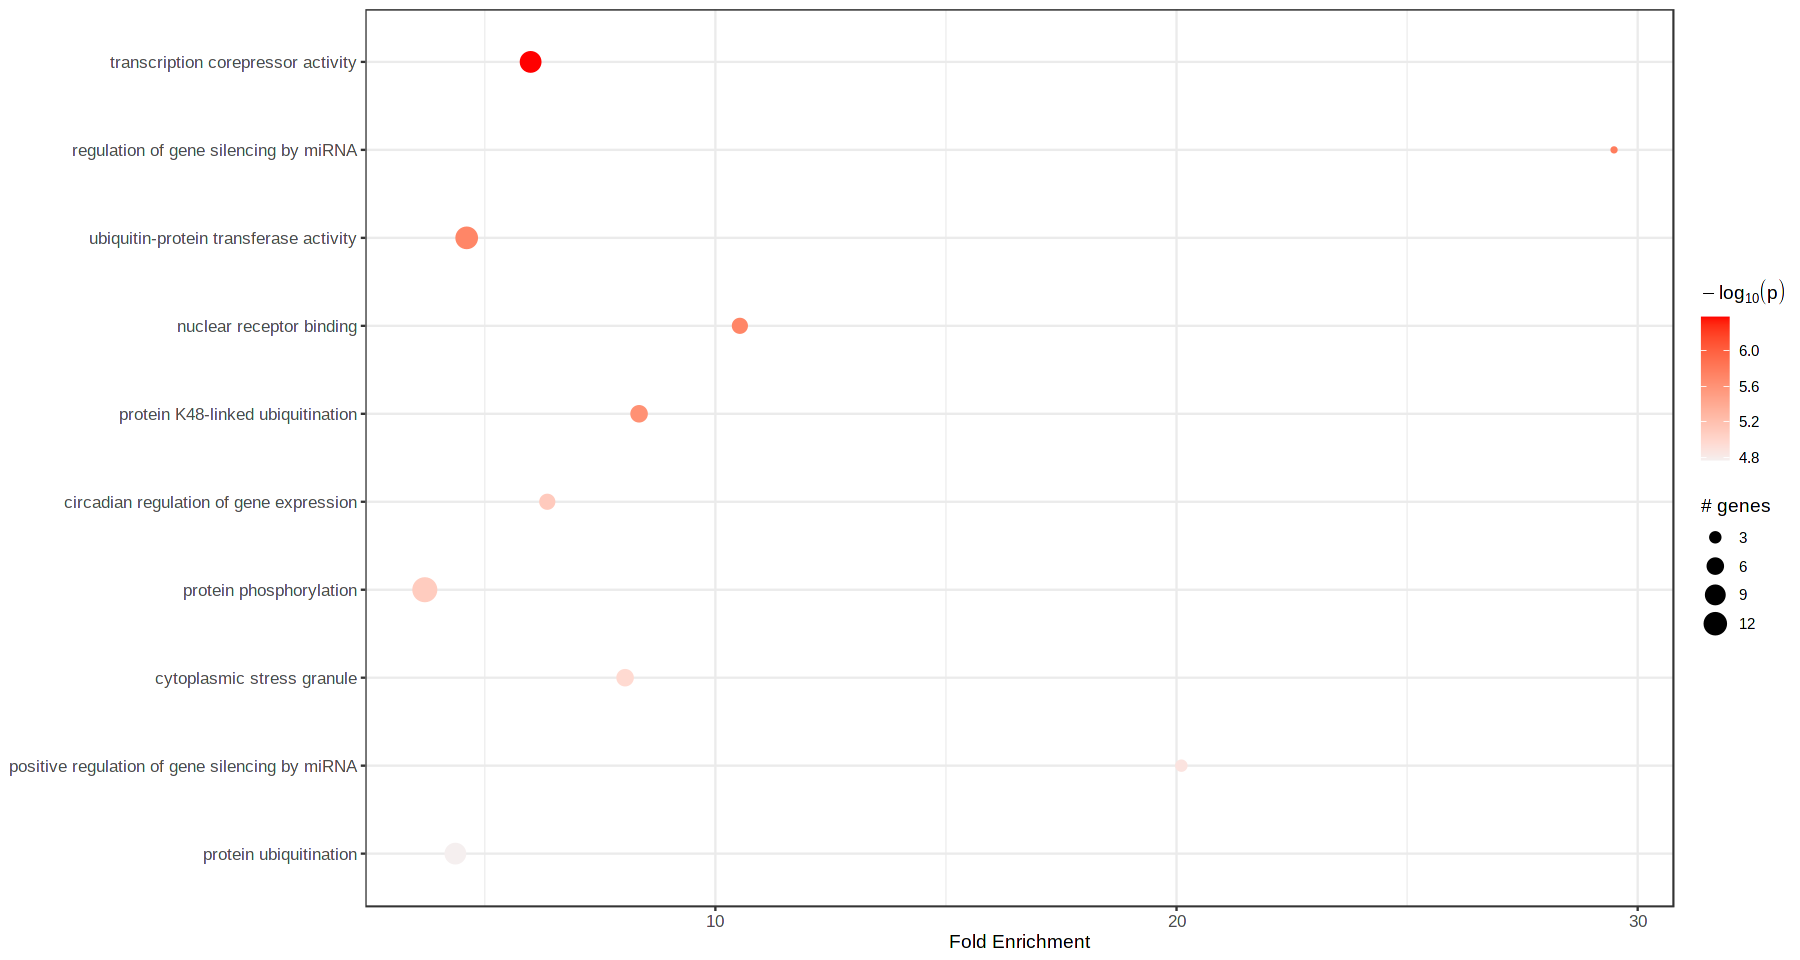

Found 104 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(27)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(28)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 135

Number of genes in input after p-value filtering: 135

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 6 (4.44%) genes in the PIN

Final number of genes in input: 129

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processin

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b4d0f61e2.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b148ff854.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b6feef2ca.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b23aa9506.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b40c8ebf8.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b725ced61.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



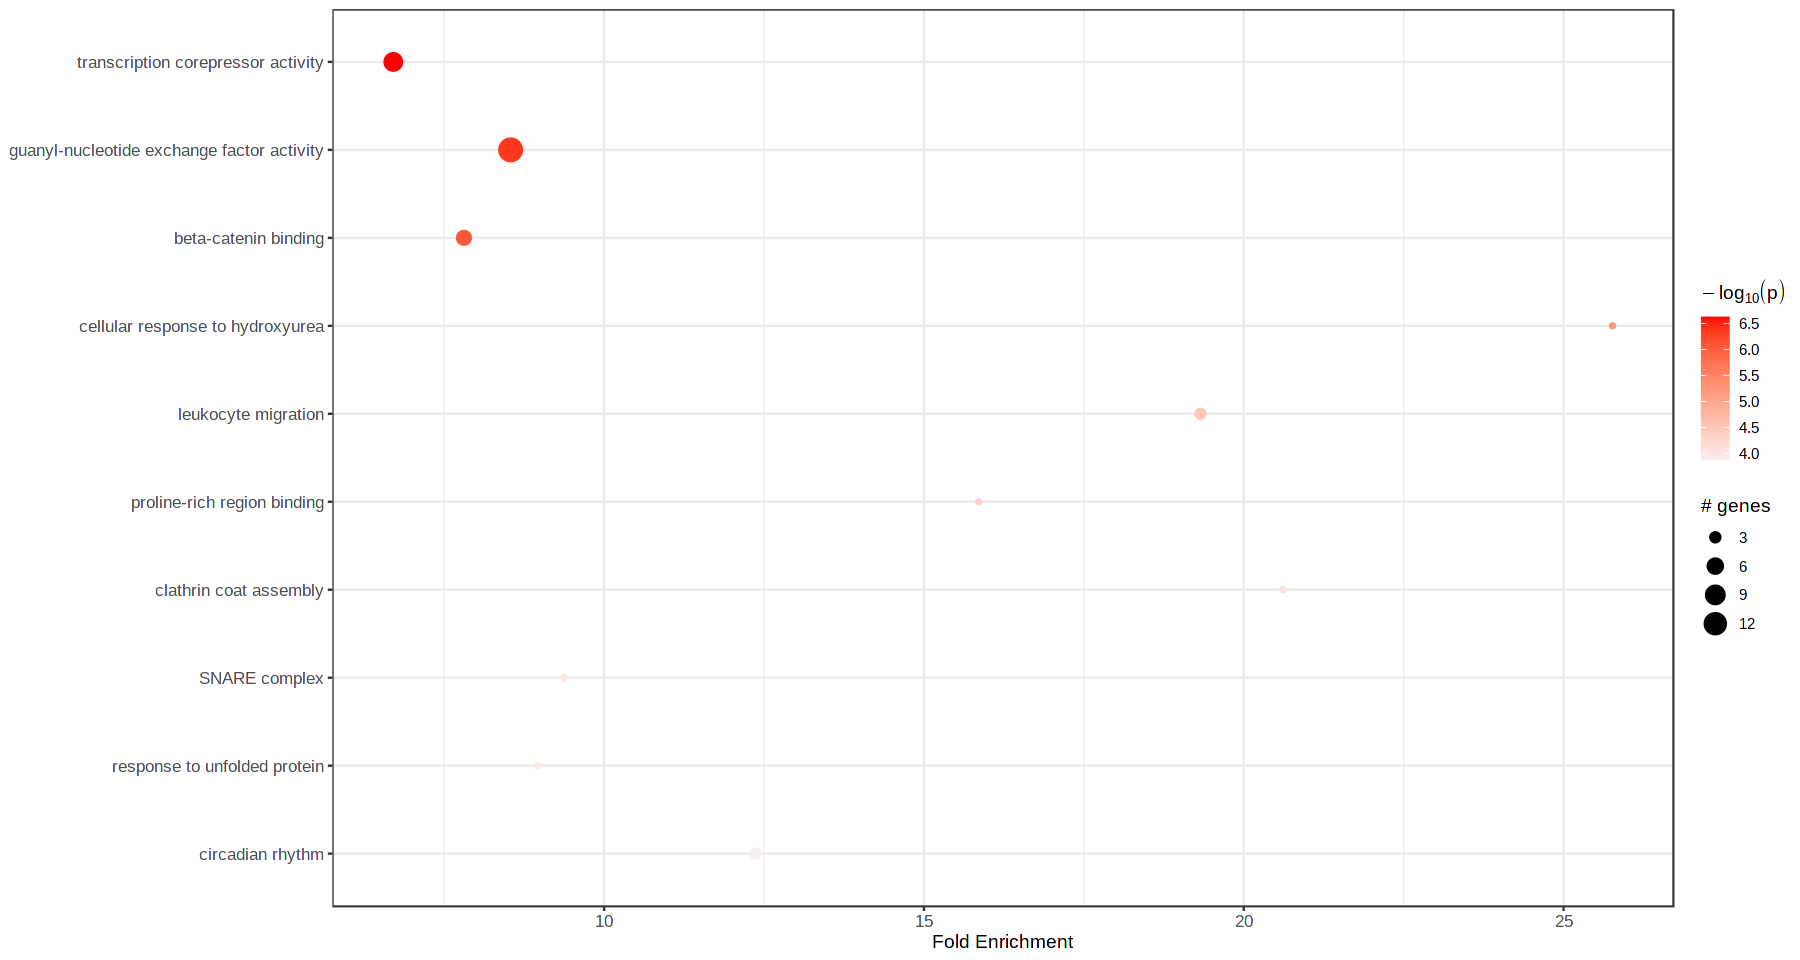

Found 133 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(28)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(28)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 71

Number of genes in input after p-value filtering: 71

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 7 (9.86%) genes in the PIN

Final number of genes in input: 64

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing f

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b11d3bb58.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b259b66af.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b3813871f.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b6b3275da.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b7c6e409c.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b24bda2de.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



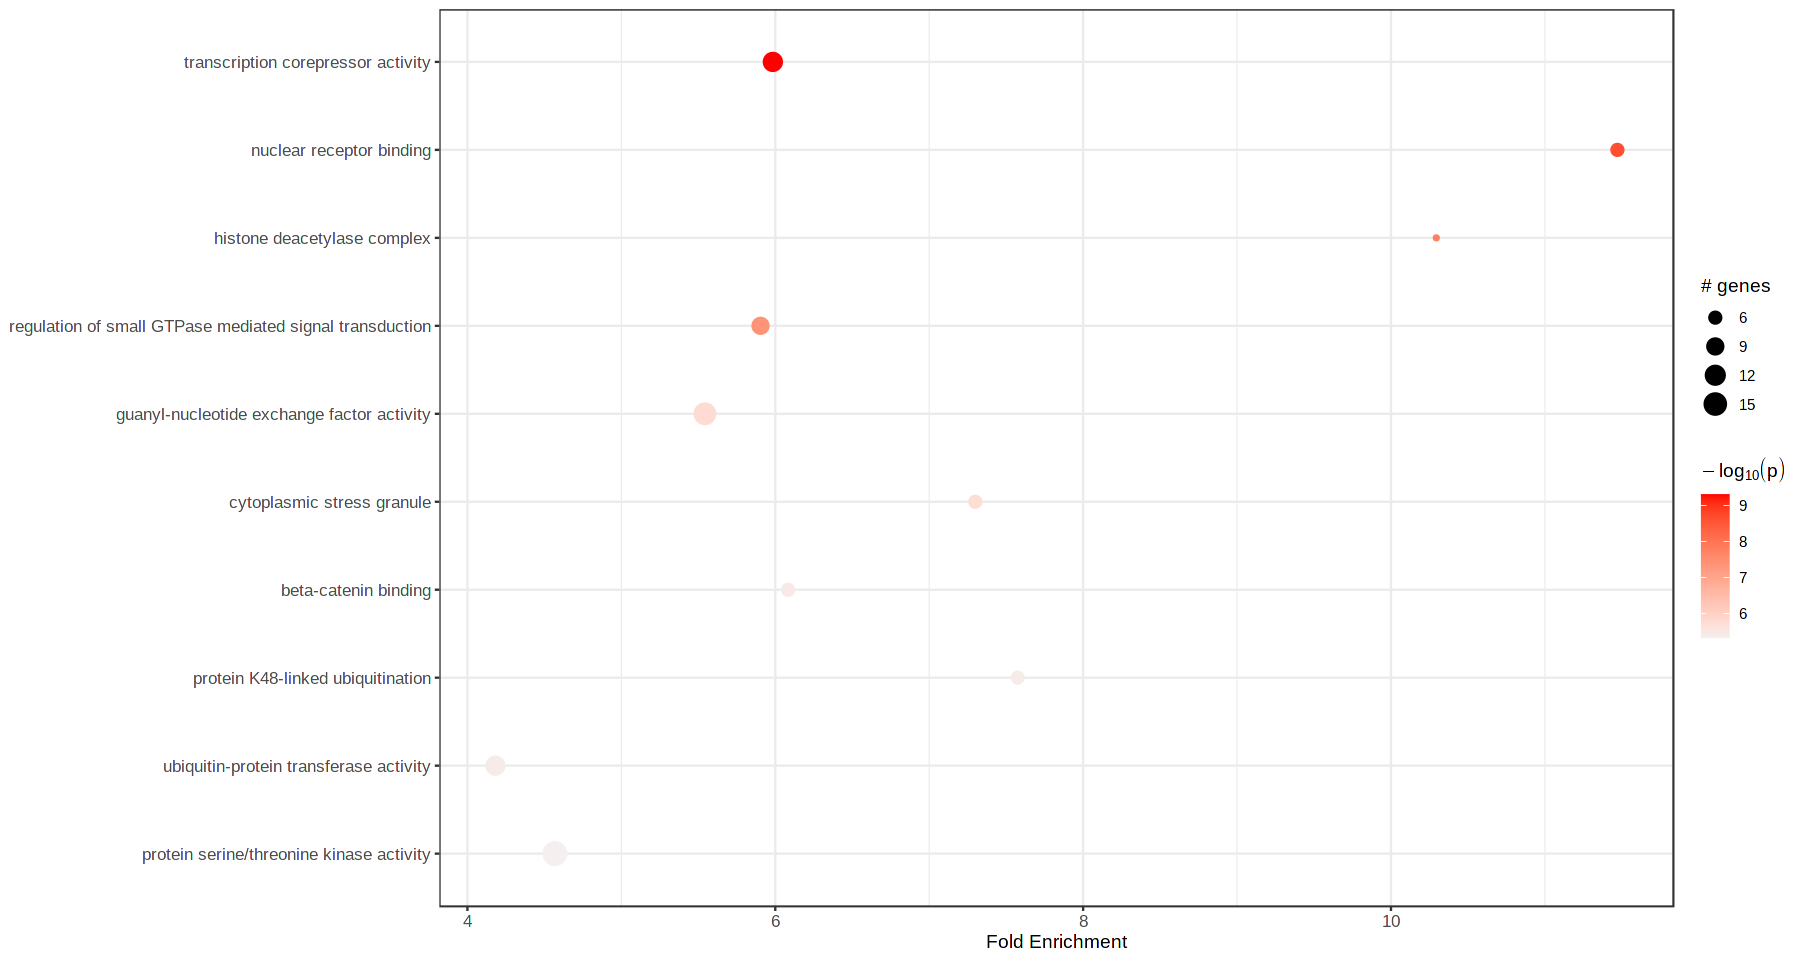

Found 72 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(28)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(28)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 118

Number of genes in input after p-value filtering: 118

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 3 (2.54%) genes in the PIN

Final number of genes in input: 115

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing 

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b7ba6002b.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b47bdebc3.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b22f1ab6.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b4fb42c1e.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b358e75e4.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b346b1da1.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



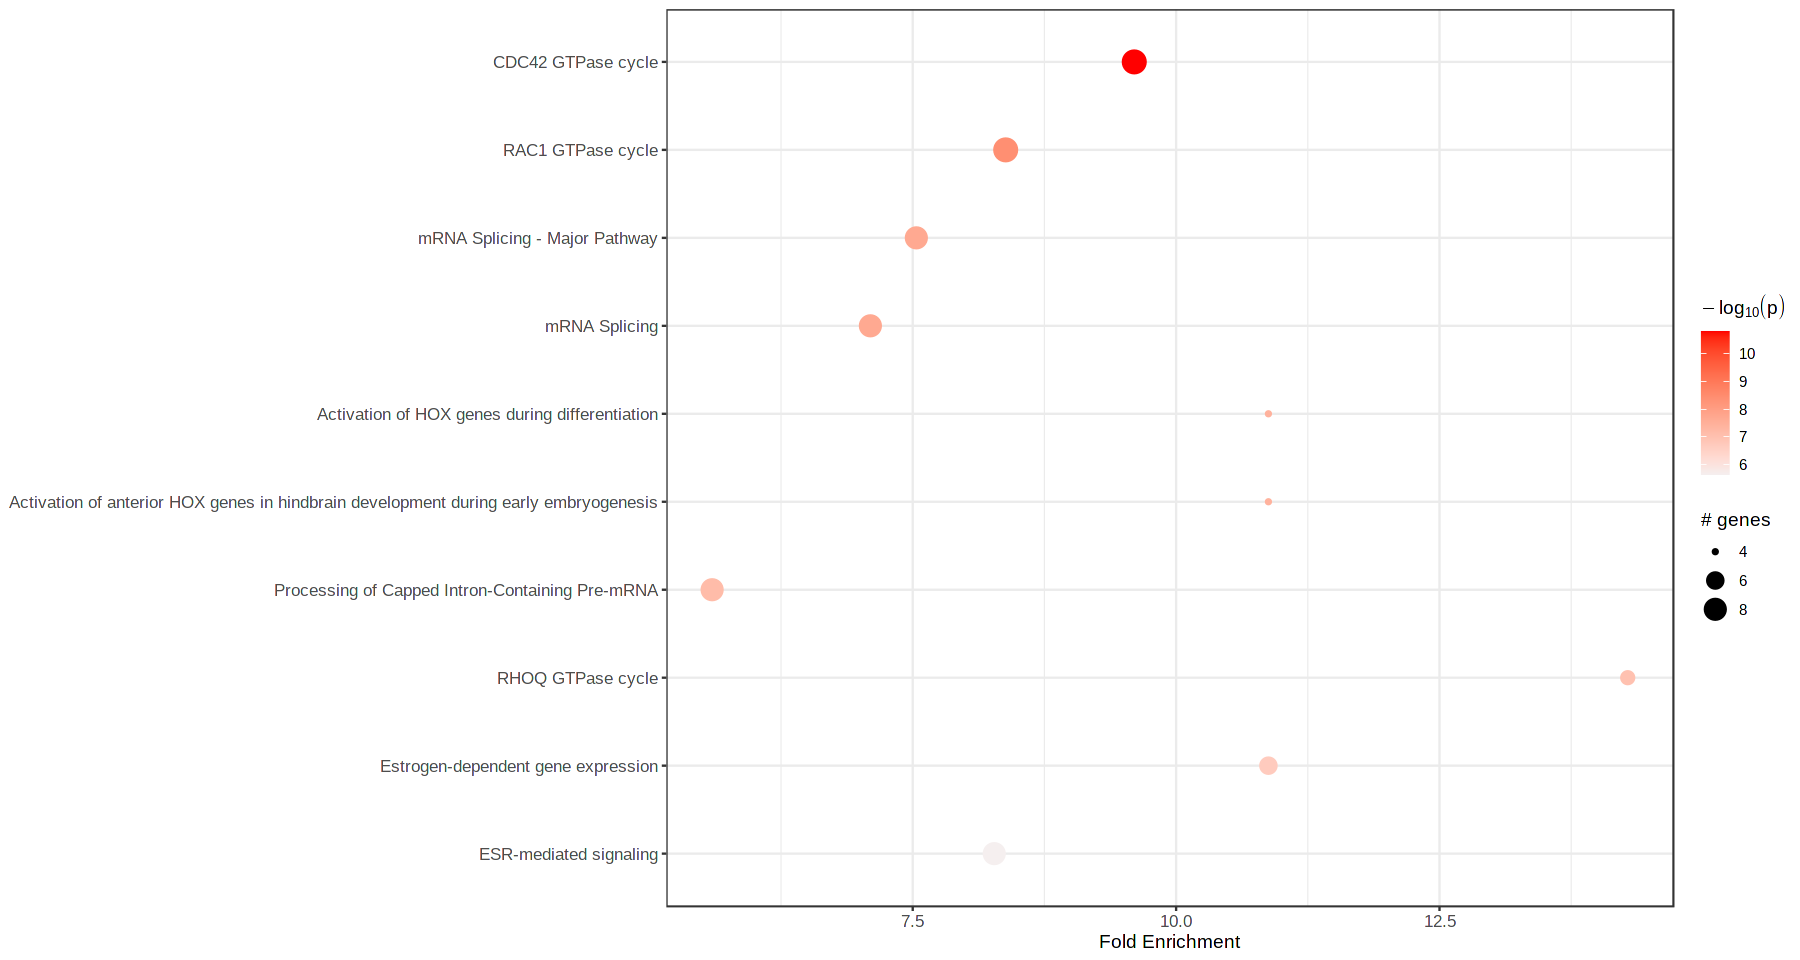

Found 239 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(28)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(29)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 135

Number of genes in input after p-value filtering: 135

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 6 (4.44%) genes in the PIN

Final number of genes in input: 129

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processin

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b7fc46c41.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b31439328.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b116057b7.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165ba4662fd.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b37f43911.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b1761d74f.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



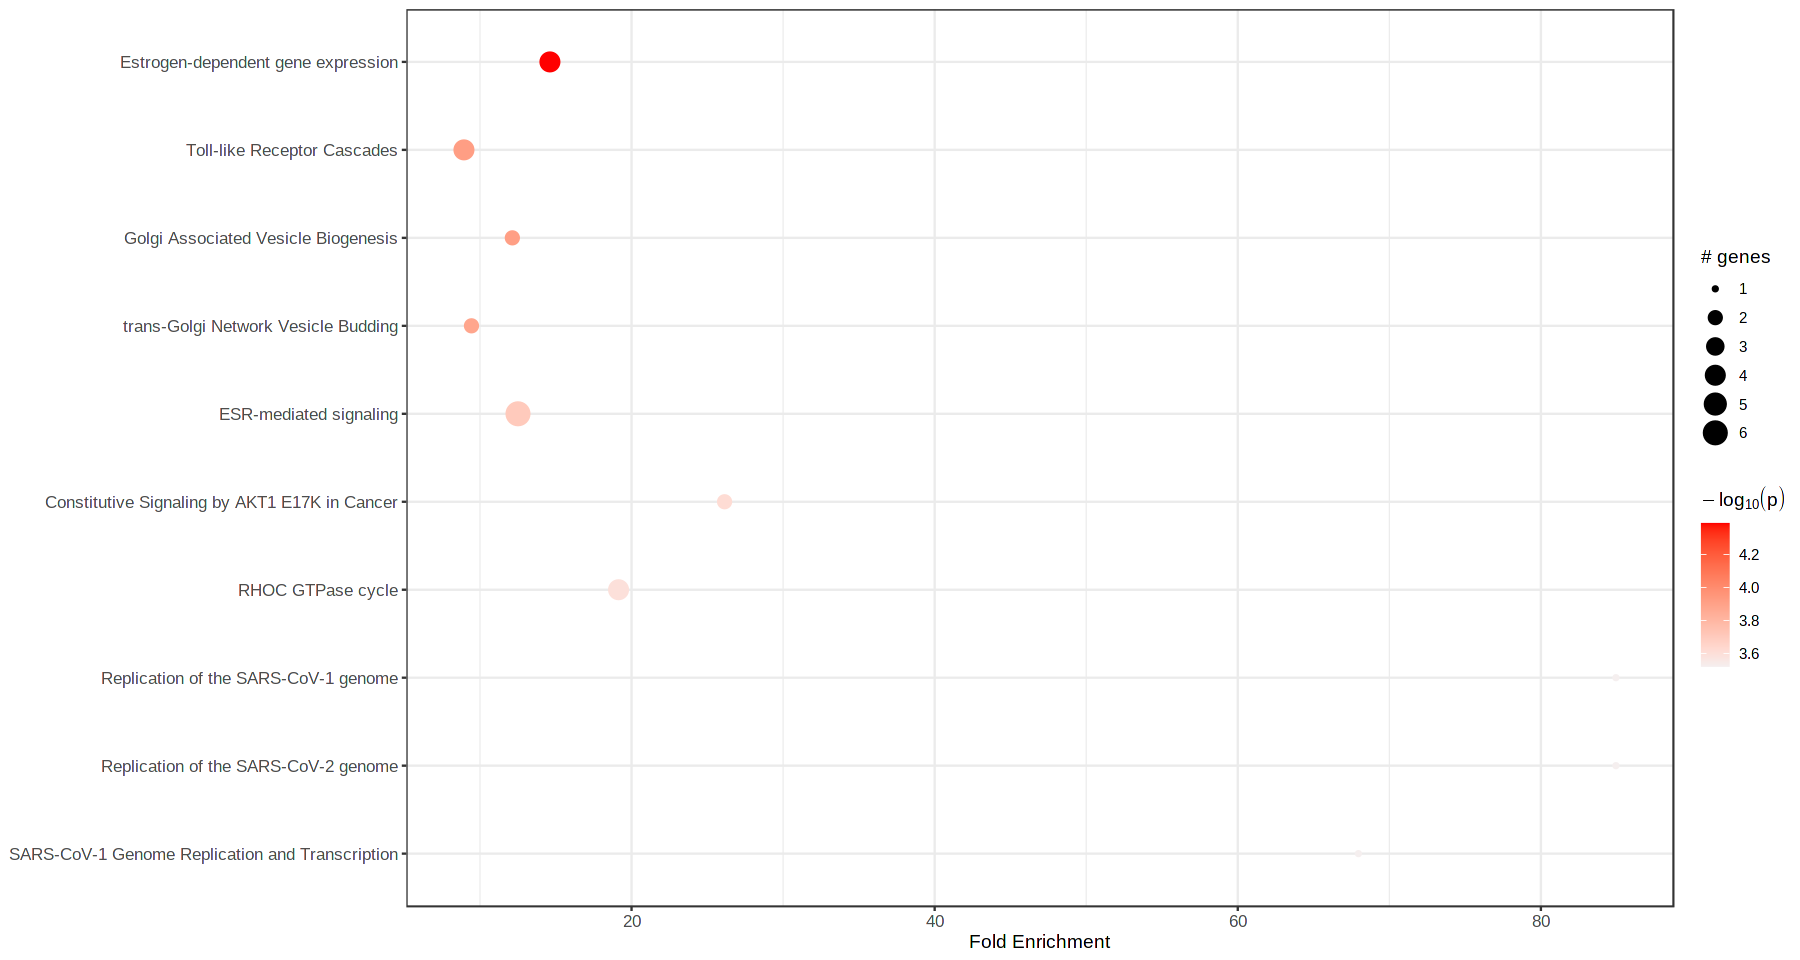

Found 81 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(29)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(29)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 71

Number of genes in input after p-value filtering: 71

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 7 (9.86%) genes in the PIN

Final number of genes in input: 64

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing f

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b31487914.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b5154f755.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b2ae714a3.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b13867473.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b35f4930c.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b4ec1f97c.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



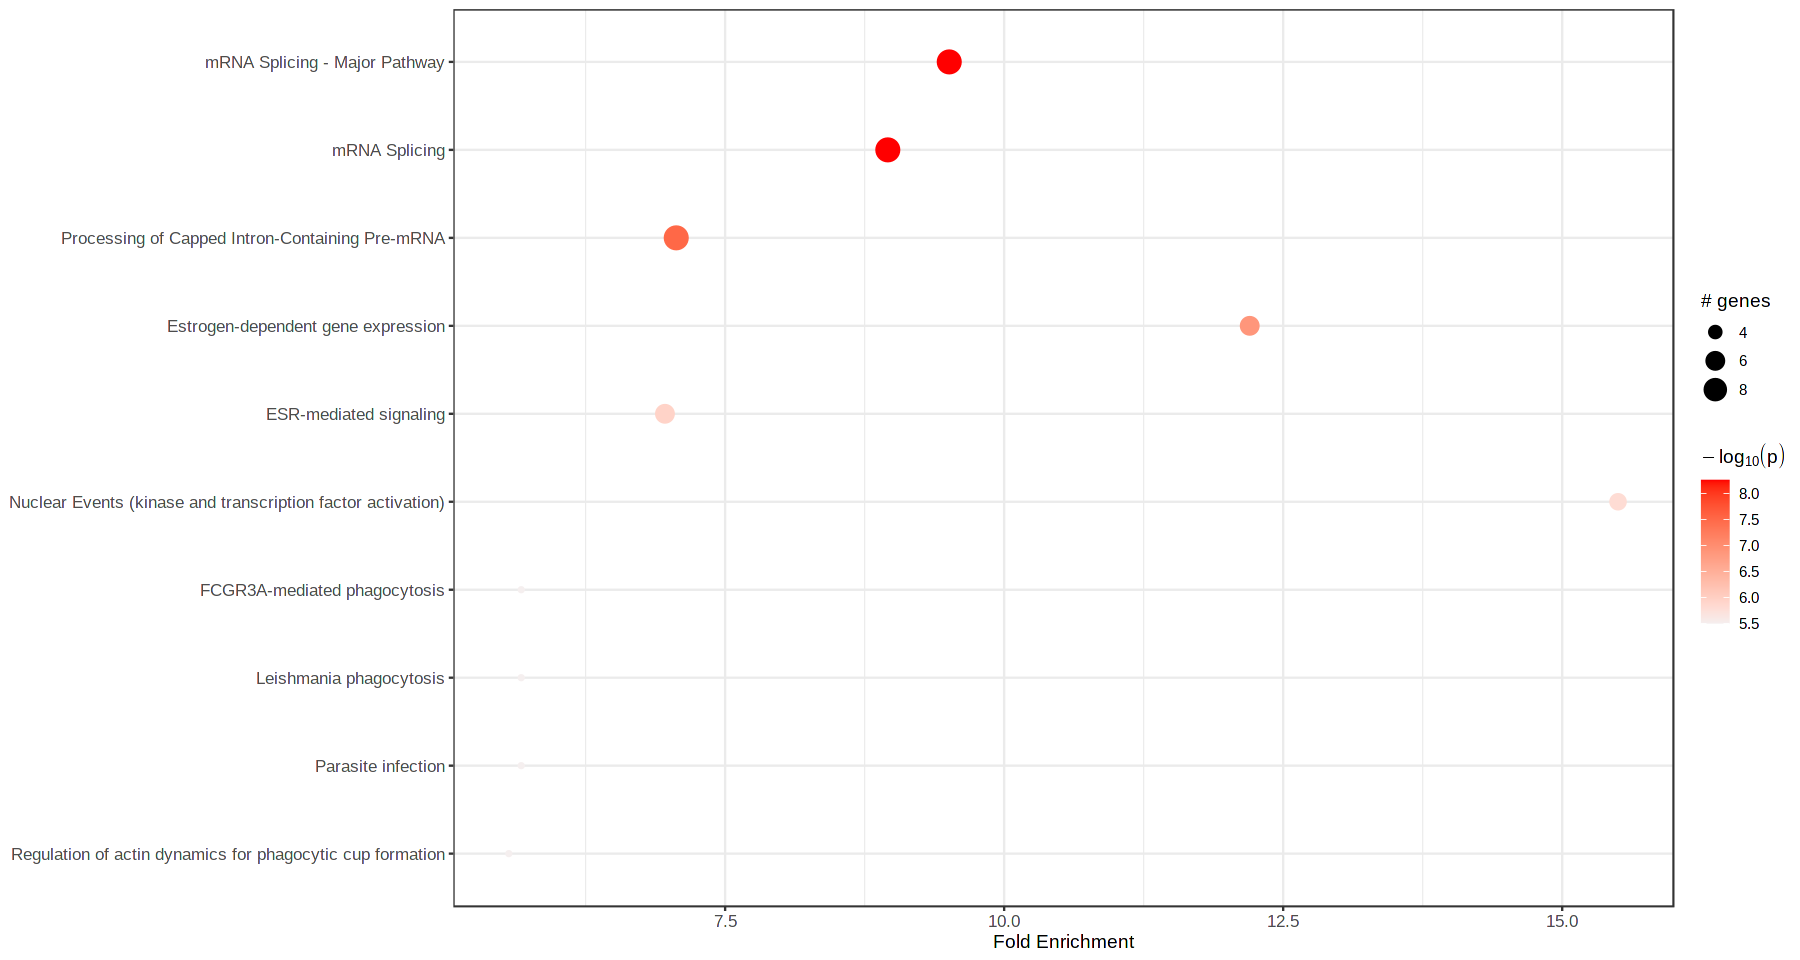

Found 74 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(29)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(29)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 118

Number of genes in input after p-value filtering: 118

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 3 (2.54%) genes in the PIN

Final number of genes in input: 115

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing 

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b4017cf95.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165bdff2594.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b4239df4e.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b3781dc31.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b42e9f0c1.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b432784f9.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



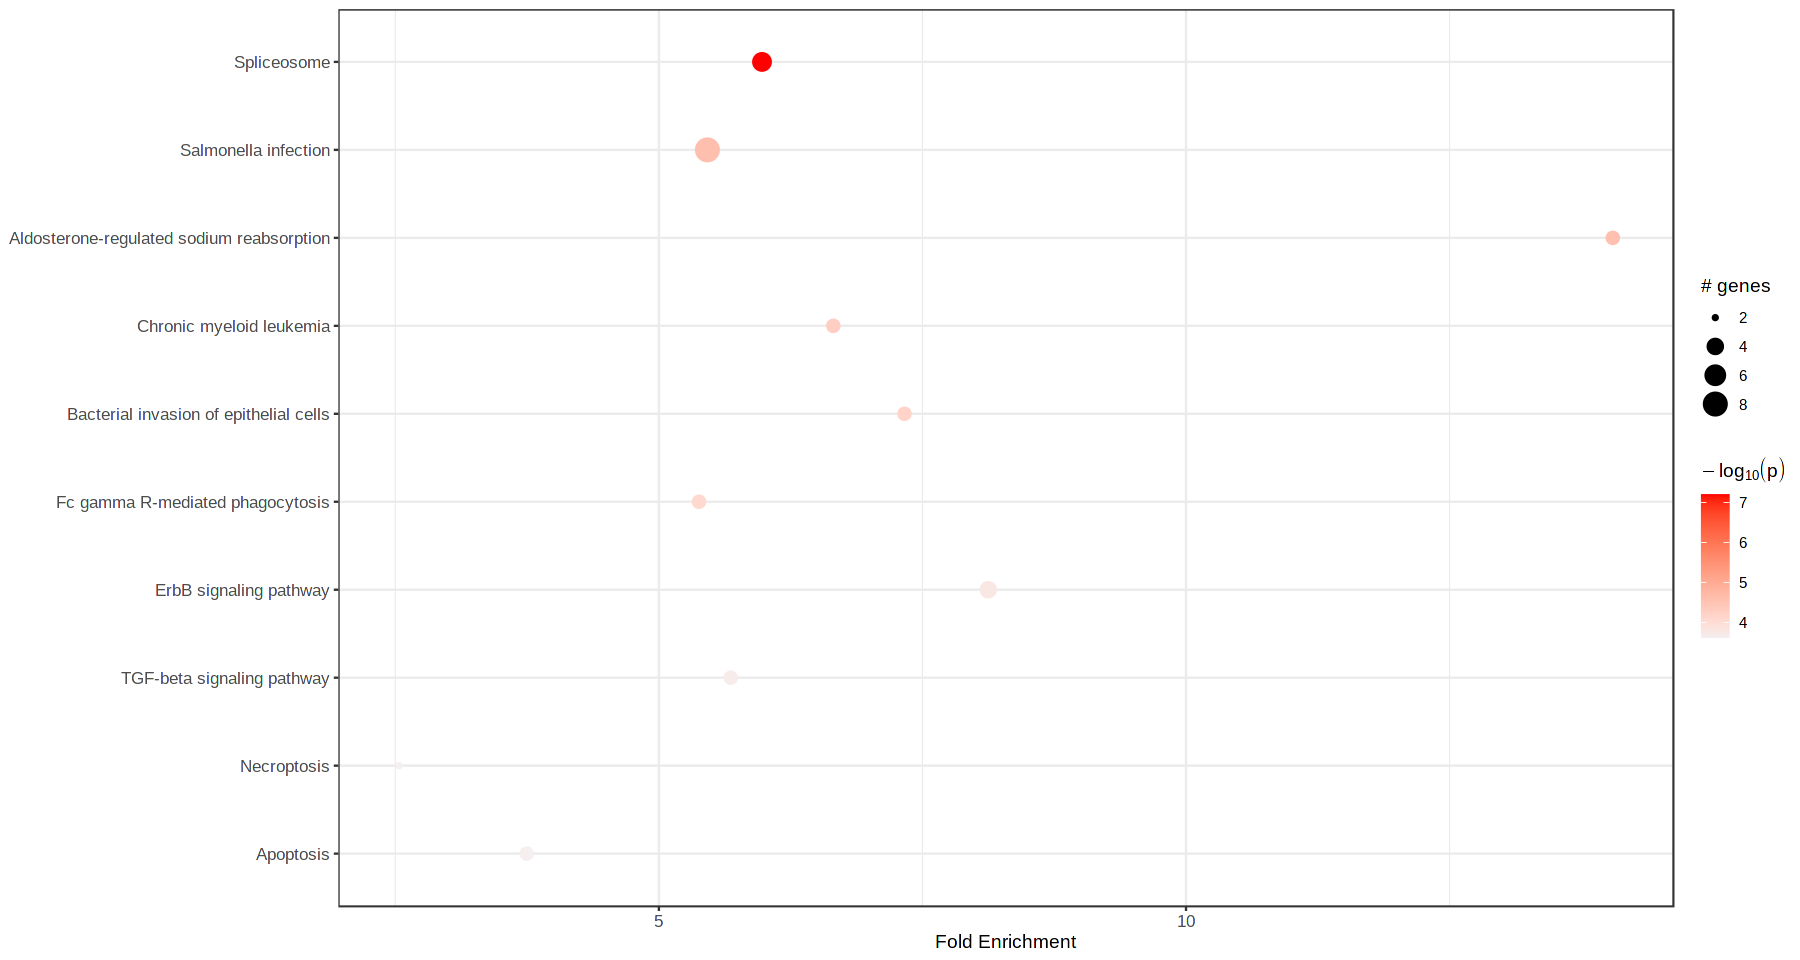

Found 77 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(29)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(30)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 135

Number of genes in input after p-value filtering: 135

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 6 (4.44%) genes in the PIN

Final number of genes in input: 129

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processin

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b355cb412.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b4dc8f612.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b78c55d05.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b4787ab12.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b28d75c51.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b36a29309.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



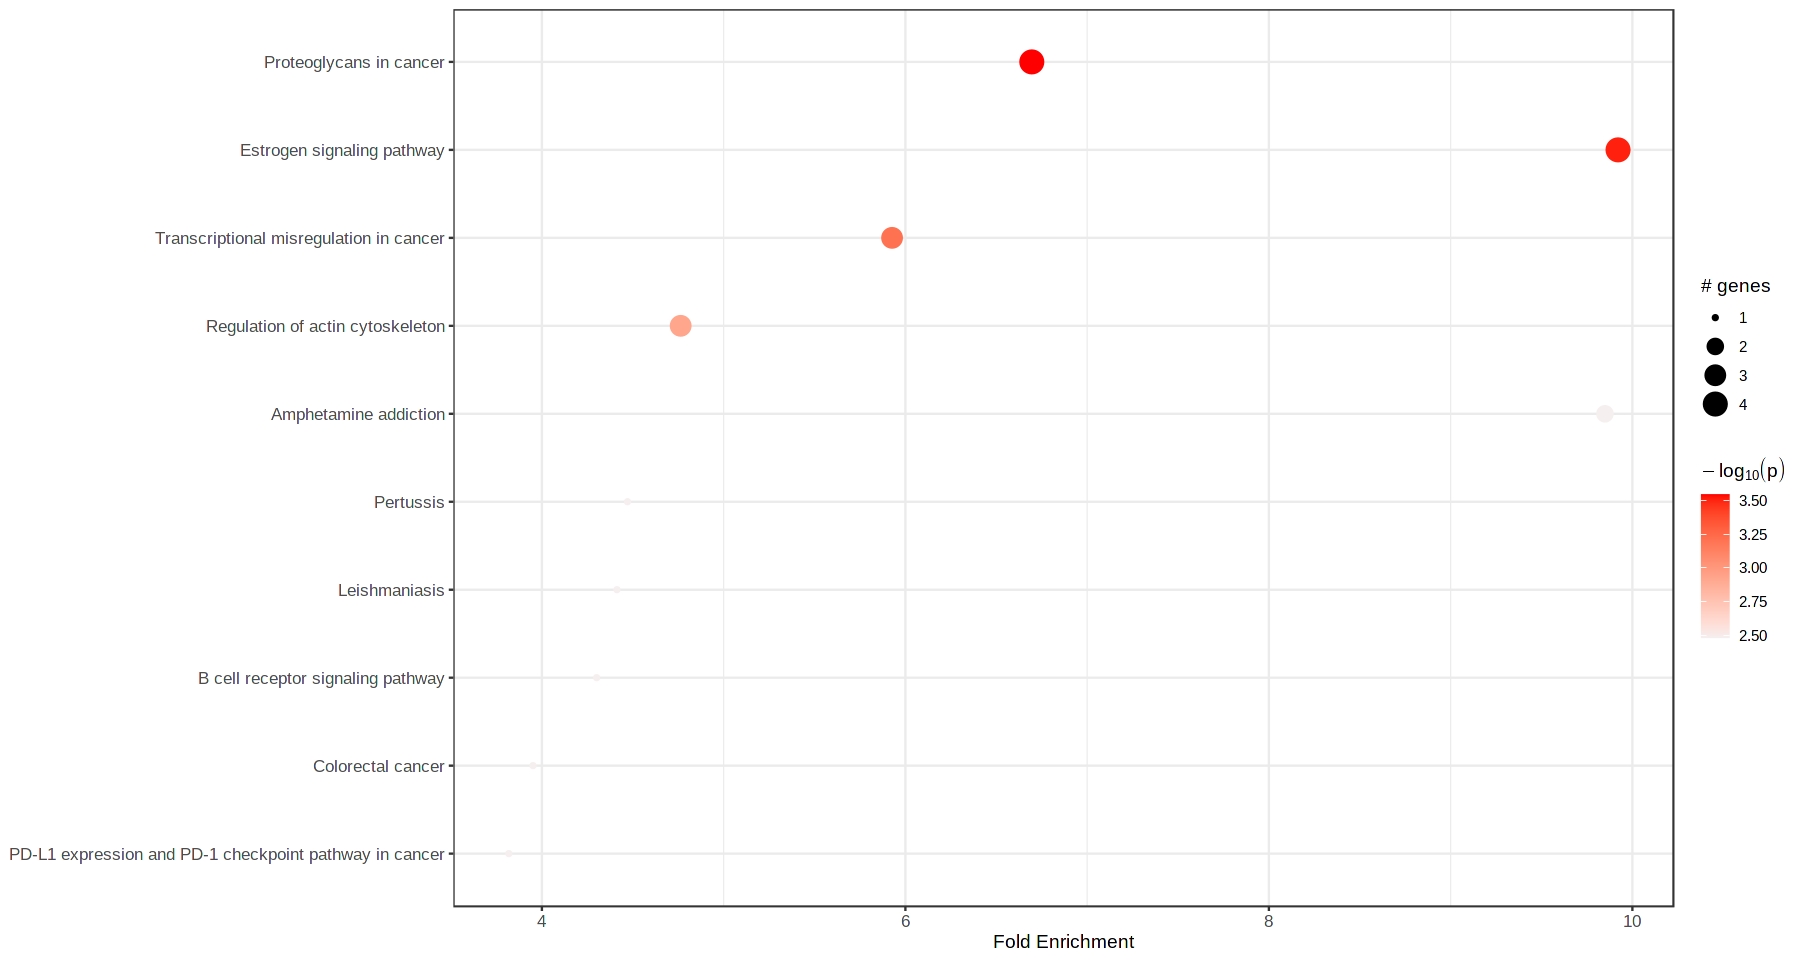

Found 47 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(30)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(30)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 71

Number of genes in input after p-value filtering: 71

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 7 (9.86%) genes in the PIN

Final number of genes in input: 64

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing f

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b7331fcc5.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b15c9fa2b.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b11bd26bc.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b8a5a19d.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b369bcd69.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b57419fb6.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



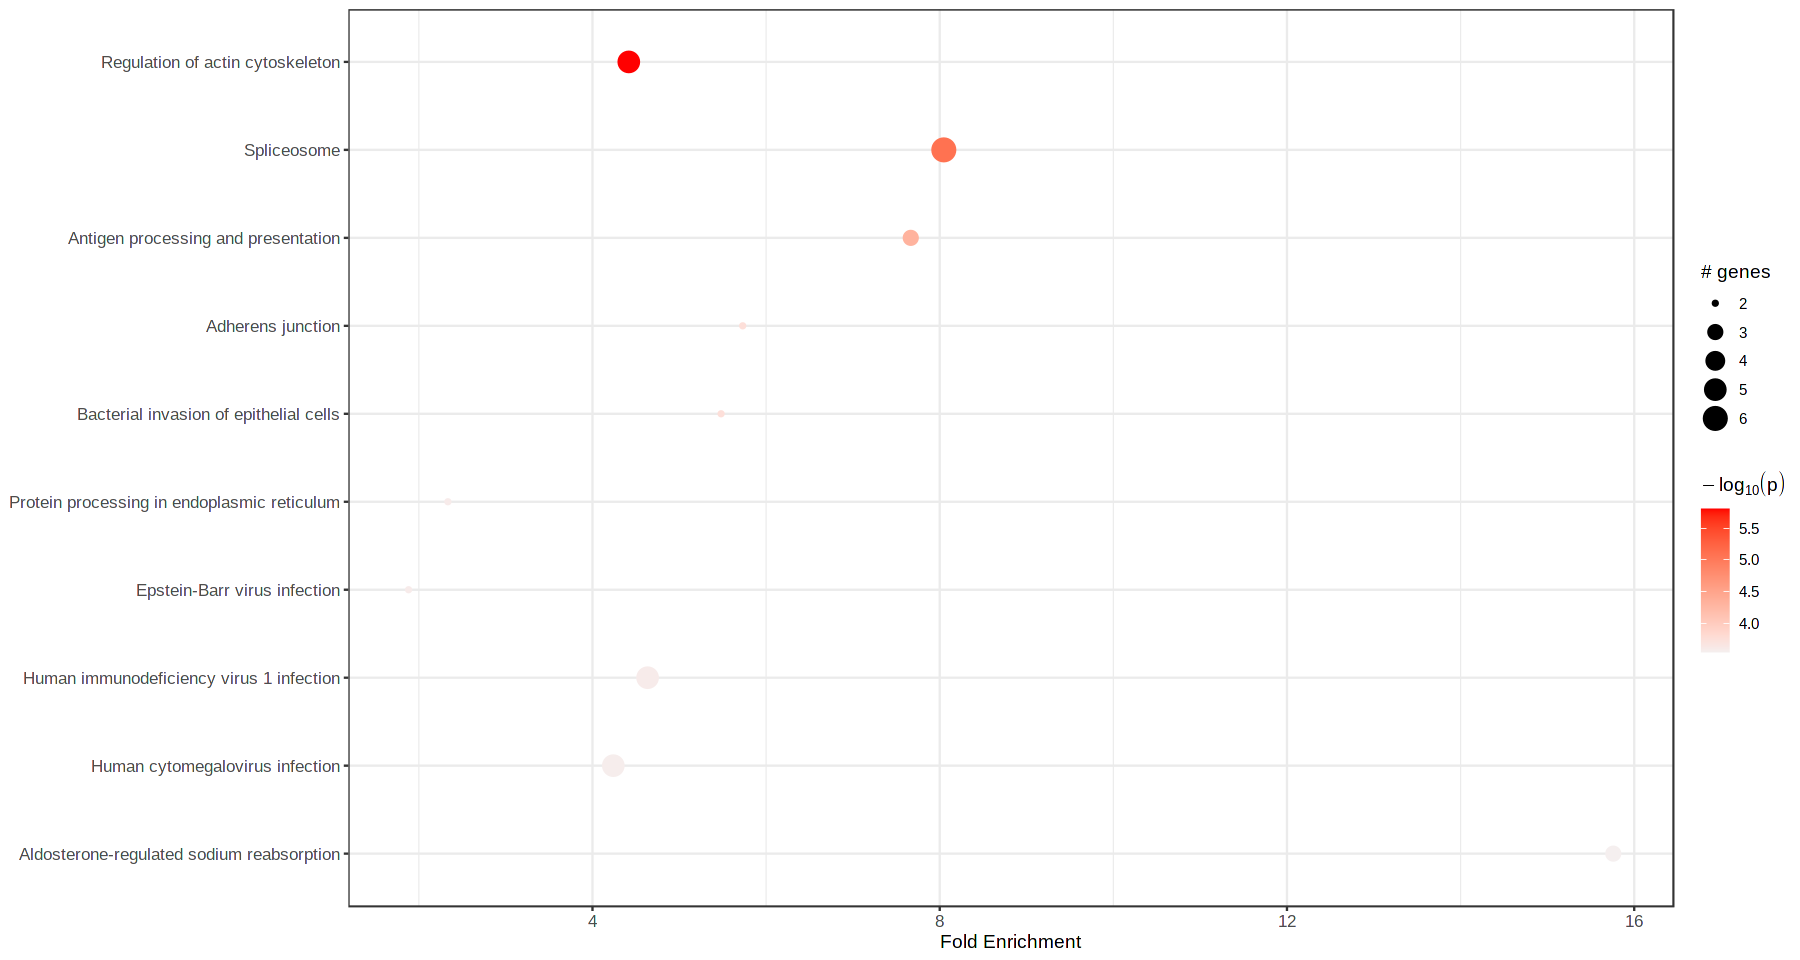

Found 46 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(30)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(30)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 118

Number of genes in input after p-value filtering: 118

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 3 (2.54%) genes in the PIN

Final number of genes in input: 115

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing 

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b654e4e4a.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b62a77af0.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b52416955.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b544c92b0.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b354afddc.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b29a6cf49.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



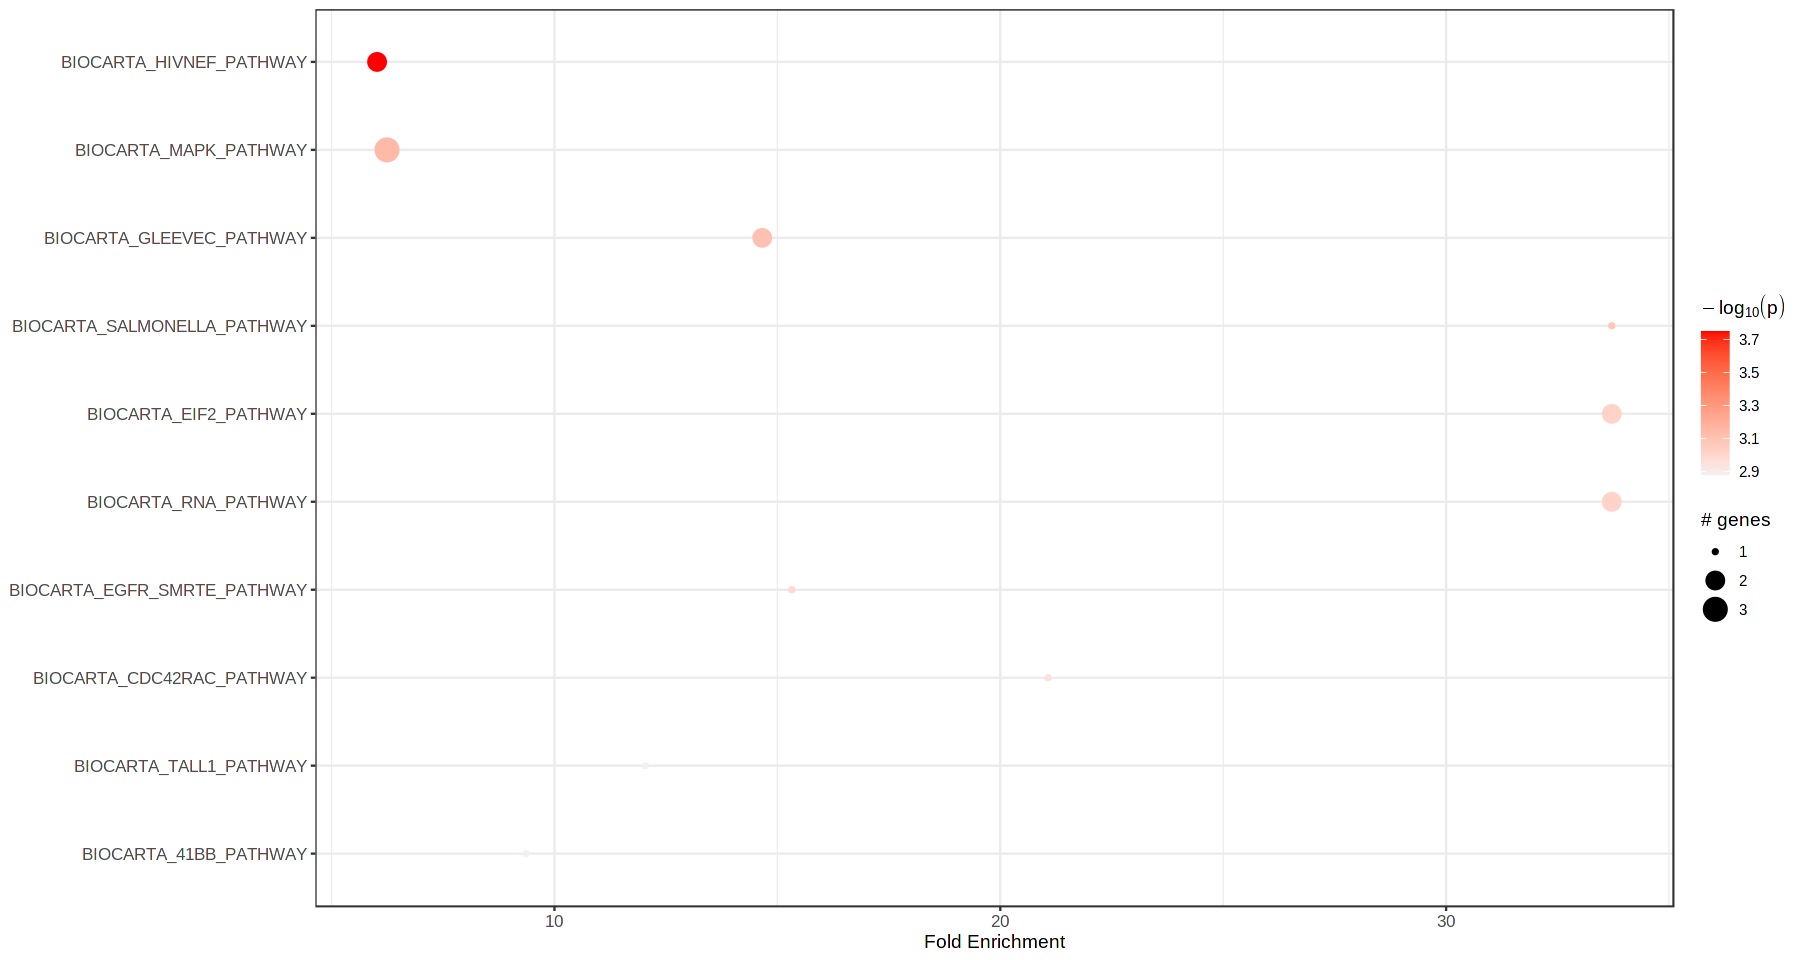

Found 38 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(30)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  lung ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(31)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 135

Number of genes in input after p-value filtering: 135

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 6 (4.44%) genes in the PIN

Final number of genes in input: 129

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processin

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b66ca015d.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b71e3319d.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b56d3856d.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b32239ca6.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b6f5f9555.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b61648166.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



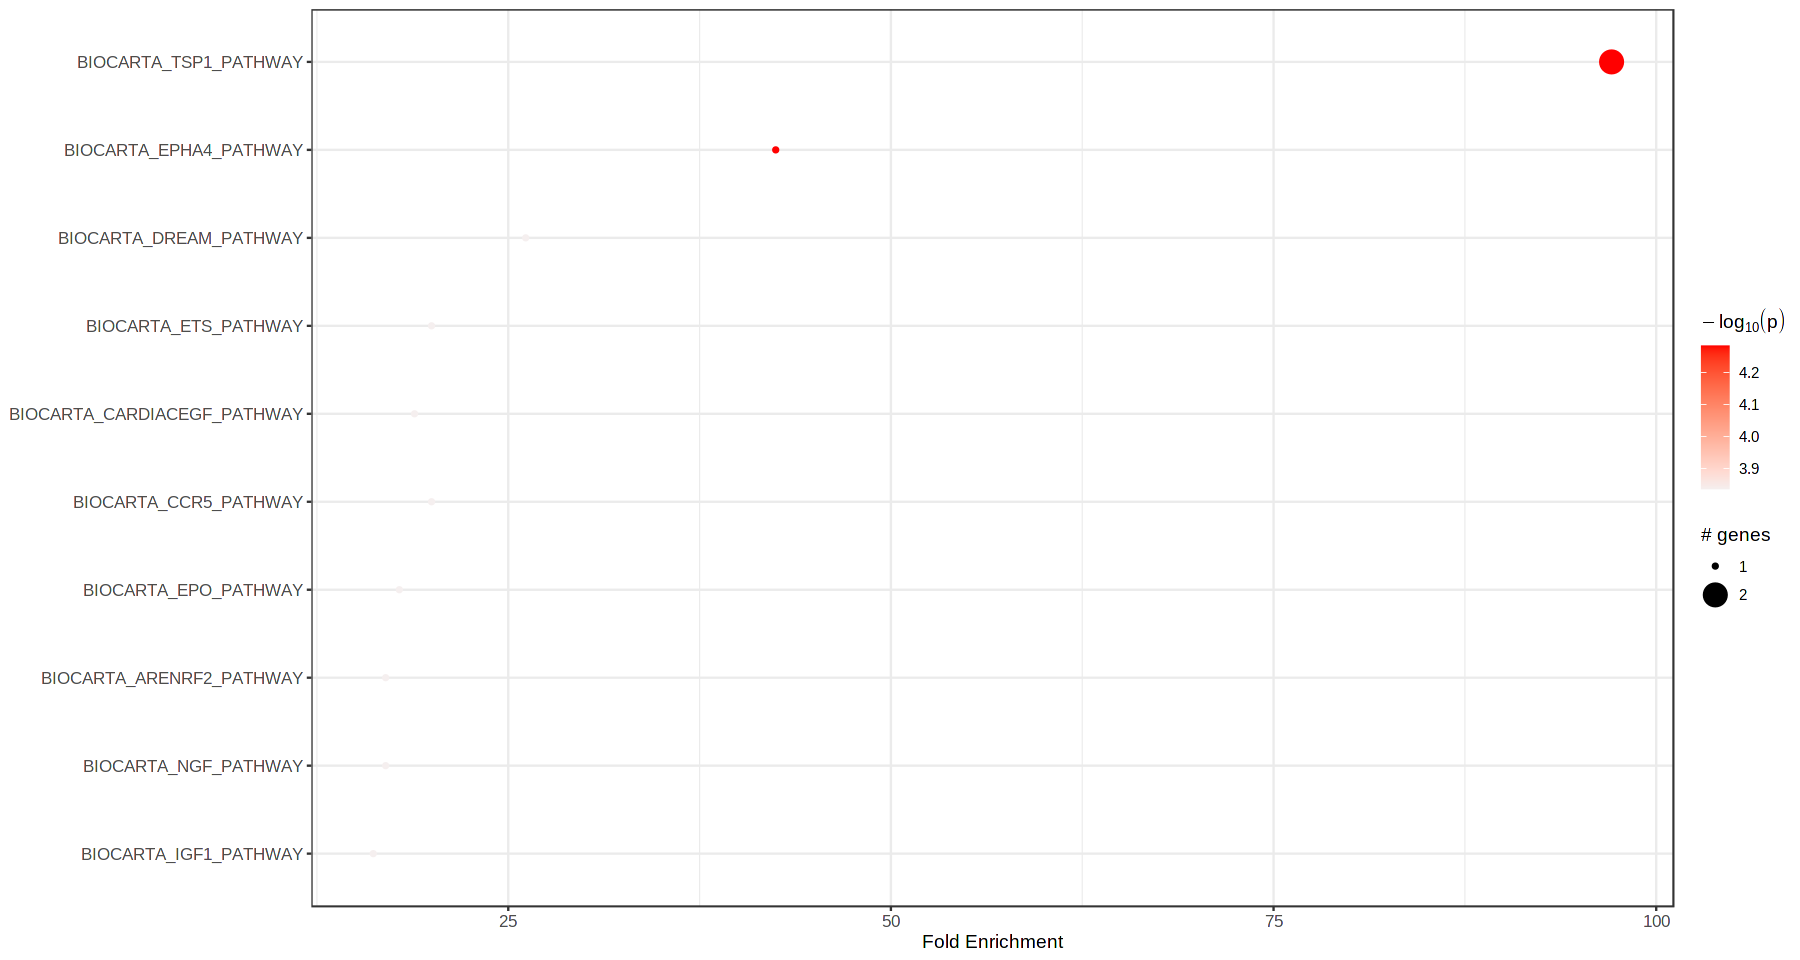

Found 58 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/liver/endothelial(31)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  liver ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(31)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 71

Number of genes in input after p-value filtering: 71

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 7 (9.86%) genes in the PIN

Final number of genes in input: 64

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing f

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b2e425de2.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b7710804.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b573e09d6.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b177189b.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b12bed6f.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b555f240a.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



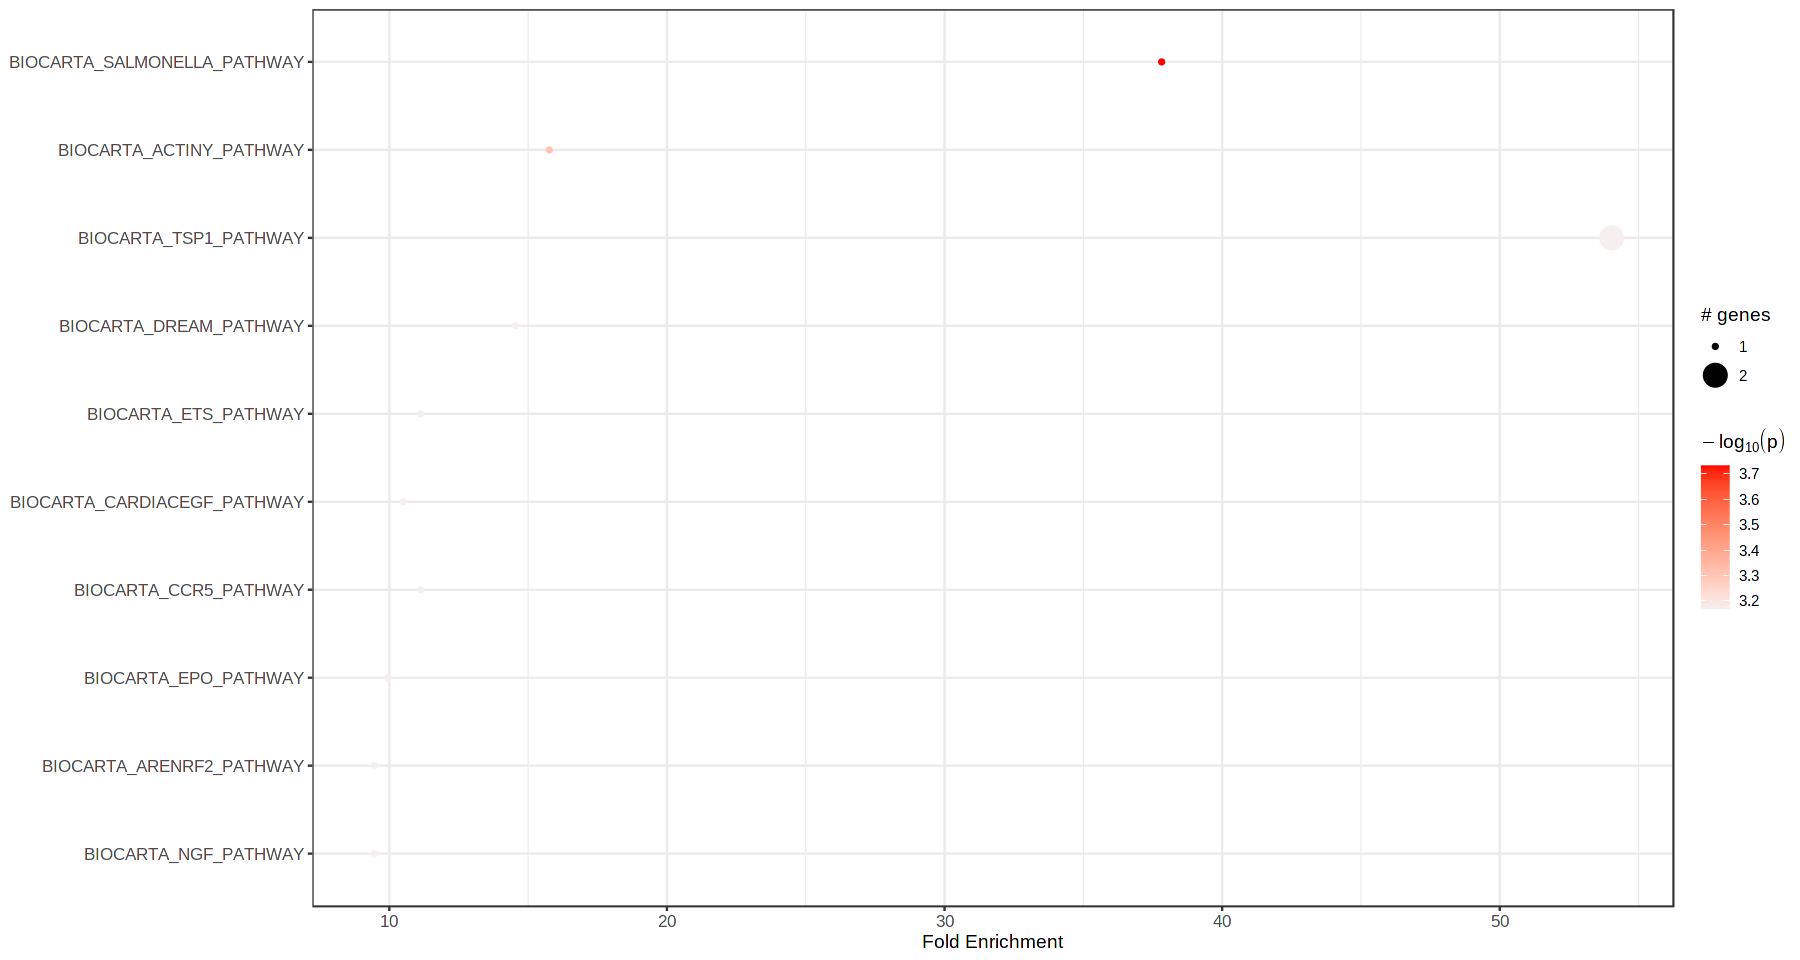

Found 33 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/heart/endothelial(31)"


Run cluster_enriched_terms() for clustering enriched terms





[1] "Done cell type  heart ...  endothelial"


`n_processes` is set to `iterations` because `iterations` < `n_processes`

There is already a directory named "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial/".
Writing the result to "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(31)" not to overwrite any previous results.

## Testing input

The input looks OK

## Processing input. Converting gene symbols,
          if necessary (and if human gene symbols provided)

Number of genes provided in input: 118

Number of genes in input after p-value filtering: 118

pathfindR cannot handle p values < 1e-13. These were changed to 1e-13

Could not find any interactions for 3 (2.54%) genes in the PIN

Final number of genes in input: 115

## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations

## Annotating involved genes and visualizing enriched terms

## Creating HTML report



processing 

  |.......................                                               |  33%
   inline R code fragments

  |...............................................                       |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................................................................| 100%
  ordinary text without R code




output file: results.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS results.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b794a0406.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b65353a68.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html



processing file: enriched_terms.Rmd



  |..................                                                    |  25%
   inline R code fragments

  |...................................                                   |  50%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................................................                  |  75%
  ordinary text without R code

  |......................................................................| 100%
label: table (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: enriched_terms.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS enriched_terms.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b7fe3a4a0.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165b296af713.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_terms.html



processing file: conversion_table.Rmd



  |............                                                          |  17%
   inline R code fragments

  |.......................                                               |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |...................................                                   |  50%
  ordinary text without R code

  |...............................................                       |  67%
label: converted_tbl, table1 (with options) 
List of 1
 $ comment: logi NA

  |..........................................................            |  83%
  ordinary text without R code

  |......................................................................| 100%
label: gene_wo_interaction, table2 (with options) 
List of 1
 $ comment: logi NA




output file: conversion_table.knit.md




/data/alejandro/miniconda3/envs/scanpy/bin/pandoc +RTS -K512m -RTS conversion_table.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc165b2e02b1a7.html --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --variable bs3=TRUE --standalone --section-divs --template /data/alejandro/R/x86_64-pc-linux-gnu-library/4.1/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --include-in-header /tmp/Rtmp1kxa5d/rmarkdown-str165bfc64900.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html

Plotting the enrichment bubble chart



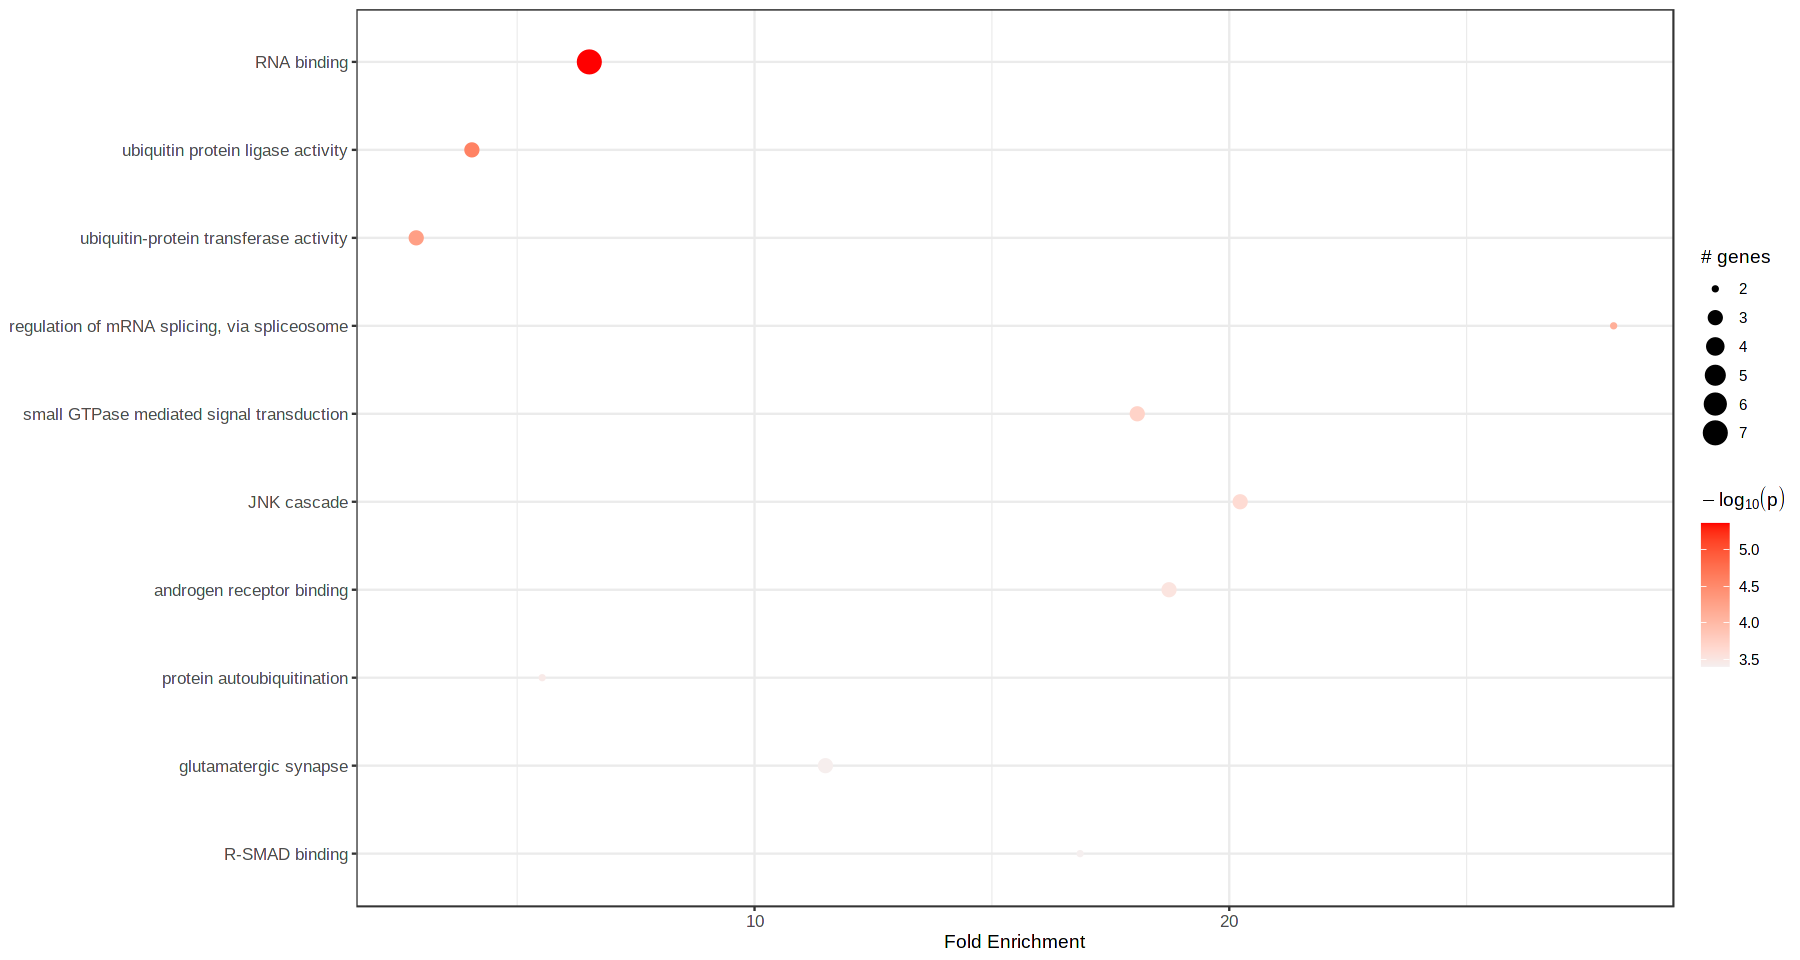

Found 55 enriched terms


Enrichment results and table of converted genes 

can be found in "results.html" 

in the folder "/mnt/ibm_lg/covid_tissue_atlas/results/cross_organ_analysis/gene_sets/pathfindr/lung/endothelial(31)"


Run cluster_enriched_terms() for clustering enriched terms





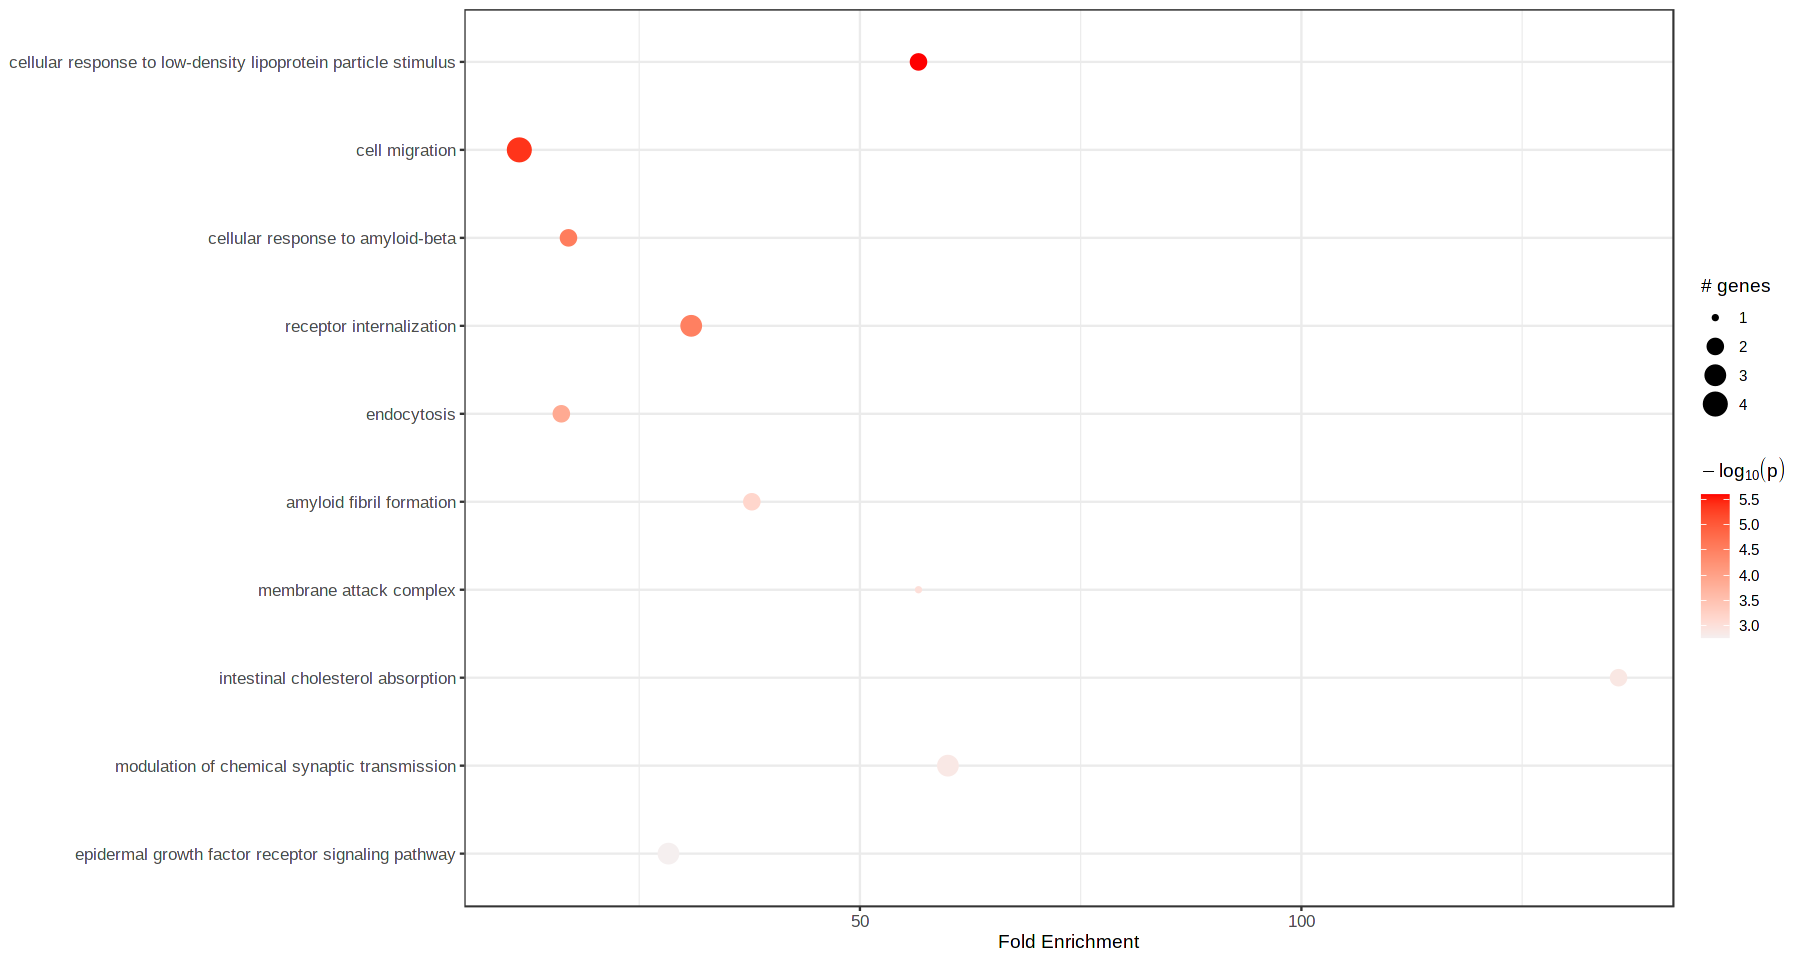

[1] "Done cell type  lung ...  endothelial"


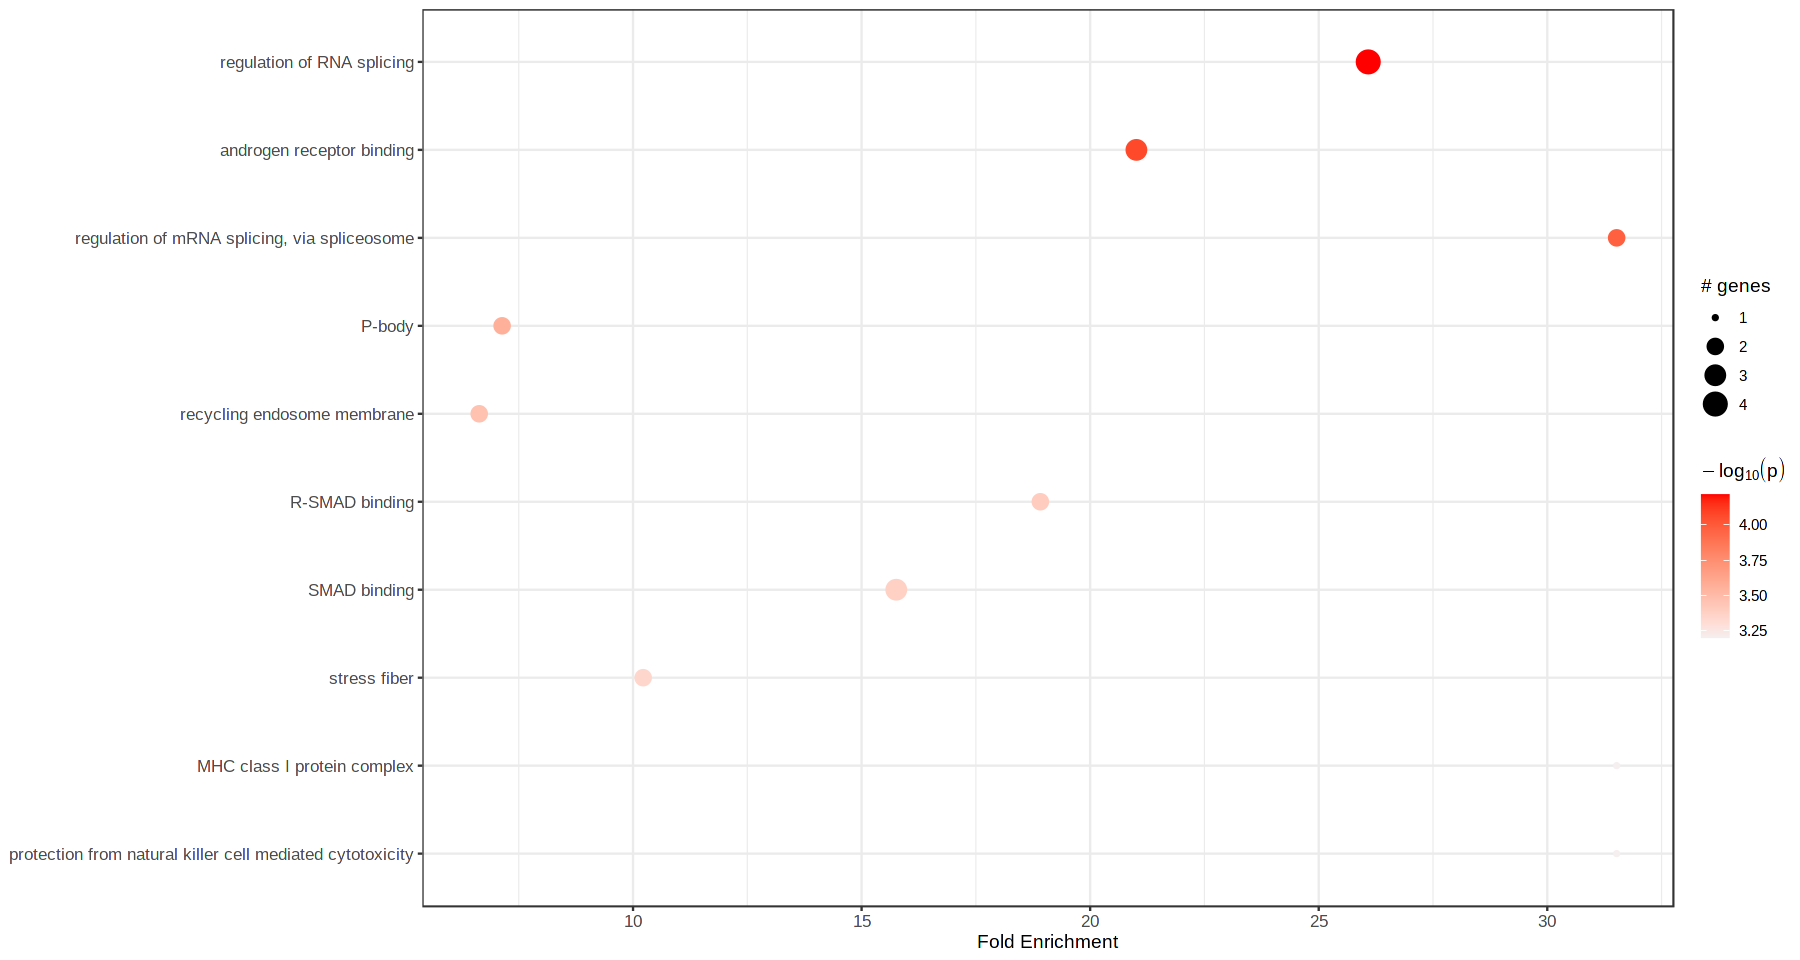

In [920]:
#Endothelial
runAll_databases(master_df, this_class = 'endothelial',
                             db_list = c('Reactome','KEGG','BioCarta','GO-All') ,
                             tissue_list = c('liver','heart','lung'))

# Visualization

All data is saved as dataframes in /mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/cell_classes

Let's load all results across databases and combine into a single data.fram

In [851]:
SETS_DIR =  "/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/cell_classes/"

loadPathways <- function(this_sample = 'macrophage',
                         direction ='up' ,
                         db_list = c('Reactome', 'KEGG', 'BioCarta', 'GO-All') ,
                         min_genes = 1){
    gene_sets = list() 
    for(d in db_list){ 
        load( paste0(SETS_DIR, this_sample, '/all_tissues_',d, '_' ,direction, '.rda') ) 
      tissue_pathways$database = d
        gene_sets[[d]] = tissue_pathways
    }

    path_df  = do.call(rbind, gene_sets) 
    
    if(direction =="up"){
          n_genes_used <- apply(!str_split(path_df$Up_regulated, ",", simplify = T) =="", 1, sum)
    }else if(direction =="down"){
          n_genes_used <- apply(!str_split(path_df$Down_regulated, ",", simplify = T) =="", 1, sum)
    }
      #consider only pathways with more than one gene used in the enrichment 
    path_df$n_genes_used <- n_genes_used 
    path_df <- path_df %>% dplyr::filter(n_genes_used> min_genes )
    return(path_df)
}

New functions for analysis of pathway results 

In [852]:
#Rank top 5 regarding of database 
plotTopPathways <- function(path_df = data.frame() , top_pathways = 10, min_pval = 0.001 , 
                            max_logp = 6 , max_FC = 5, return_df = FALSE){
    path_df %>% dplyr::filter(highest_p < min_pval ) %>% group_by(tissue, database)  %>% 
        top_n(n = -top_pathways, wt = highest_p)  %>% 
        select(Term_Description, tissue, Fold_Enrichment, highest_p, support, database) %>% 
        arrange(highest_p) -> ranked_paths 

    
    
    ranked_paths$logp <- -log10(ranked_paths$highest_p)
    ranked_paths$logp[ranked_paths$logp > max_logp] <- max_logp
    ranked_paths$Fold_Enrichment[ranked_paths$Fold_Enrichment > max_FC] <- max_FC

    # Get the names, sorted first by lg, then by avg
    out_df = ranked_paths #before making names unique 
    ranked_paths$Term_Description <- make.unique(ranked_paths$Term_Description )
    nameorder <- ranked_paths$Term_Description[order(ranked_paths$tissue, ranked_paths$Fold_Enrichment)]

    # Turn name into a factor, with levels in the order of nameorder
    ranked_paths$Term_Description <- factor(ranked_paths$Term_Description, levels = nameorder)
    
    if(!return_df){
    ranked_paths %>% ggplot(aes(x = Fold_Enrichment, y = Term_Description)) + 
        scale_colour_brewer(palette = "Set1") + 
        geom_point(aes(colour = tissue, size = logp)) + theme_bw() + theme(text =element_text(size = 15)) + 
          theme(
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank(),
            panel.grid.major.y = element_line(colour = "grey60", linetype = "dashed")
          ) + 
            facet_grid(tissue ~ ., scales = "free_y", space = "free_y") + 
            theme(strip.background =element_rect(fill="white",colour = "white"))
    }else{
        return (out_df )
    }
}


# Filter out low-confidence results 
filterTopPathways <- function( path_df = data.frame(), top_pathways = 20, 
                              min_pval = 0.001, minFC = 5,
                              min_genes_used = 2, 
                              direction ='up'){
   
    if(direction =="up"){
              n_genes_used <- apply(!str_split(path_df$Up_regulated, ",", simplify = T) =="", 1, sum)
              path_df <- path_df %>% dplyr::rename(genes  = Up_regulated )
          }else if(direction =="down"){
              n_genes_used <- apply(!str_split(path_df$Down_regulated, ",", simplify = T) =="", 1, sum)
              path_df <- path_df %>% dplyr::rename(genes  = Down_regulated )
    }
    path_df$n_genes_used = n_genes_used
    path_df %>% dplyr::filter(highest_p <= min_pval, Fold_Enrichment >= minFC, n_genes_used >min_genes_used )  %>% 
            select(Term_Description, tissue, Fold_Enrichment, highest_p, support, database, n_genes_used, genes) %>% 
            arrange(highest_p) -> ranked_paths 

    ranked_paths$logp <- -log10(ranked_paths$highest_p)

    return(ranked_paths)
}

# Jan 6th 2021 
# match the genes in a given pathway set with the individual DE values
getGeneLists <- function(pathway_hits = data.frame(), which_class = 'endothelial'){
    tissues <- pathway_hits$tissue %>% unique 
    genes_lists = list() 
    for(t in tissues){
        gene_lists <- pathway_hits %>% dplyr::filter(tissue ==t) %>% pull(genes)
        tissue_genes <- str_split(paste(gene_lists, collapse =",", sep = "") , ",")[[1]] %>% trimws() %>% unique 

        genes_lists[[t]] <-  data.frame(tissue = t, gene = tissue_genes)

        }
        genes_df <- do.call(rbind, genes_lists)
        row.names(genes_df) <- 1:dim(genes_df)[1]
    
        FC_matrix <- genes_df %>% left_join(master_df %>% dplyr::filter(cell_class==which_class), by =c('gene', 'tissue')) %>% select(tissue, gene, log2fc) %>% 
                tidyr::spread(key = gene, value = log2fc, fill = 0)
        tissue_rows <- FC_matrix$tissue
        x <- FC_matrix %>% dplyr::select(-tissue) %>% as.matrix()
        row.names(x) <- tissue_rows
    
    return(x)
}

# spread the tidy dataframe of LF changes into a matrix form
makeFCmatrix <- function(
    cell_type = 'endothelial',
    term_grep_pattern = 'VEGF',
    which_direction = 'up', n_pathways = 20){

    path_df = loadPathways(this_sample = cell_type,direction = which_direction )
    ranked_paths = filterTopPathways(path_df, top_pathways = n_pathways, min_genes_used = 2)

    pathway_hits <- ranked_paths %>% dplyr::filter(grepl(Term_Description, pattern = term_grep_pattern, ignore.case =T)) %>% arrange(tissue) %>% 
                        dplyr::filter(n_genes_used > 2, highest_p < 1e-3) 

    fc_matrix <- getGeneLists(pathway_hits, which_class = cell_type )
    return(fc_matrix)
}

quantile_breaks <- function(xs, n = 10) {
  breaks <- quantile(xs, probs = seq(0, 1, length.out = n))
  breaks[!duplicated(breaks)]
}

Top pathways in macrophage

## Macrophage up-regulated

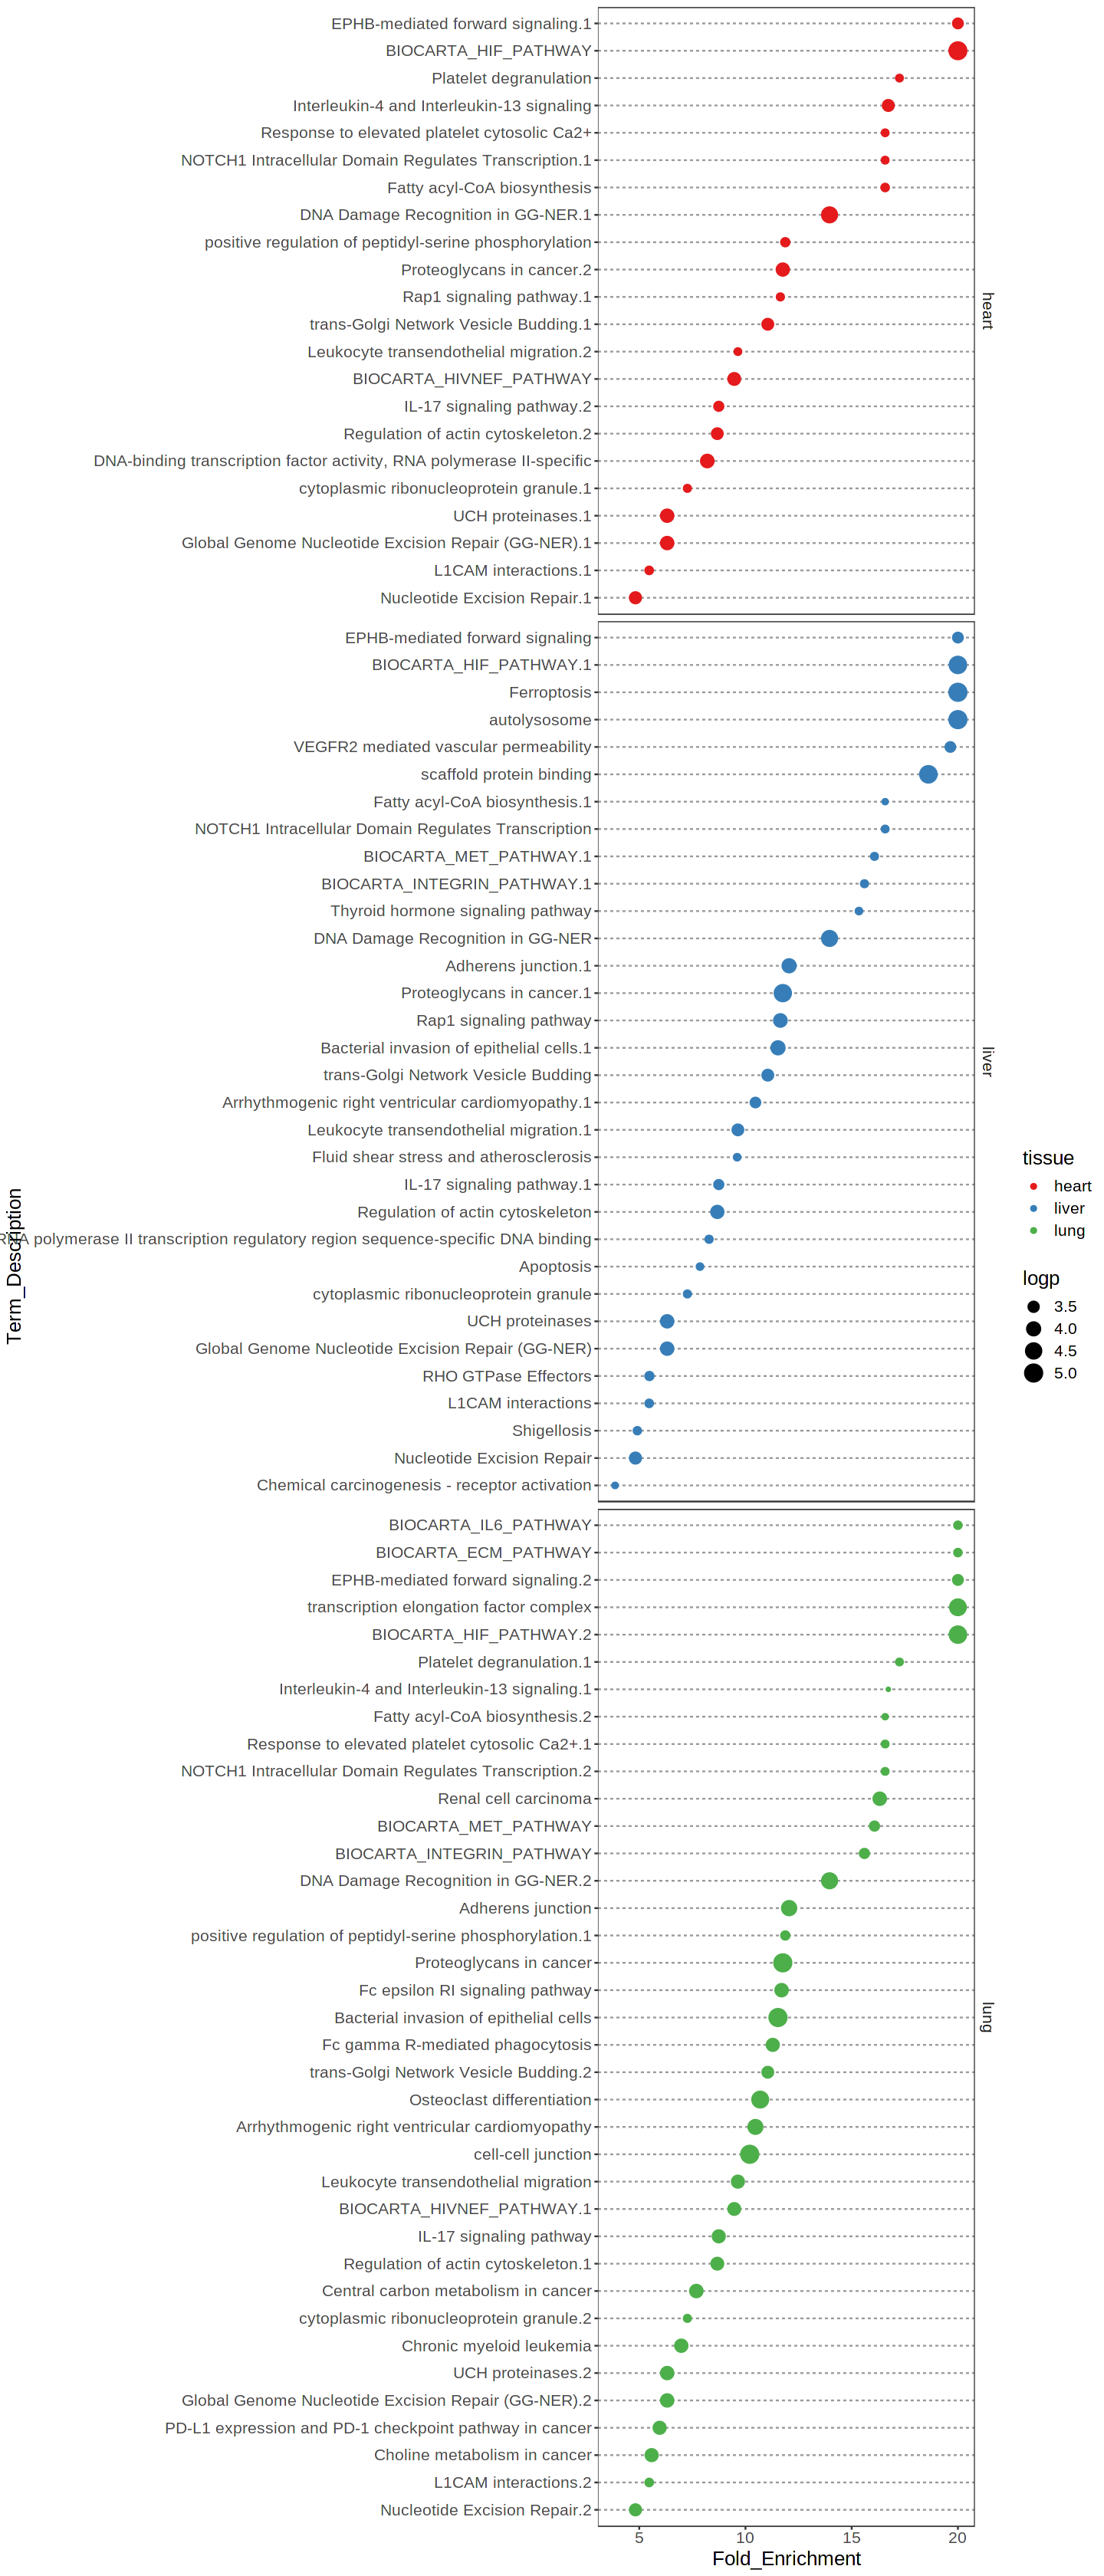

In [973]:
options(repr.plot.width=12, repr.plot.height=28)

path_df = loadPathways(this_sample = 'macrophage',direction ='up' )
plotTopPathways(path_df, top_pathways = 15, max_logp = 5 , max_FC =20)

ggsave(filename = paste0(FIG_DIR , 'PathwaysMA_UP_cov19.pdf'), width = 11, height = 25, dpi = 300)

In [974]:
macrophage_pathways = filterTopPathways(path_df, top_pathways = 100 , minFC = 3, min_genes_used = 2)
macrophage_pathways$Term_Description_Full <- as.character(macrophage_pathways$Term_Description)
macrophage_pathways$Term_Description <- as.character(macrophage_pathways$Term_Description)
# tidy names 
# macrophage_pathways$Term_Description[grepl(macrophage_pathways$Term_Description, pattern = "notch", ignore.case = T )] = "Notch signaling"
# macrophage_pathways$Term_Description[grepl(macrophage_pathways$Term_Description, pattern = "eph", ignore.case = T )] = "Ephrin signaling"
# macrophage_pathways$Term_Description[grepl(macrophage_pathways$Term_Description, pattern = "HIF|hypoxia", ignore.case = T )] = "HIF signaling"
# #macrophage_pathways$Term_Description[grepl(macrophage_pathways$Term_Description, pattern = "platelet", ignore.case = T )] = "Platelet formation"
# #macrophage_pathways$Term_Description[grepl(macrophage_pathways$Term_Description, pattern = "interl|IL-", ignore.case = T )] = "Interleukin signaling"
# macrophage_pathways$Term_Description[grepl(macrophage_pathways$Term_Description, pattern = "ubiquitin", ignore.case = T )] = "Ubiquitination"
# #macrophage_pathways$Term_Description[grepl(macrophage_pathways$Term_Description, pattern = "junction", ignore.case = T )] = "Junction"
# macrophage_pathways$Term_Description[grepl(macrophage_pathways$Term_Description, pattern = "rap1", ignore.case = T )] = "Rap1 signaling"
# macrophage_pathways$Term_Description[grepl(macrophage_pathways$Term_Description, pattern = "ubiquitin", ignore.case = T )] = "Ubiquitination"
macrophage_pathways$Term_Description[grepl(macrophage_pathways$Term_Description, pattern = "bacterial|shigellosis|infection", ignore.case = T )] = "Pathogen infection"
# macrophage_pathways$Term_Description[grepl(macrophage_pathways$Term_Description, pattern = "hippo", ignore.case = T )] = "Hippo signaling"
# macrophage_pathways$Term_Description[grepl(macrophage_pathways$Term_Description, pattern = "autophagy", ignore.case = T )] = "Autophagy"

# when multiple pathways map to the same alternative name, we select the top for each tissue 
macrophage_pathways <- macrophage_pathways %>% ungroup %>% group_by(tissue, Term_Description) %>% top_n(1, wt = logp)


In [975]:
#macrophage_pathways %>% head() 
macrophage_pathways %>% arrange(Term_Description, tissue) %>% head(40)

Term_Description                                                      tissue
1  Adherens junction                                                     liver 
2  Adherens junction                                                     lung  
3  Apoptosis                                                             liver 
4  Apoptosis                                                             lung  
5  Arrhythmogenic right ventricular cardiomyopathy                       liver 
6  Arrhythmogenic right ventricular cardiomyopathy                       lung  
7  Autophagy - animal                                                    lung  
8  BIOCARTA_HIF_PATHWAY                                                  heart 
9  BIOCARTA_HIF_PATHWAY                                                  liver 
10 BIOCARTA_HIF_PATHWAY                                                  lung  
11 cell-cell junction                                                    lung  
12 Chemical carcinogenesis - reactive oxygen species                     lung  
13 Chemical carcinogenesis - receptor activation                         liver 
14 DNA-binding transcription factor activity, RNA polymerase II-specific heart 
15 EPHB-mediated forward signaling                                       heart 
16 EPHB-mediated forward signaling                                       liver 
17 EPHB-mediated forward signaling                                       lung  
18 Fc epsilon RI signaling pathway                                       lung  
19 Fc gamma R-mediated phagocytosis                                      lung  
20 Ferroptosis                                                           liver 
21 Fluid shear stress and atherosclerosis                                liver 
22 HIF-1 signaling pathway                                               lung  
23 Hippo signaling pathway                                               lung  
24 IL-17 signaling pathway                                               heart 
25 IL-17 signaling pathway                                               liver 
26 IL-17 signaling pathway                                               lung  
27 Interleukin-4 and Interleukin-13 signaling                            heart 
28 Interleukin-4 and Interleukin-13 signaling                            lung  
29 Leukocyte transendothelial migration                                  heart 
30 Leukocyte transendothelial migration                                  liver 
31 Leukocyte transendothelial migration                                  lung  
32 NOTCH1 Intracellular Domain Regulates Transcription                   heart 
33 NOTCH1 Intracellular Domain Regulates Transcription                   liver 
34 NOTCH1 Intracellular Domain Regulates Transcription                   lung  
35 Osteoclast differentiation                                            lung  
36 Parathyroid hormone synthesis, secretion and action                   lung  
37 Pathogen infection                                                    liver 
38 Pathogen infection                                                    lung  
39 Phospholipase D signaling pathway                                     lung  
40 Platelet degranulation                                                heart 
   Fold_Enrichment highest_p    support     database n_genes_used
1  12.054878       9.715734e-05 0.047500000 KEGG     3           
2  12.054878       5.658794e-05 0.050000000 KEGG     3           
3   7.857995       7.806398e-04 0.040000000 KEGG     4           
4   7.857995       2.732089e-04 0.037676768 KEGG     4           
5  10.468710       3.868819e-04 0.042500000 KEGG     3           
6  10.468710       6.513346e-05 0.040405071 KEGG     3           
7   7.631865       2.795695e-04 0.015000000 KEGG     4           
8  53.041463       1.141305e-05 0.057500000 BioCarta 3           
9  53.041463       1.568591e-05 0.040202020 BioCarta 3           
10 53.041463       1.568591e-05 0.060000000 BioCarta 3         

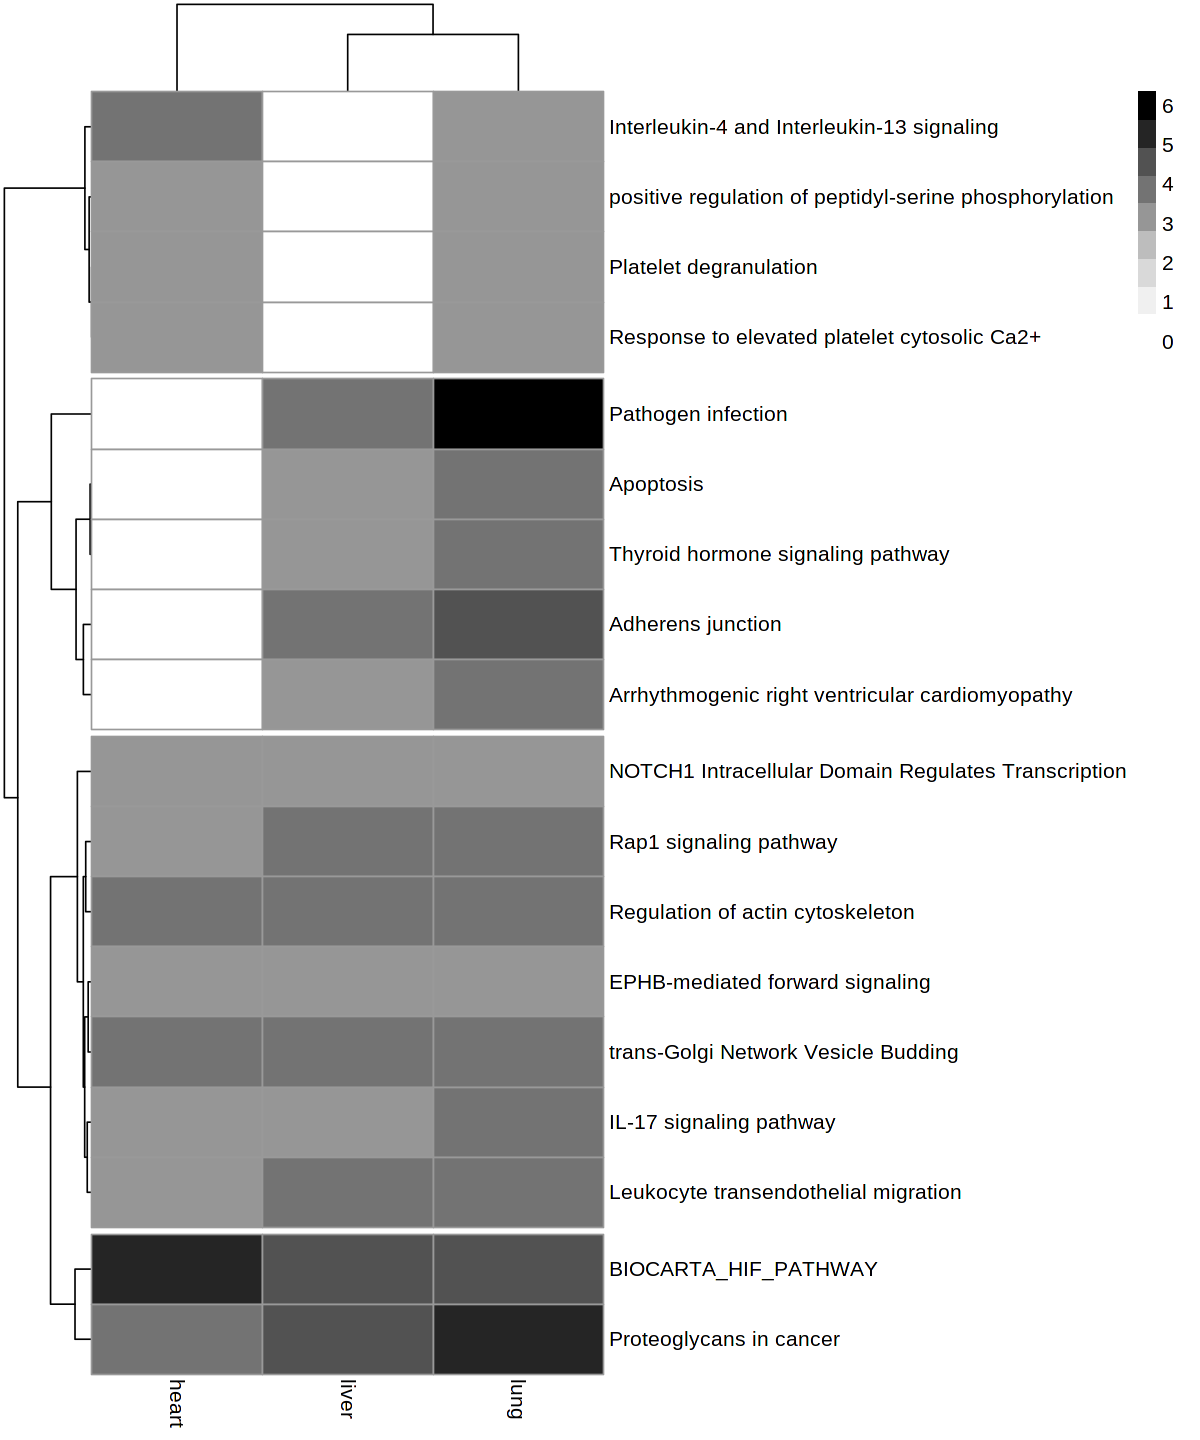

In [856]:
library(RColorBrewer)
options(repr.plot.width=10, repr.plot.height=12)

x <- macrophage_pathways %>% ungroup %>% dplyr::select(Term_Description, tissue, logp) %>%  
        tidyr::spread(key = tissue, value = logp, fill = 0)

names <- x$Term_Description
x <- x %>% dplyr::select(-Term_Description) %>% as.matrix() 
row.names(x) <- names

mat_breaks <- quantile_breaks(x, n = 11)

#select only overlapping pathways 
x <- x[which(rowSums(x>0)>1),]


# without scaling
# pheatmap(x, color = brewer.pal(n = 9, name = "Greys"), fontsize =12, 
#           method ='single', cutree_rows = 4, height = 12, width = 10,filename = paste(FIG_DIR, 'MC_sharedPathways_Heatmap.pdf', sep =""))

pheatmap(x, color = brewer.pal(n = 9, name = "Greys"), fontsize =12, 
        method ='single', cutree_rows = 4, height = 12, width = 10)

In [857]:
# save figure 
# without scaling
pheatmap(x, color = brewer.pal(n = 9, name = "Greys"), fontsize =12, 
           method ='single', cutree_rows = 4, cluster_cols = F,  height = 12, width = 10,filename = paste(FIG_DIR, 'MC_sharedPathways_Heatmap.pdf', sep =""))


In [976]:
1e-3

[1] 0.001

Save current data.frame as xlxs

In [859]:
# Make a general function that exports the main data frame format as a spreadsheet 
exportDF_xls <- function(main_df = data.frame() , # data.frame to export                          
                         db_list = c('Reactome', 'KEGG', 'BioCarta', 'GO-All') ,
                         out_file = 'macrophages.xlsx', 
                         min_pval = 0.01
                         ){
    work_book <- openxlsx::createWorkbook()
    

    for(d in db_list){ 
      tissue_pathways <- main_df %>% dplyr::filter(database == d) 
      tissue_pathways <- tissue_pathways %>% group_by(tissue) %>% arrange(tissue, highest_p)  
        
      
      # add one sheet for each database. 
      openxlsx::addWorksheet(work_book, sheetName= d)
      openxlsx::writeData(work_book, d,tissue_pathways )
    }

    openxlsx::saveWorkbook(work_book,
             file= out_file,
             overwrite = TRUE)

}

In [860]:
EXP_DIR = '/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/cell_classes/spreadsheet_merged/'

In [861]:

macrophage_pathways = filterTopPathways(path_df, top_pathways = 100 , minFC = 3, min_genes_used = 2)

exportDF_xls(main_df = macrophage_pathways, 
             out_file = paste0(EXP_DIR, 'macrophages_upregulated_allDBs_v2.xlsx') ) 

In [863]:
path_df %>% head

ID           
Reactome.1 R-HSA-5696394
Reactome.2 R-HSA-9013418
Reactome.3 R-HSA-5339562
Reactome.4 R-HSA-6785807
Reactome.5 R-HSA-9706574
Reactome.6 R-HSA-2029482
           Term_Description                                         
Reactome.1 DNA Damage Recognition in GG-NER                         
Reactome.2 RHOBTB2 GTPase cycle                                     
Reactome.3 Uptake and actions of bacterial toxins                   
Reactome.4 Interleukin-4 and Interleukin-13 signaling               
Reactome.5 RHOBTB GTPase Cycle                                      
Reactome.6 Regulation of actin dynamics for phagocytic cup formation
           Fold_Enrichment occurrence support lowest_p     highest_p   
Reactome.1 13.95828         4         0.005   3.718575e-05 3.718575e-05
Reactome.2 23.06151         8         0.010   3.899906e-05 4.313396e-03
Reactome.3 18.29016         8         0.005   4.020724e-05 6.597542e-03
Reactome.4 16.72479         7         0.015   4.204449e-05 5.722268e-03
Reactome.5 15.15470         8         0.010   4.798265e-05 9.234825e-03
Reactome.6 10.40029        10         0.015   5.951064e-05 1.730882e-03
           Up_regulated                                         Down_regulated
Reactome.1 ACTB, INO80D                                                       
Reactome.2 ACTG1, HSP90AA1                                                    
Reactome.3 HSP90AA1, MAP2K1                                                   
Reactome.4 HIF1A, HSP90AA1, ITGAX, MCL1, TIMP1, TNFRSF1B, VEGFA               
Reactome.5 ACTG1, HSP90AA1                                                    
Reactome.6 ACTB, ACTG1, CFL1, HSP90AA1                                        
           tissue database n_genes_used
Reactome.1 liver  Reactome 2           
Reactome.2 liver  Reactome 2           
Reactome.3 liver  Reactome 2           
Reactome.4 liver  Reactome 7           
Reactome.5 liver  Reactome 2           
Reactome.6 liver  Reactome 4

# Endothelial pathways 

### Endothelial up-regulated

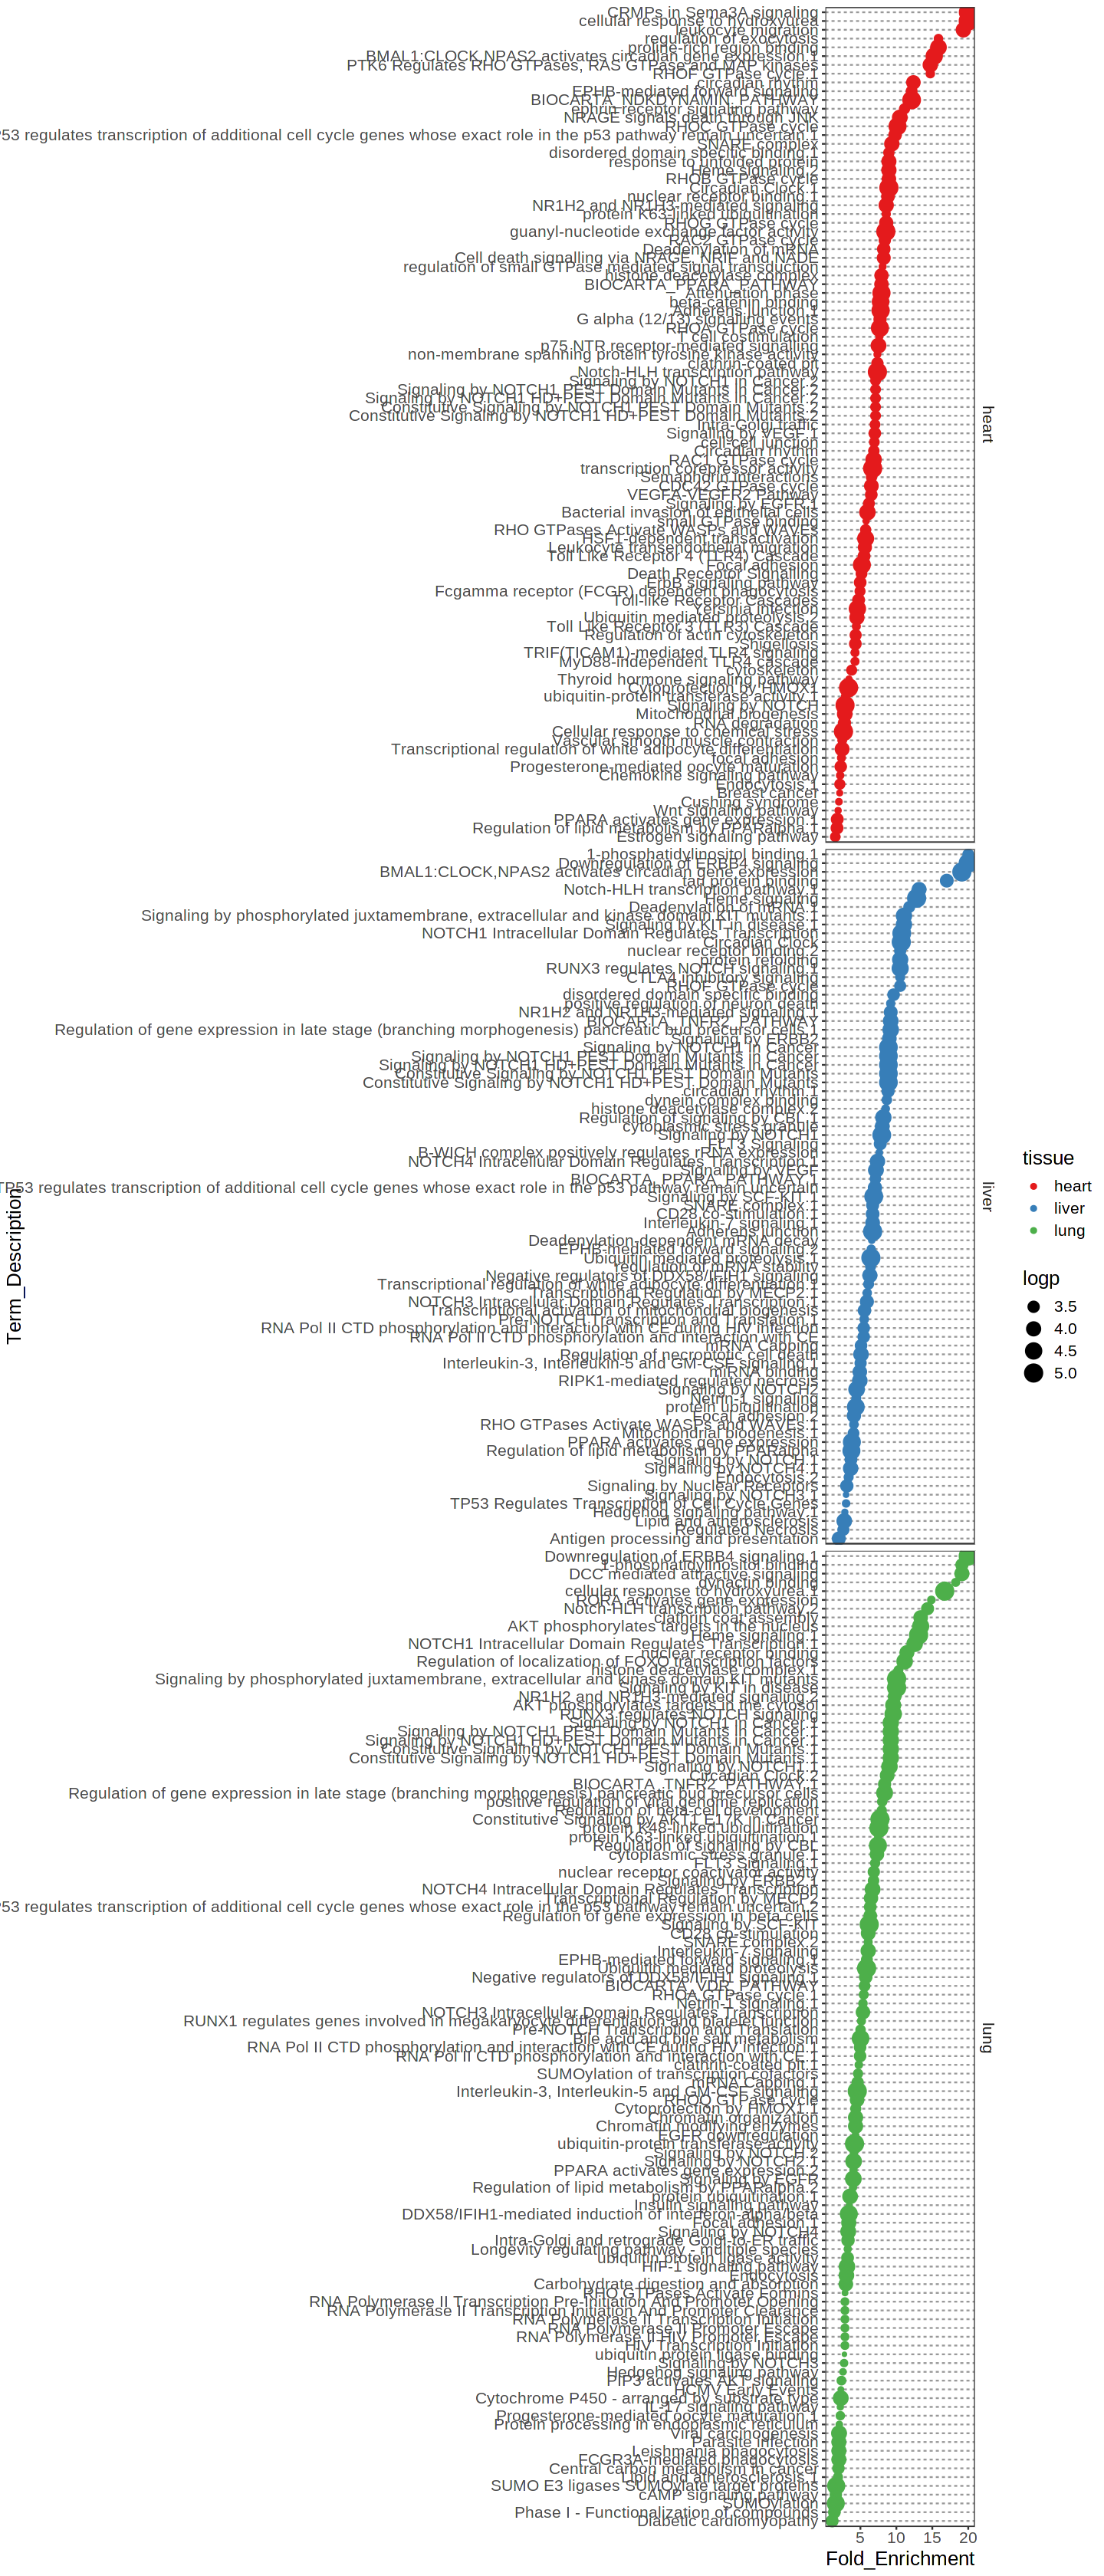

In [977]:
options(repr.plot.width=12, repr.plot.height=28)

path_df = loadPathways(this_sample = 'endothelial',direction ='up' )
plotTopPathways(path_df, top_pathways = 100, max_logp = 5 , max_FC =20)

ggsave(filename = paste0(FIG_DIR , 'PathwaysEC_UP_cov19.pdf'), width = 11, height = 25, dpi = 300)

In [987]:
# filterTopPathways <- function( path_df = data.frame(), top_pathways = 20, 
#                               min_pval = 0.001, minFC = 5,
#                               min_genes_used = 2, 
#                               direction ='up')
min_p = 0.001 # 0.001 used for paper , 0.01 used for text and specific genes 
EC_pathways = filterTopPathways(path_df, top_pathways = 100 , minFC = 3, 
                                min_genes_used = 2, min_pval = min_p)

EC_pathways$Term_Description_Full <- as.character(EC_pathways$Term_Description)
EC_pathways$Term_Description <-as.character(EC_pathways$Term_Description)
# tidy names 
EC_pathways$Term_Description[grepl(EC_pathways$Term_Description, pattern = "notch", ignore.case = T )] = "Notch signaling"
EC_pathways$Term_Description[grepl(EC_pathways$Term_Description, pattern = "eph", ignore.case = T )] = "Ephrin signaling"
EC_pathways$Term_Description[grepl(EC_pathways$Term_Description, pattern = "erbb", ignore.case = T )] = "ERBB signaling"
EC_pathways$Term_Description[grepl(EC_pathways$Term_Description, pattern = "Toll", ignore.case = T )] = "Toll-like receptor cascade"
EC_pathways$Term_Description[grepl(EC_pathways$Term_Description, pattern = "rho.* gtp", ignore.case = T )] = "Rho-family GTPase signaling"
EC_pathways$Term_Description[grepl(EC_pathways$Term_Description, pattern = "ubiquitin", ignore.case = T )] = "Ubiquitination"
EC_pathways$Term_Description[grepl(EC_pathways$Term_Description, pattern = "small gtpase", ignore.case = T )] = "Small GTPase mediated signaling"
# EC_pathways$Term_Description[grepl(EC_pathways$Term_Description, pattern = "rap1", ignore.case = T )] = "Rap1 signaling"
EC_pathways$Term_Description[grepl(EC_pathways$Term_Description, pattern = "junction|Focal adhesion", ignore.case = T )] = "Cell-cell junction"
EC_pathways$Term_Description[grepl(EC_pathways$Term_Description, pattern = "bacterial|shigellosis|infection", ignore.case = T )] = "Pathogen infection"
EC_pathways$Term_Description[grepl(EC_pathways$Term_Description, pattern = "chromatin|histone", ignore.case = T )] = "Chromatin organization"
EC_pathways$Term_Description[grepl(EC_pathways$Term_Description, pattern = "VEGF", ignore.case = T )] = "Signaling by VEGF"

# macrophage_pathways$Term_Description[grepl(macrophage_pathways$Term_Description, pattern = "autophagy", ignore.case = T )] = "Autophagy"

# when multiple pathways map to the same alternative name, we select the top for each tissue 


In [988]:
EC_pathways %>% dplyr::filter(grepl(Term_Description, pattern ='otch')) %>% arrange(Term_Description, tissue) %>% 

Term_Description tissue Fold_Enrichment highest_p    support    
Reactome.320 Notch signaling  heart   7.108024       5.039232e-04 0.005376344
Reactome.321 Notch signaling  heart   7.108024       5.039232e-04 0.005376344
Reactome.322 Notch signaling  heart   7.108024       5.039232e-04 0.005376344
Reactome.323 Notch signaling  heart   7.108024       5.039232e-04 0.005376344
Reactome.324 Notch signaling  heart   7.108024       5.039232e-04 0.005376344
Reactome.4   Notch signaling  liver   7.969583       1.276473e-05 0.019108280
Reactome.10  Notch signaling  liver  10.750636       1.276473e-05 0.015725055
Reactome.11  Notch signaling  liver   8.897078       1.395907e-05 0.015725055
Reactome.12  Notch signaling  liver   8.897078       1.395907e-05 0.015725055
Reactome.13  Notch signaling  liver   8.897078       1.395907e-05 0.015725055
Reactome.14  Notch signaling  liver   8.897078       1.395907e-05 0.015725055
Reactome.15  Notch signaling  liver   8.897078       1.395907e-05 0.015725055
Reactome.28  Notch signaling  liver   3.640427       8.959724e-05 0.006369427
Reactome.18  Notch signaling  liver  13.164044       1.131353e-04 0.015725055
Reactome.17  Notch signaling  liver   3.685932       2.675523e-04 0.013259571
Reactome.64  Notch signaling  liver   5.528898       6.468371e-04 0.006369427
Reactome.578 Notch signaling  lung    9.042412       5.020806e-05 0.038567786
Reactome.580 Notch signaling  lung   12.546346       5.020806e-05 0.041315039
Reactome.592 Notch signaling  lung    9.229496       5.451607e-05 0.038567786
Reactome.593 Notch signaling  lung    9.229496       5.451607e-05 0.038567786
Reactome.594 Notch signaling  lung    9.229496       5.451607e-05 0.038567786
Reactome.595 Notch signaling  lung    9.229496       5.451607e-05 0.038567786
Reactome.596 Notch signaling  lung    9.229496       5.451607e-05 0.038567786
Reactome.620 Notch signaling  lung    3.304387       7.266925e-05 0.011049724
Reactome.582 Notch signaling  lung   14.338681       2.447815e-04 0.022794191
Reactome.660 Notch signaling  lung    5.018538       5.454004e-04 0.011049724
Reactome.583 Notch signaling  lung    4.089179       8.080078e-04 0.031544646
             database n_genes_used
Reactome.320 Reactome  4          
Reactome.321 Reactome  4          
Reactome.322 Reactome  4          
Reactome.323 Reactome  4          
Reactome.324 Reactome  4          
Reactome.4   Reactome  8          
Reactome.10  Reactome  7          
Reactome.11  Reactome  7          
Reactome.12  Reactome  7          
Reactome.13  Reactome  7          
Reactome.14  Reactome  7          
Reactome.15  Reactome  7          
Reactome.28  Reactome  4          
Reactome.18  Reactome  5          
Reactome.17  Reactome  9          
Reactome.64  Reactome  3          
Reactome.578 Reactome 10          
Reactome.580 Reactome  9          
Reactome.592 Reactome  8          
Reactome.593 Reactome  8          
Reactome.594 Reactome  8          
Reactome.595 Reactome  8          
Reactome.596 Reactome  8          
Reactome.620 Reactome  4          
Reactome.582 Reactome  6          
Reactome.660 Reactome  3          
Reactome.583 Reactome 11          
             genes                                                                      
Reactome.320 CUL1, FBXW7, HDAC9, TBL1X                                                  
Reactome.321 CUL1, FBXW7, HDAC9, TBL1X                                                  
Reactome.322 CUL1, FBXW7, HDAC9, TBL1X                                                  
Reactome.323 CUL1, FBXW7, HDAC9, TBL1X                                                  
Reactome.324 CUL1, FBXW7, HDAC9, TBL1X                                                  
Reactome.4   CUL1, FBXW7, ITCH, MAML2, MAML3, NCOR1, TBL1X, TBL1XR1                     
Reactome.10  CUL1, FBXW7, MAML2, MAML3, NCOR1, TBL1X, TBL1XR1                           
Reactome.11  CUL1, FBXW7, MAML2, MAML3, NCOR1, TBL1X, TBL1XR1                           
Reactome.12  CUL1, FBXW7, MAML2, MAML3, NCOR1, T

In [ ]:
EC_pathways <- EC_pathways %>% ungroup %>% group_by(tissue, Term_Description) %>% top_n(1, wt = Fold_Enrichment)


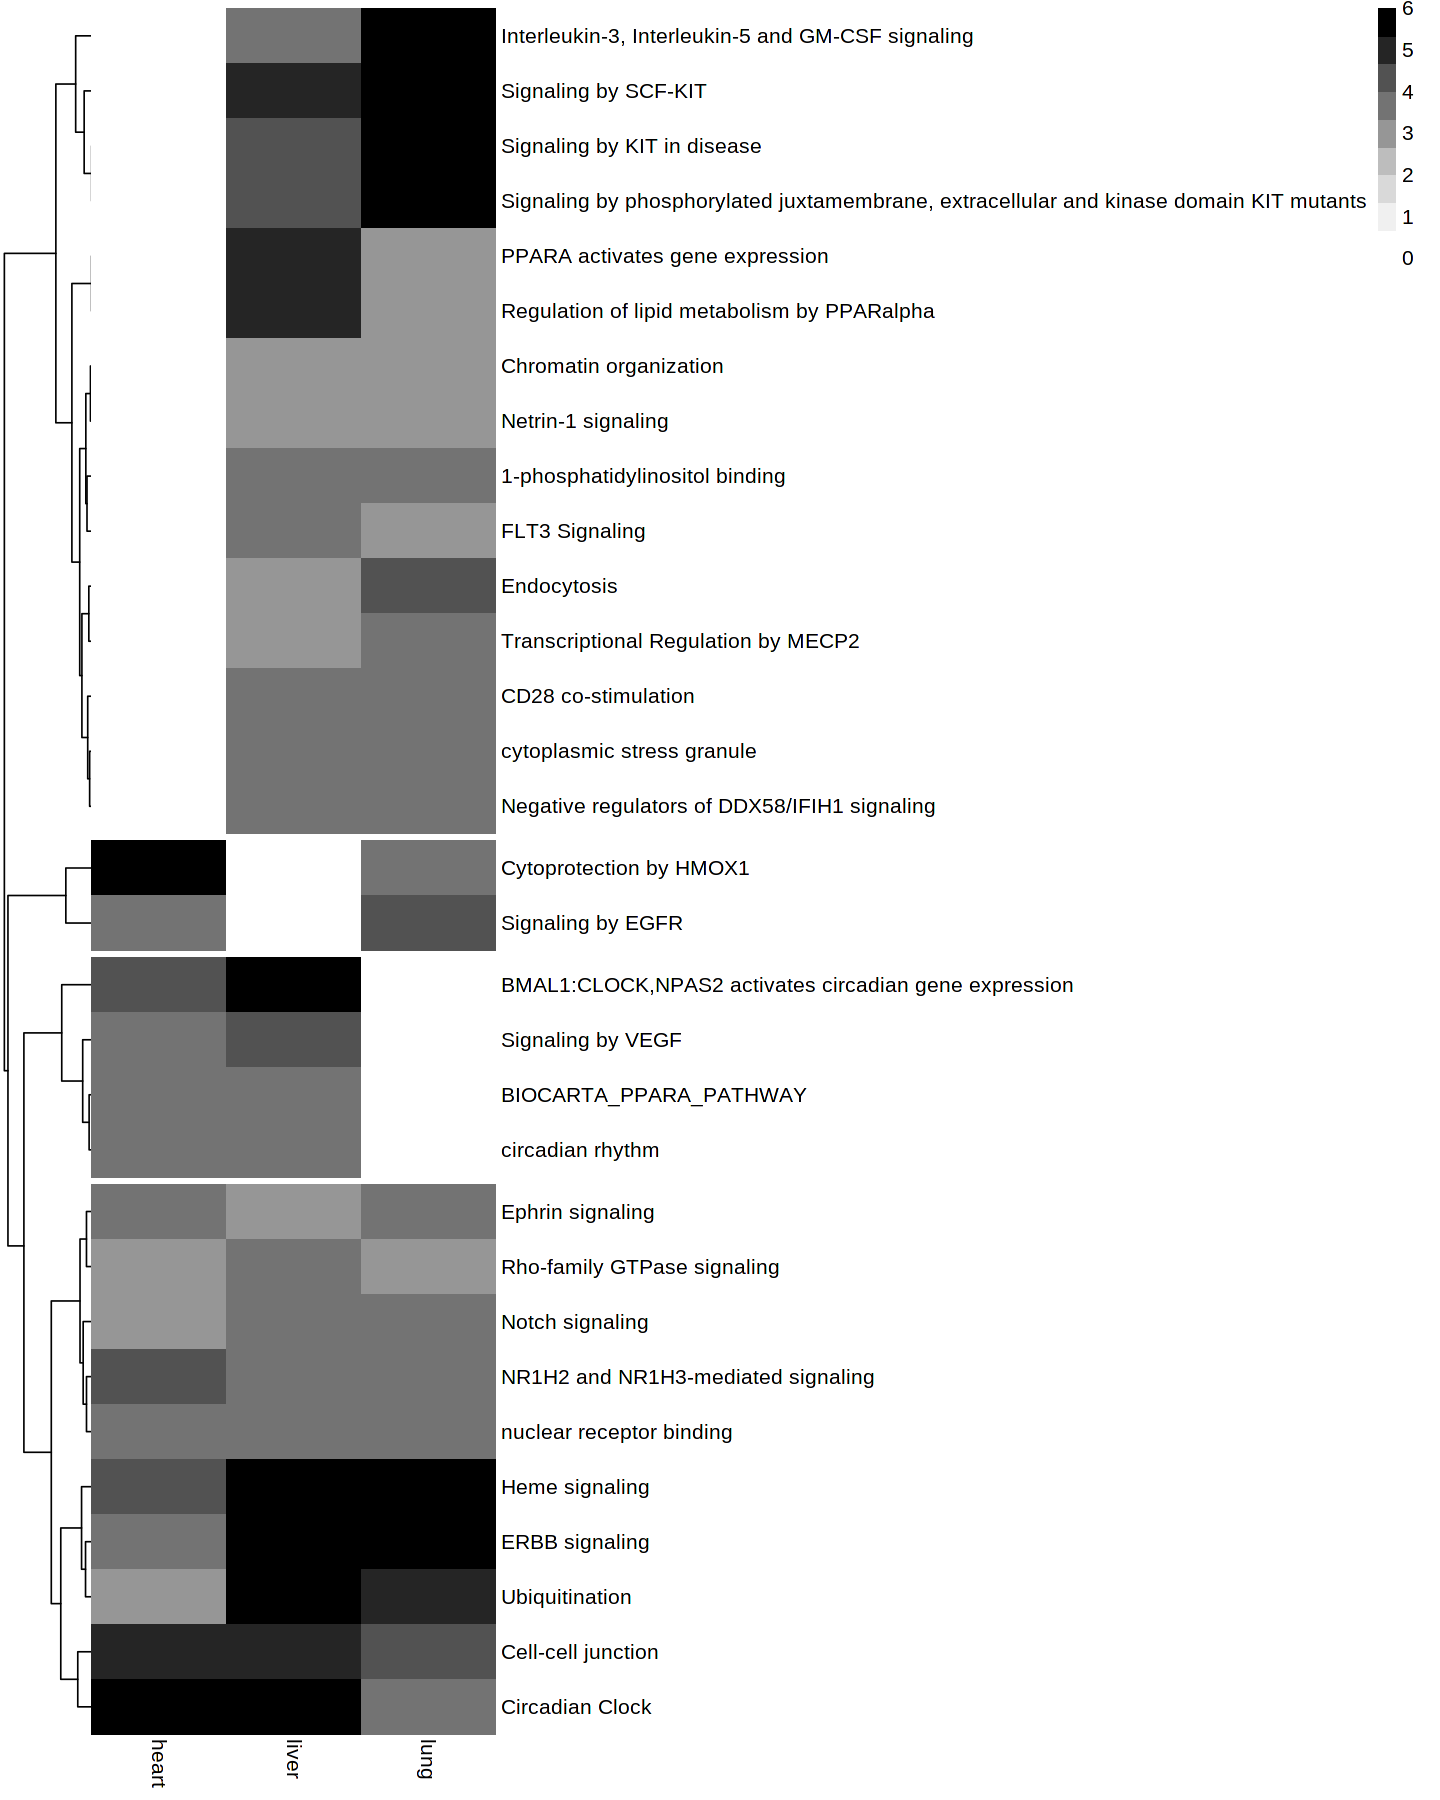

In [947]:
options(repr.plot.width=12, repr.plot.height=15)

x <- EC_pathways %>% ungroup %>% select(-Term_Description_Full) %>% distinct  %>% dplyr::filter(logp>=min_p) %>% dplyr::select(Term_Description, tissue, logp) %>%  
        tidyr::spread(key = tissue, value = logp, fill = 0)

names <- x$Term_Description
x <- x %>% dplyr::select(-Term_Description) %>% as.matrix() 
row.names(x) <- names

mat_breaks <- quantile_breaks(x, n = 100)

#select only overlapping pathways 
x <- x[which(rowSums(x>0)>1),]
x[x>6] <- 6 


# pheatmap(x, color = brewer.pal(n = 9, name = "Greys"), fontsize =12, 
#            method ='ward.D2', cutree_rows = 4, height = 12, width = 10, filename = paste(FIG_DIR, 'EC_sharedPathways_Heatmap.pdf', sep =""))

pheatmap(x, color = brewer.pal(n = 9, name = "Greys"), fontsize =12, 
        method ='ward.D2', cutree_rows = 4, height = 12, width = 10, cluster_cols = F)

In [948]:
pheatmap(x, color = brewer.pal(n = 9, name = "Greys"), fontsize =12, 
            method ='ward.D2', cutree_rows = 4, height = 12, width = 10, filename = paste(FIG_DIR, 'EC_sharedPathways_Heatmap.pdf', sep =""))


In [957]:

EC_pathways = filterTopPathways(path_df, top_pathways = 100 , minFC = 3, min_genes_used = 2, min_pval = 0.001)

exportDF_xls(main_df = EC_pathways, 
             out_file = paste0(EXP_DIR, 'endothelial_upregulated_allDBs_v2.xlsx') ) 

In [956]:
EXP_DIR

[1] "/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/cell_classes/spreadsheet_merged/"

## Lung-specific DE genes 
Jan 24th 2022 <br>
Here we export the list of lung-specific macrophage DE genes, as a complementary approach to the shared response. 

In [588]:
# Read DGE results from MAST
DGE_FILE = '/mnt/ibm_lg/covid_tissue_atlas/results/DGE/MAST/all_celltypes_DGE_ngenescovar_Nov_MAST.csv'
dge_df = read.csv(DGE_FILE)
dge_df <- dge_df %>% dplyr::filter(tissue %in% c('lung','liver','heart'), cell_type =='macrophage')

In [589]:
# Note Jan 2022: pvalues are already adjusted using method FDR
tissue_df <- dge_df %>% dplyr::filter(abs(log2fc)>1.5 & pval <1e-3) 

lung_df <- tissue_df %>% dplyr::filter(tissue=='lung')
not_lung_df <- tissue_df %>%dplyr::filter(tissue!='lung')

lung_specific <- lung_df %>% dplyr::filter(!gene %in% not_lung_df$gene)

In [592]:
lung_specific %>% arrange(desc(log2fc)) %>% write.csv(paste(EXP_DIR,'macrophage_lung_specific.csv',sep=""), row.names = F ,quote =F)

### Export lung genes in the shared response but uncoordinated

In [615]:
dataPath = '/mnt/ibm_lg/covid_tissue_atlas/results/DGE/'
fileName = 'shared_DE_signatures_filter1.csv'

shared_df <- read.csv(paste0(dataPath, fileName))

which_class = 'macrophage'
class_df <- master_df %>% dplyr::filter(cell_class ==which_class, abs(log2fc) >1, 
                                        pval<1e-3, tissue %in% c('lung','liver','heart'))



In [619]:
srt_lung <- class_df %>% dplyr::filter(tissue =='lung')
srt_liver <- class_df %>% dplyr::filter(tissue=='liver')

srt_join <- inner_join(srt_lung %>% select(gene,pval,log2fc, tissue) %>% rename(fc_lung = log2fc,pval_lung = pval), 
           srt_liver %>% select(gene,pval,log2fc, tissue) %>% rename(fc_liver = log2fc, pval_liver= pval) , by='gene')

srt_join %>% mutate(sign =fc_lung*fc_liver ) %>% 
            dplyr::filter(sign<0) %>% 
            arrange(desc(fc_lung)) %>% select(-sign) -> opposite_DE

opposite_DE %>% write.csv(paste(EXP_DIR,'macrophage_lung_liver_opposite.csv',sep=""), row.names = F ,quote =F)

In [620]:
srt_lung <- class_df %>% dplyr::filter(tissue =='lung')
srt_heart <- class_df %>% dplyr::filter(tissue=='heart')

srt_join <- inner_join(srt_lung %>% select(gene,pval,log2fc, tissue) %>% rename(fc_lung = log2fc,pval_lung = pval), 
           srt_heart %>% select(gene,pval,log2fc, tissue) %>% rename(fc_heart = log2fc, pval_heart= pval) , by='gene')

srt_join %>% mutate(sign =fc_lung*fc_heart ) %>% 
            dplyr::filter(sign<0) %>% 
            arrange(desc(fc_lung)) %>% select(-sign) -> opposite_DE

opposite_DE %>% write.csv(paste(EXP_DIR,'macrophage_lung_heart_opposite.csv',sep=""), row.names = F ,quote =F)

# Appendix functions

Let's try with a dotplot

In [547]:
library(ggtree)

ggtree v3.3.1  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution. 2018, 35(12):3041-3043. doi:10.1093/molbev/msy194
3. Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other associated data. Methods in Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628





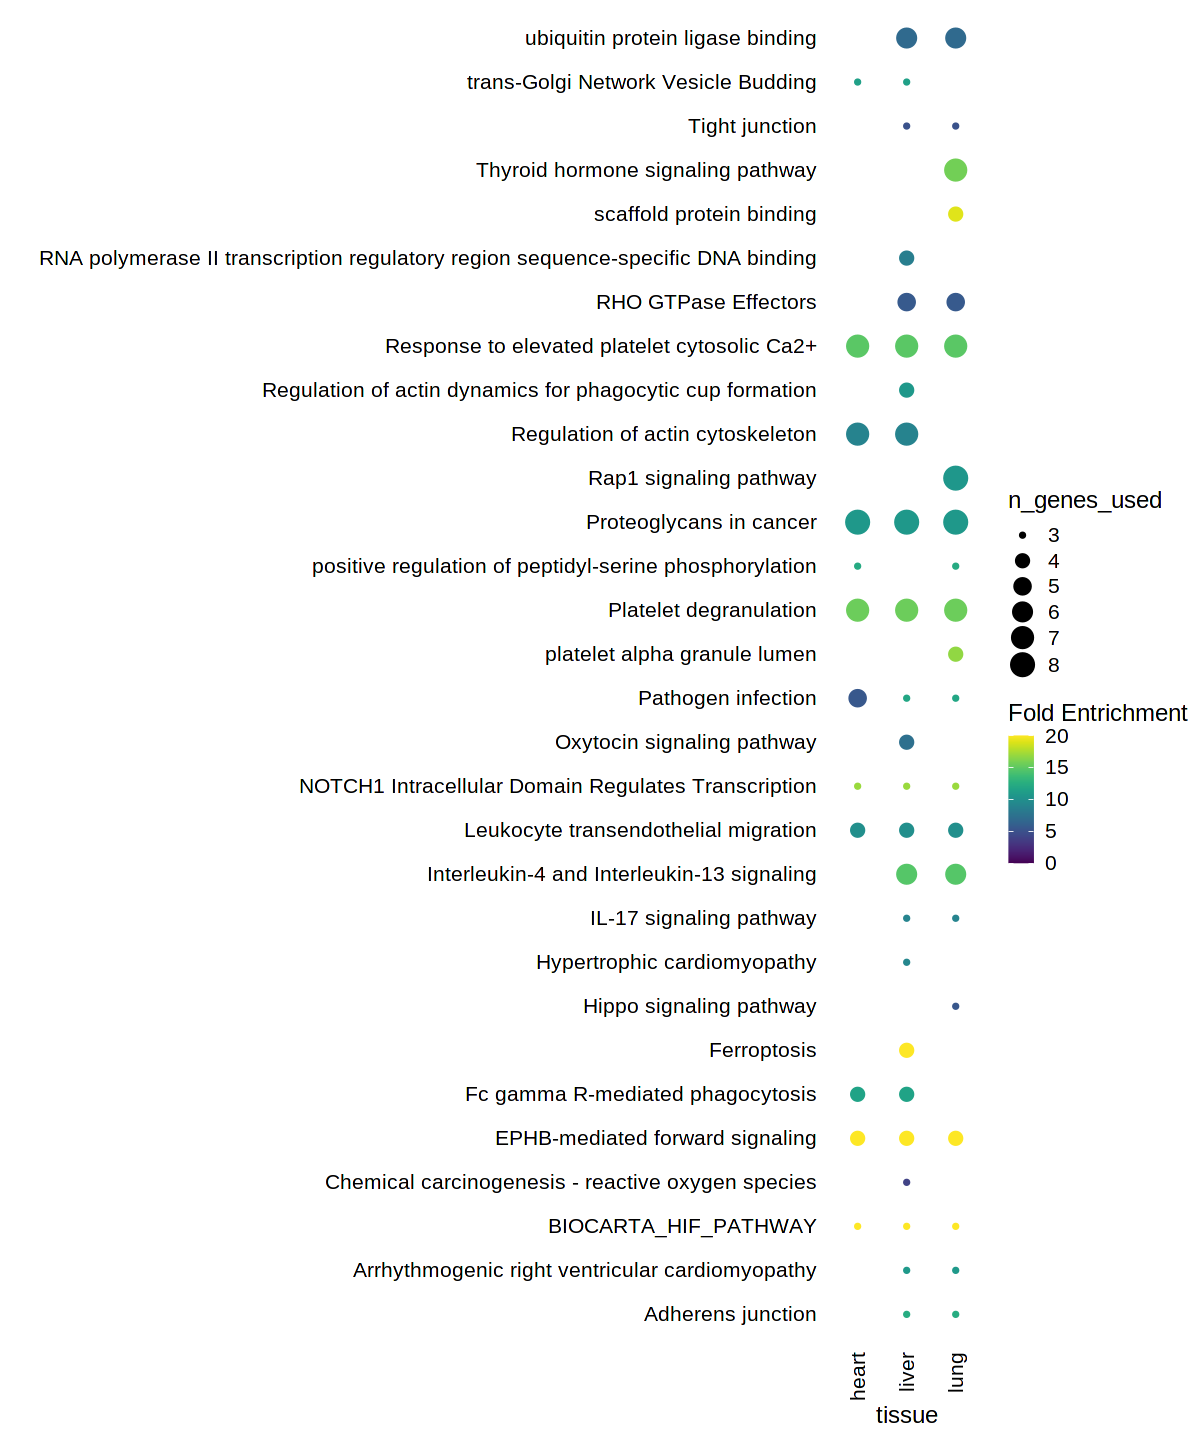

In [548]:
 

macrophage_pathways %>%  
  ggplot(aes(x=tissue, y = Term_Description, color = Fold_Enrichment, size = n_genes_used)) + 
  geom_point() + 
  cowplot::theme_cowplot() + 
  theme(axis.line  = element_blank()) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  ylab('') +
  theme(axis.ticks = element_blank()) +
  scale_color_gradientn(colours = viridis::viridis(20), limits = c(0,20), oob = scales::squish, name = 'Fold Entrichment')

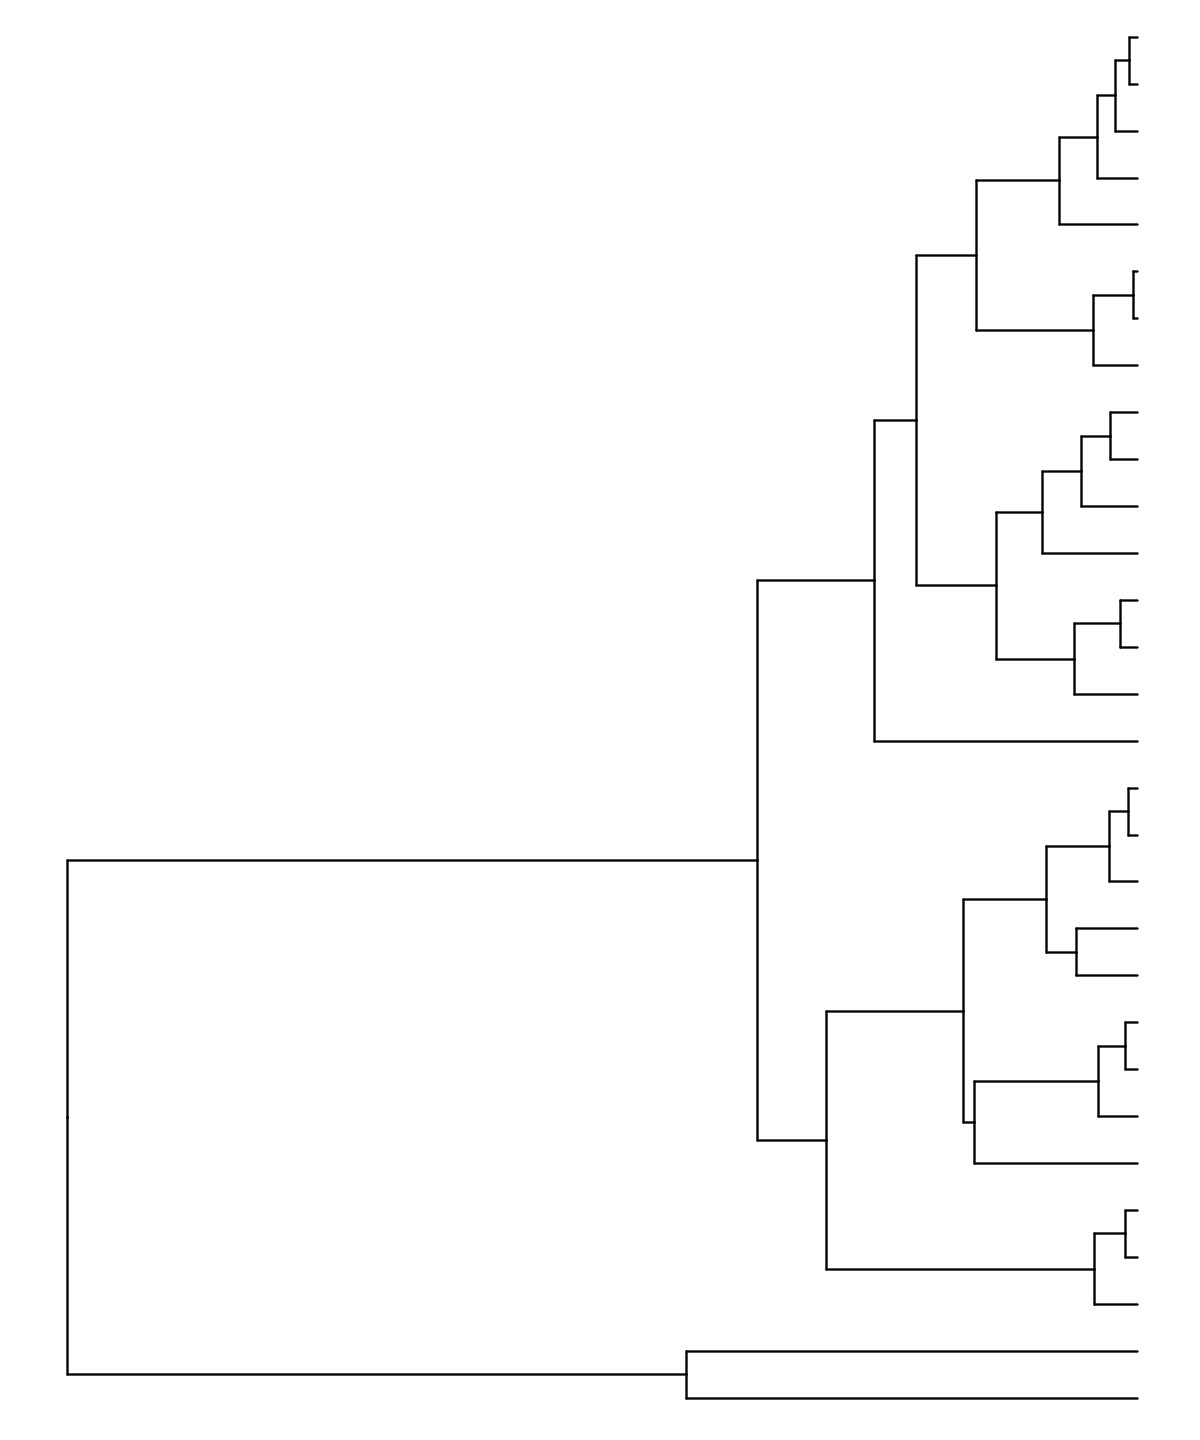

In [552]:

# make data square to calculate euclidean distance
mat <- macrophage_pathways %>% 
  dplyr::select(Term_Description, tissue, Fold_Enrichment) %>%  # drop unused columns to faciliate widening
  tidyr::spread(key = tissue, value = Fold_Enrichment, fill = 0) %>% 
  data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$Term_Description  # put gene in `row`
mat <- mat[,-1] #drop pathway column as now in rows
clust <- hclust(dist(mat %>% as.matrix())) # hclust with distance matrix


ddgram <- as.dendrogram(clust) # create dendrogram
ggtree_plot <- ggtree::ggtree(ddgram)
ggtree_plot

### Down-regulated pathways 

ERROR while rich displaying an object: Error: Faceting variables must have at least one value

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste

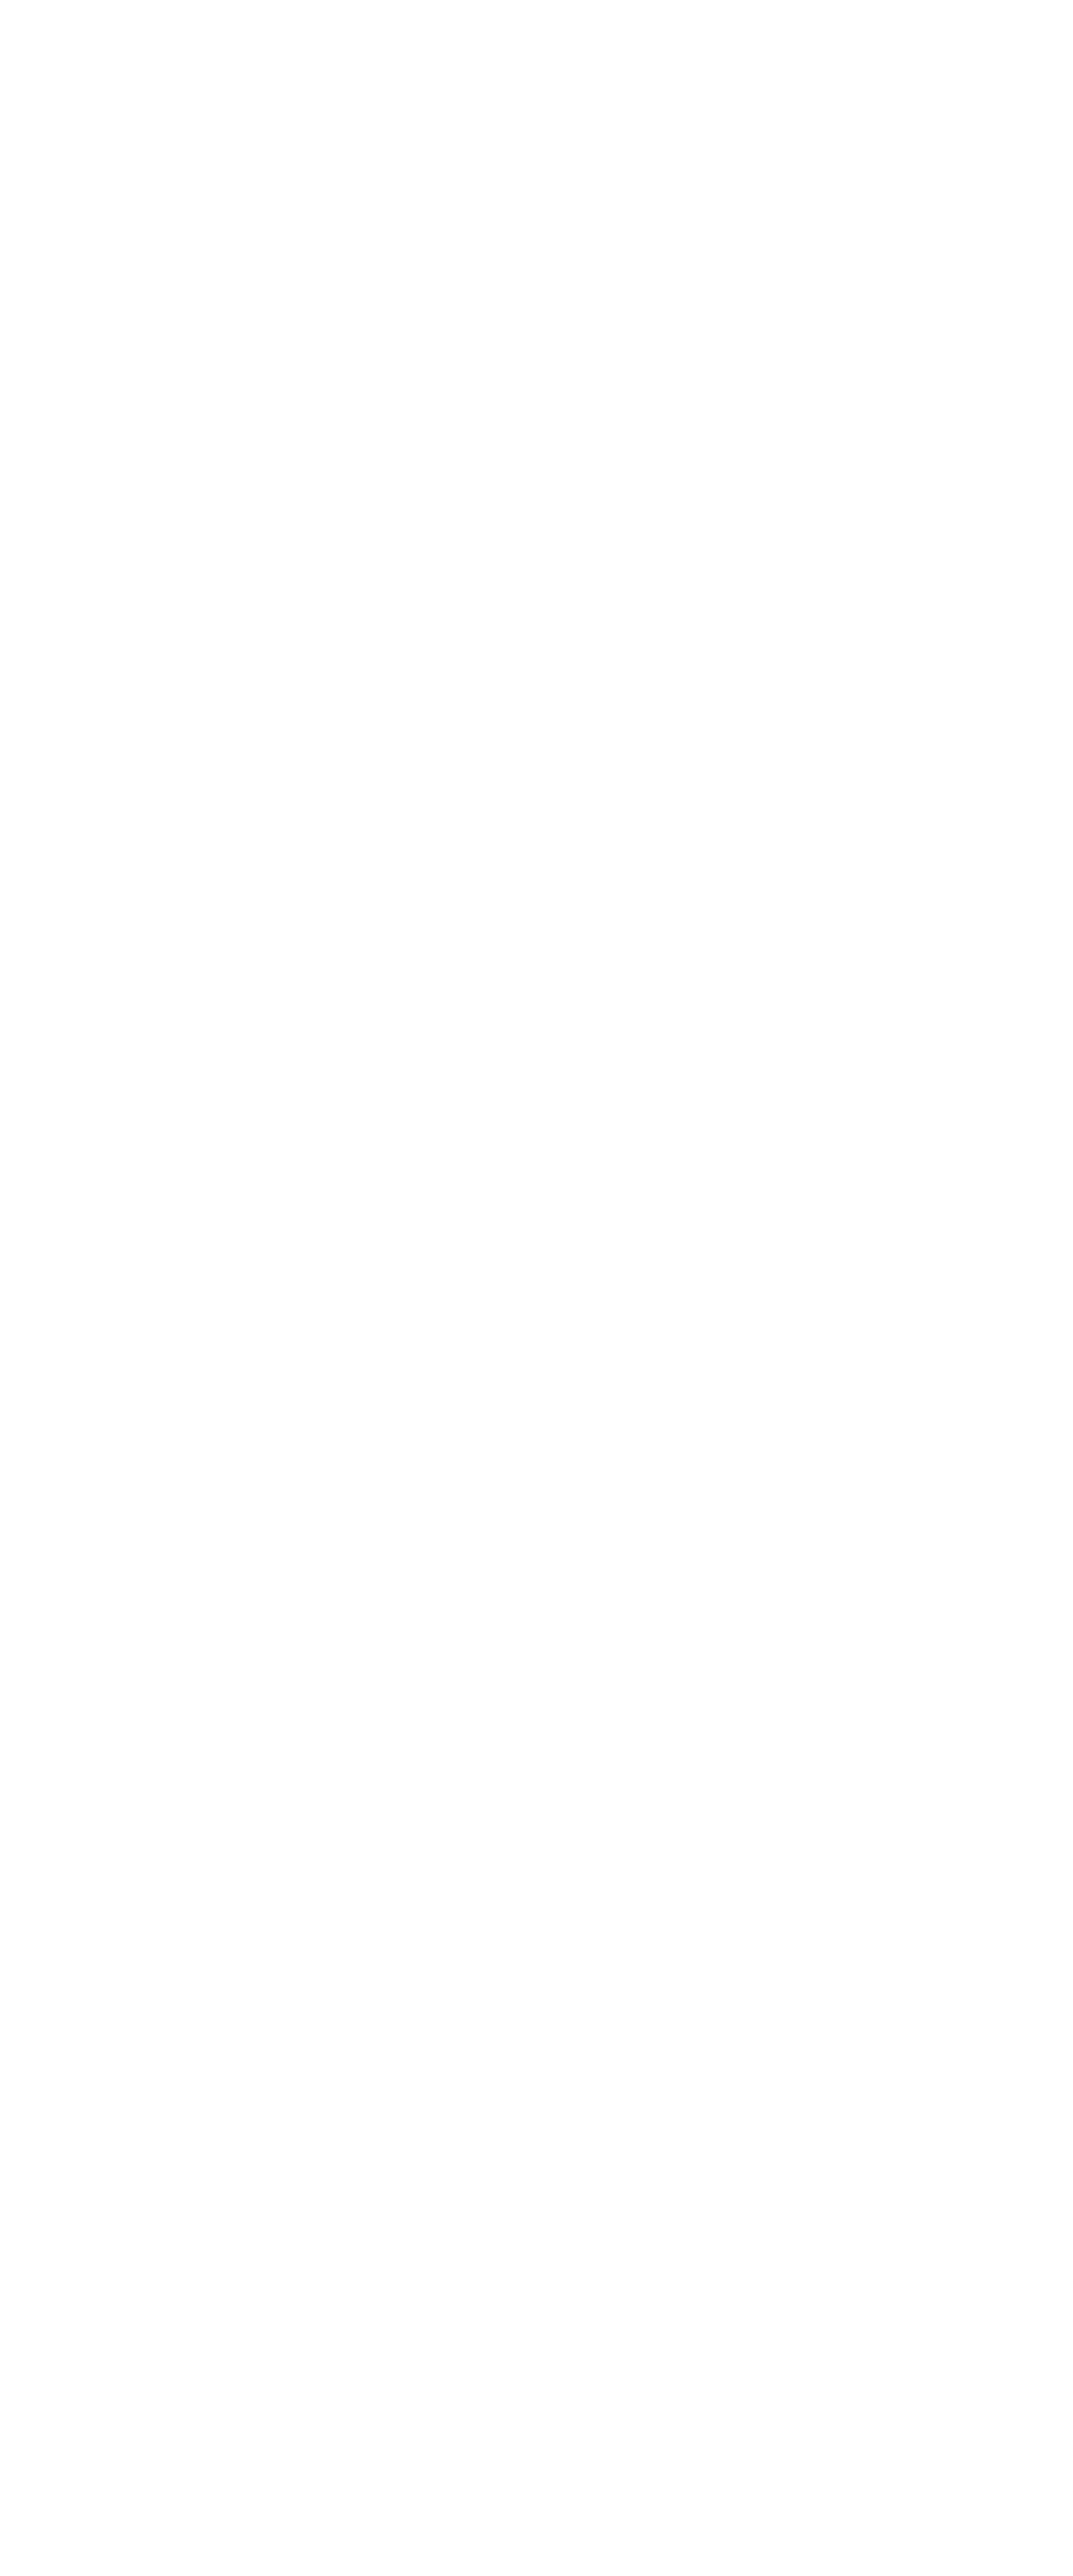

In [434]:
options(repr.plot.width=10, repr.plot.height=24)

path_df = loadPathways(this_sample = 'macrophage',direction ='down' )
plotTopPathways(path_df)

## Endothelial cells
Up regulated

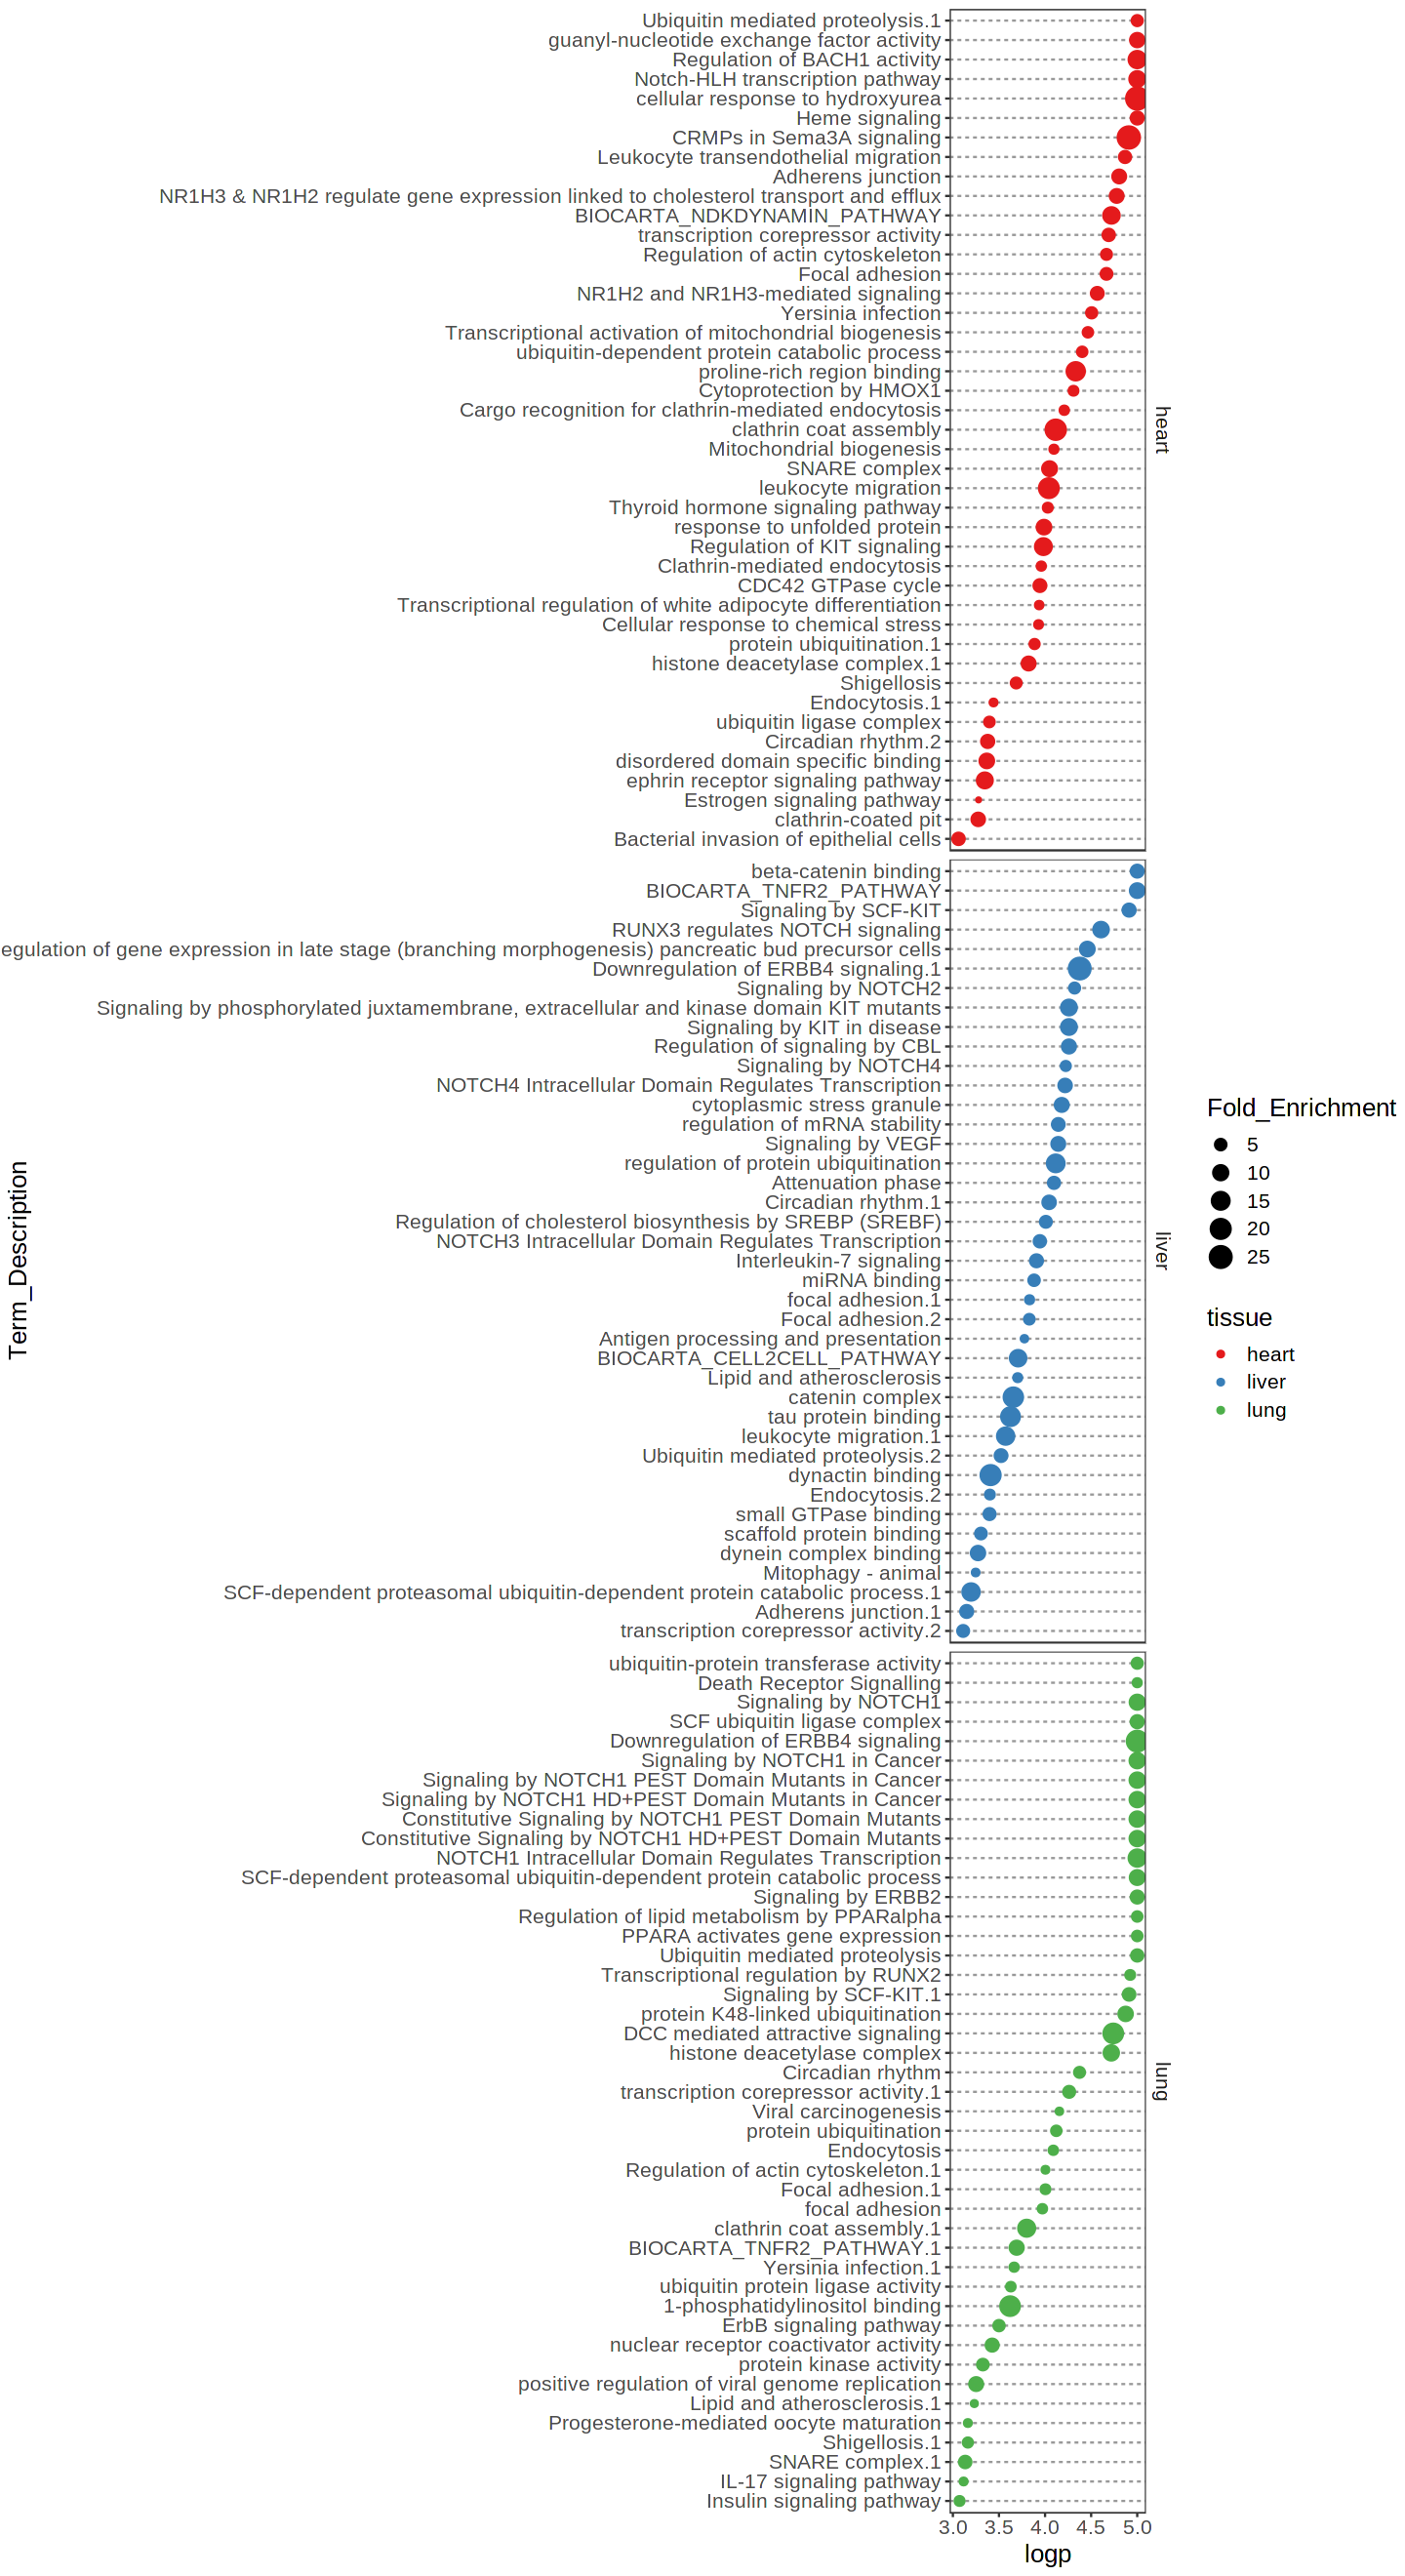

In [435]:
options(repr.plot.width=12, repr.plot.height=22)

path_df = loadPathways(this_sample = 'endothelial',direction ='up' )
plotTopPathways(path_df,top_pathways = 15, max_logp = 5)

### Notch signaling in endothelial cells

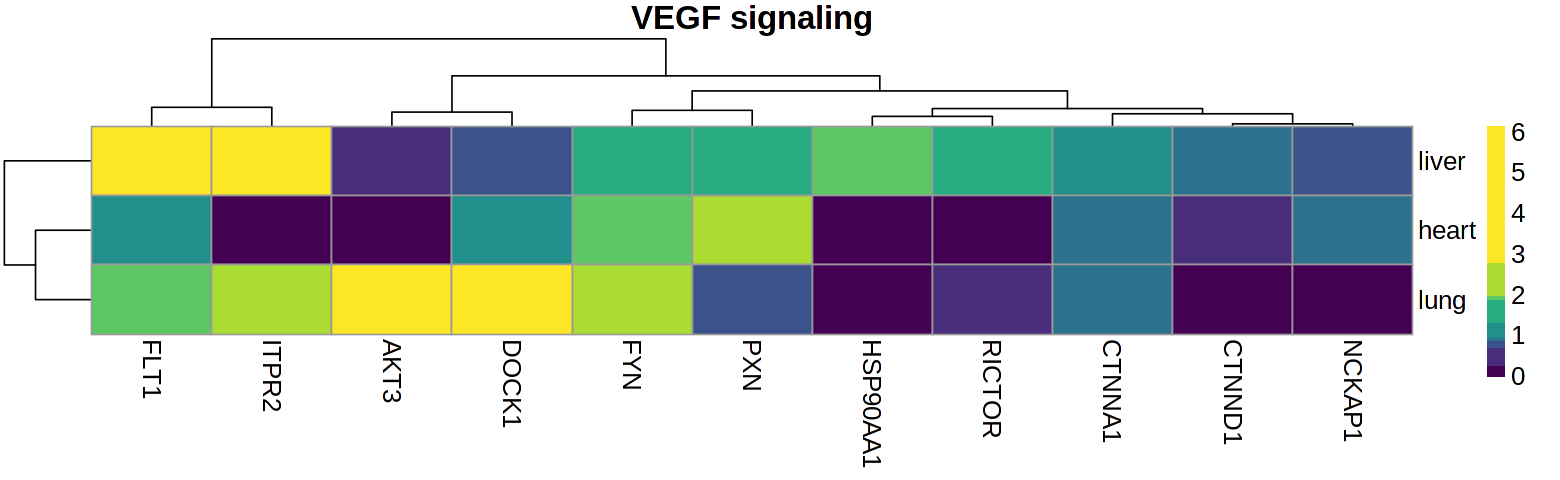

In [425]:
options(repr.plot.width=13, repr.plot.height=4)


fc_matrix <- makeFCmatrix(cell_type = 'endothelial', term_grep_pattern = 'VEGF|vascular', n_pathways = 100)
mat_breaks <- quantile_breaks(fc_matrix, n = 11)

fc_matrix %>% pheatmap(fontsize = 15, 
                       color             = viridis(length(mat_breaks) - 1),
                       breaks            = mat_breaks, clustering_method = 'ward.D2', main ='VEGF signaling') 

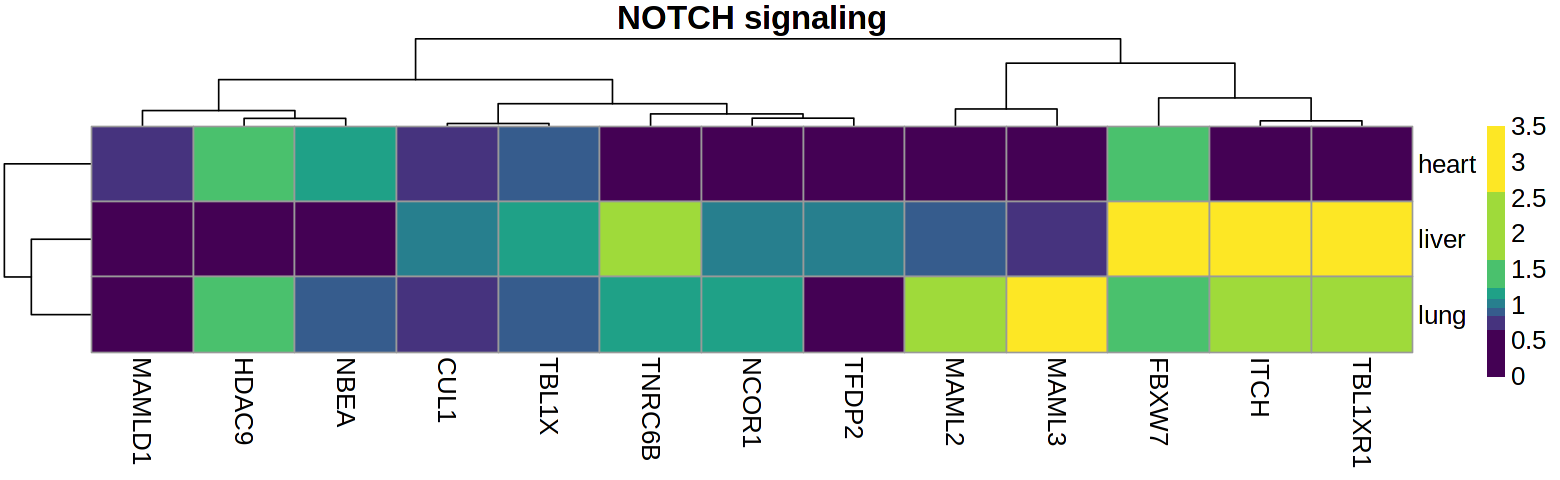

In [426]:
options(repr.plot.width=13, repr.plot.height=4)


fc_matrix <- makeFCmatrix(cell_type = 'endothelial', term_grep_pattern = 'notch', n_pathways = 100)
mat_breaks <- quantile_breaks(fc_matrix, n = 11)

fc_matrix %>% pheatmap(fontsize = 15, 
                       color             = viridis(length(mat_breaks) - 1),
                       breaks            = mat_breaks, clustering_method = 'ward.D2', main ='NOTCH signaling') 

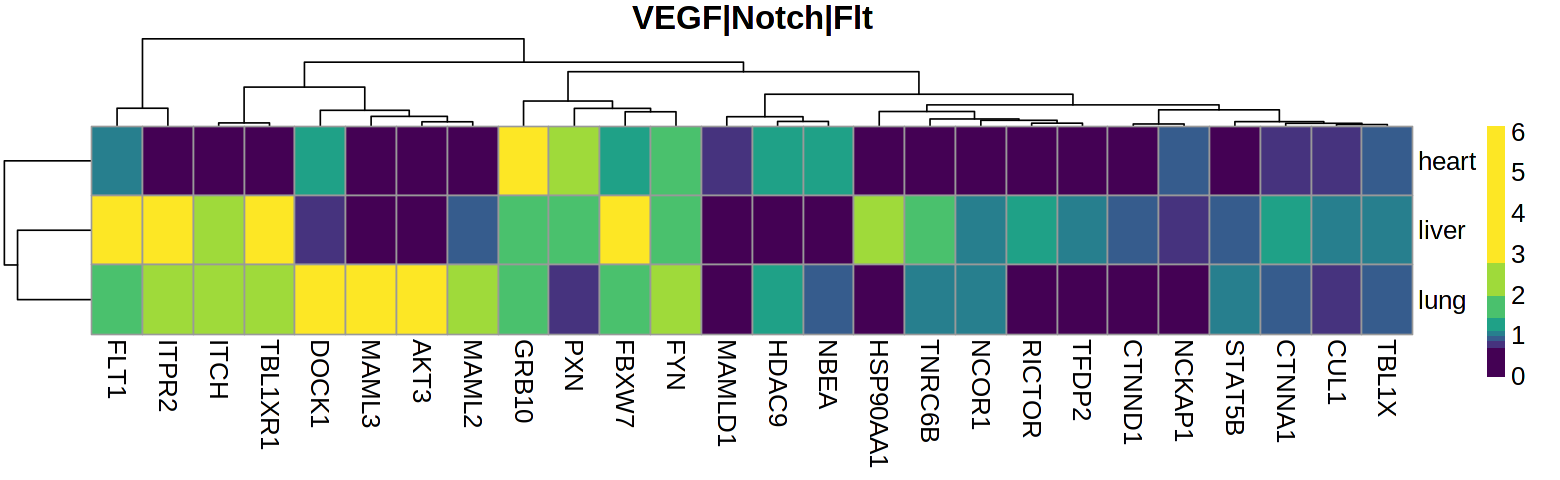

In [330]:
options(repr.plot.width=13, repr.plot.height=4)

patt = 'VEGF|Notch|Flt'
fc_matrix <- makeFCmatrix(cell_type = 'endothelial', term_grep_pattern = patt, n_pathways = 100)
mat_breaks <- quantile_breaks(fc_matrix, n = 11)

fc_matrix %>% pheatmap(fontsize = 15, 
                       color             = viridis(length(mat_breaks) - 1),
                       breaks            = mat_breaks, clustering_method = 'ward.D2', main =patt) 

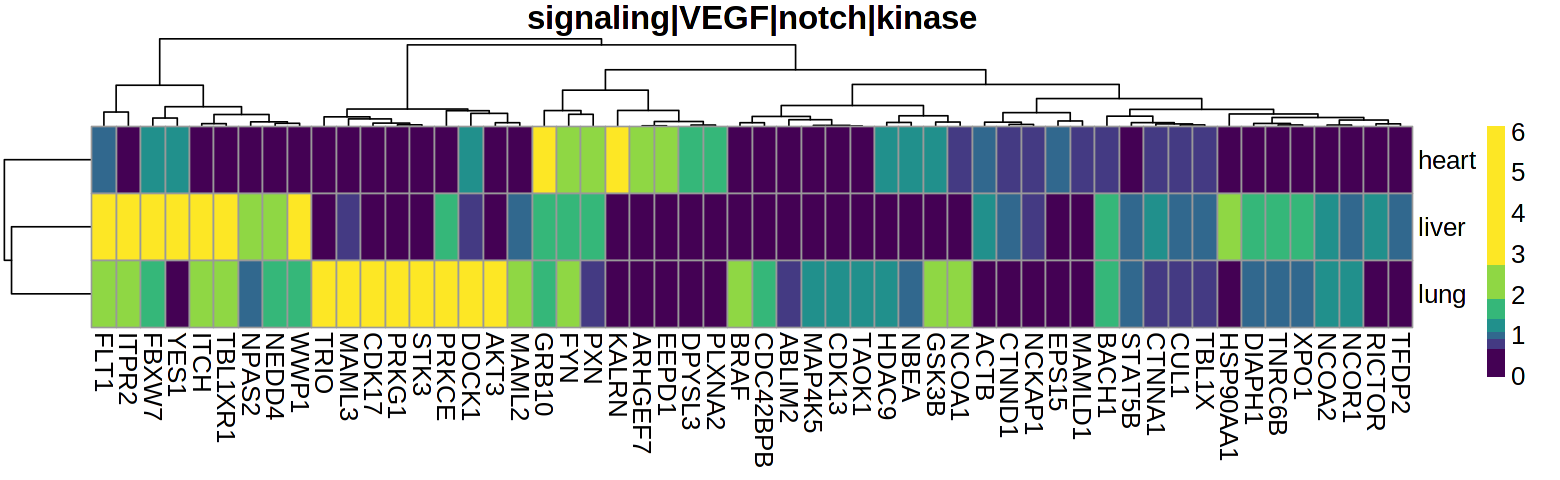

In [391]:
options(repr.plot.width=13, repr.plot.height=4)

patt = 'signaling|VEGF|notch|kinase'
fc_matrix <- makeFCmatrix(cell_type = 'endothelial', term_grep_pattern = patt, n_pathways = 100)
mat_breaks <- quantile_breaks(fc_matrix, n = 11)

fc_matrix %>% pheatmap(fontsize = 15, 
                       color             = viridis(length(mat_breaks) - 1),
                       breaks            = mat_breaks, clustering_method = 'ward.D2', main =patt) 

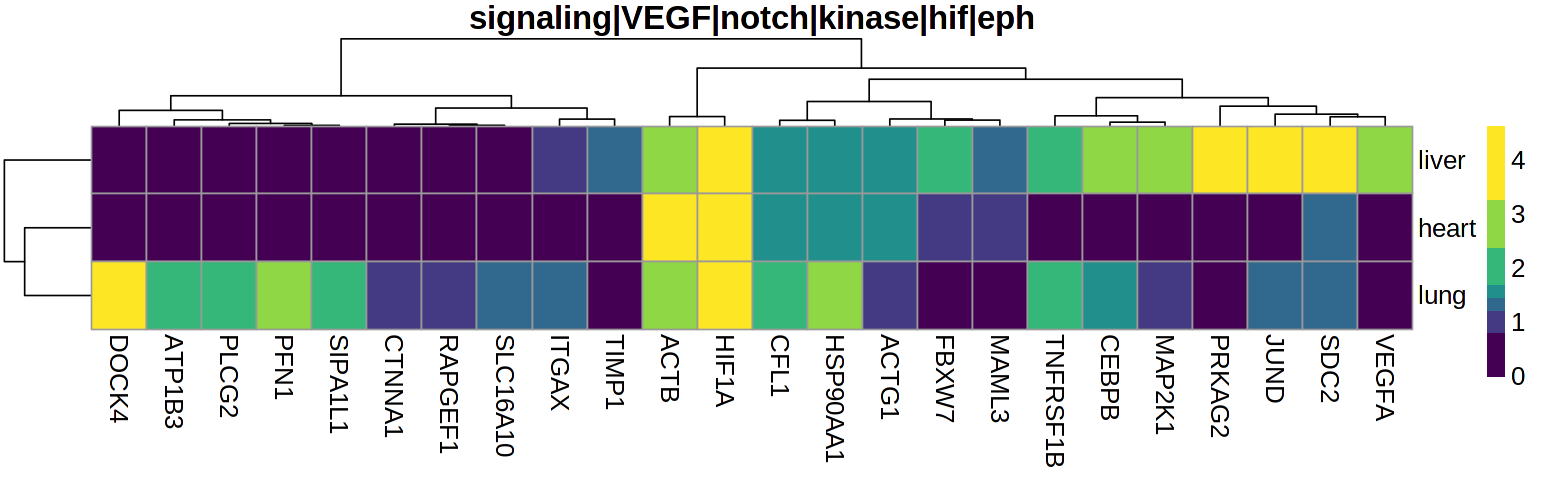

In [394]:
options(repr.plot.width=13, repr.plot.height=4)

patt = 'signaling|VEGF|notch|kinase|hif|eph'
fc_matrix <- makeFCmatrix(cell_type = 'macrophage', term_grep_pattern = patt, n_pathways = 100)
mat_breaks <- quantile_breaks(fc_matrix, n = 11)

fc_matrix %>% pheatmap(fontsize = 15, 
                       color             = viridis(length(mat_breaks) - 1),
                       breaks            = mat_breaks, clustering_method = 'ward.D2', main =patt) 

Let's make a dictionary of grep patterns that we could use to cluster pathway names

In [ ]:
'heme' , 'ERBB' , 'eph'

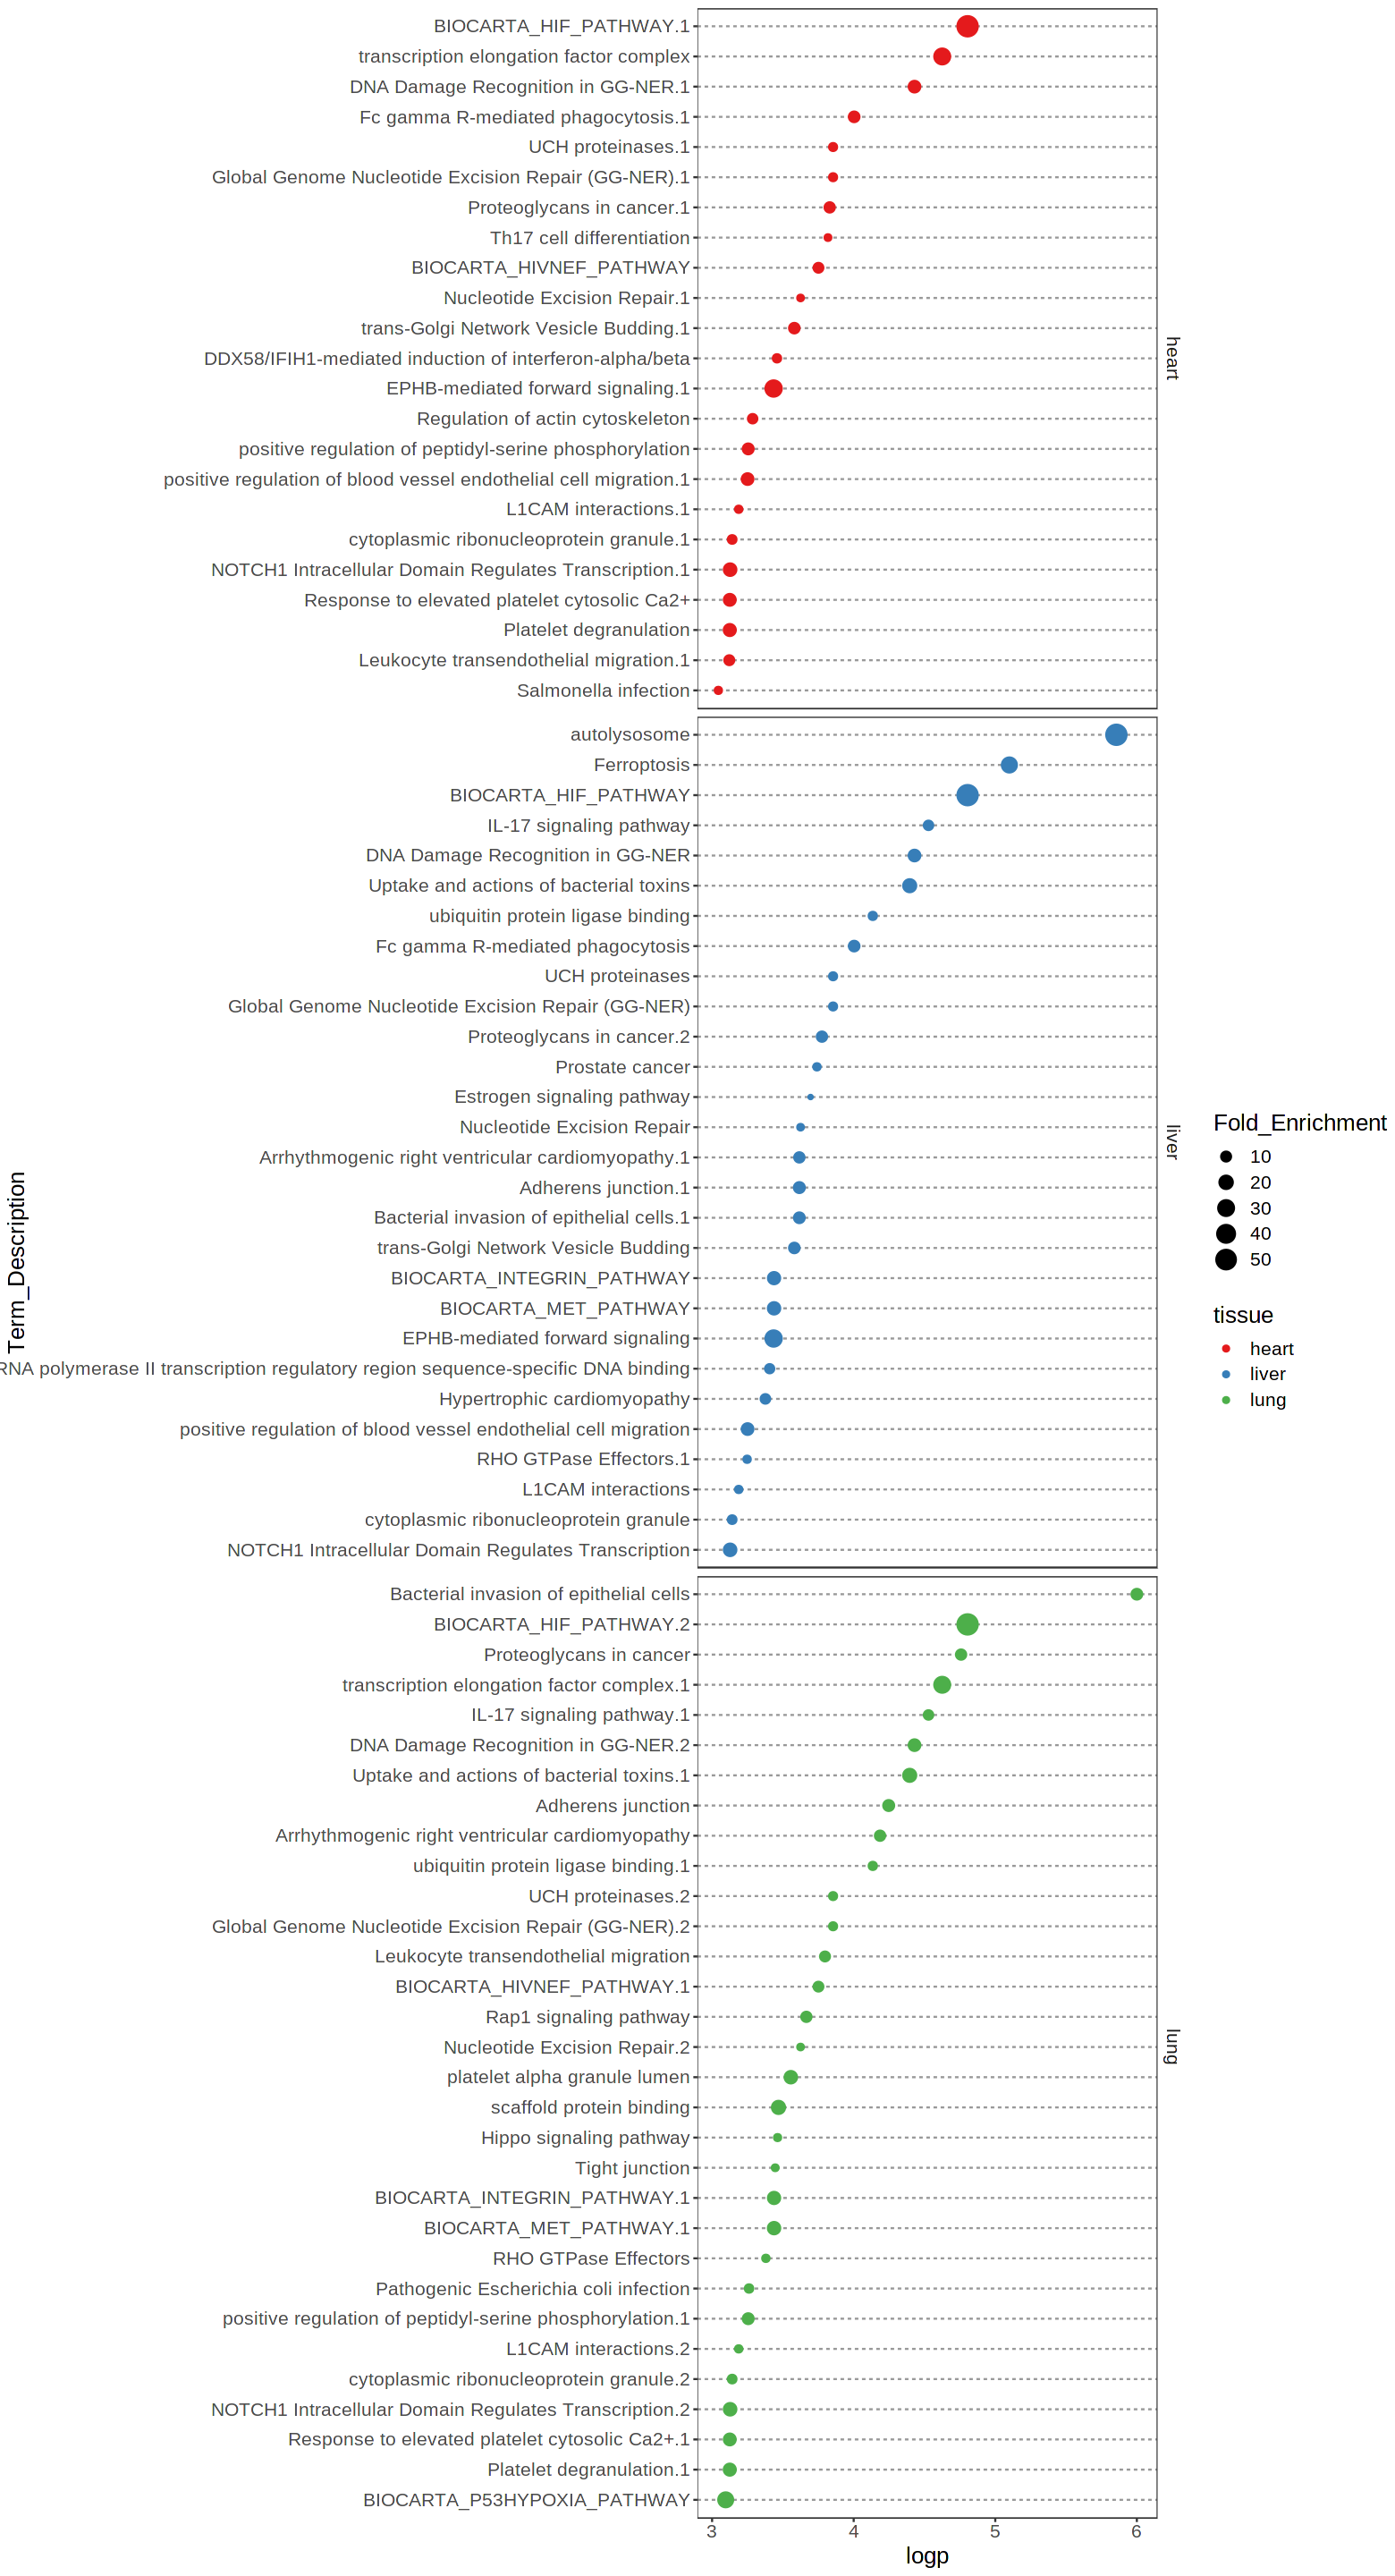

In [392]:
options(repr.plot.width=13, repr.plot.height=24)

path_df = loadPathways(this_sample = 'macrophage',direction ='up' )
plotTopPathways(path_df)

# Export to Excel spreadsheets 
Dec 3rd <br>
We are saving the results from each database on a separate sheet of an excel file for each cell type. <br>
Total of two files for up-regulated <br>
Two files for down-regulated.  <br>

In [170]:
library(tidyverse)
library(openxlsx)
exportResults <- function(this_sample = 'macrophage',
                         direction ='up' ,
                         db_list = c('Reactome', 'KEGG', 'BioCarta', 'GO-All') ,
                         out_file = 'macrophages.xlsx', 
                         min_pval = 0.01
                         ){
    work_book <- createWorkbook()
    

    for(d in db_list){ 
        load( paste0(SETS_DIR, this_sample, '/all_tissues_',d, '_' ,direction, '.rda') ) 
      tissue_pathways$database = d
      tissue_pathways <- tissue_pathways %>% dplyr::filter(highest_p < min_pval)
      tissue_pathways <- tissue_pathways %>% dplyr::filter(highest_p < min_pval)
      tissue_pathways <- tissue_pathways %>% group_by(tissue) %>% arrange(tissue, highest_p)  
        
      if(direction =="up"){
          n_genes_used <- apply(!str_split(tissue_pathways$Up_regulated, ",", simplify = T) =="", 1, sum)
      }else if(direction =="down"){
          n_genes_used <- apply(!str_split(tissue_pathways$Down_regulated, ",", simplify = T) =="", 1, sum)
      }
      #consider only pathways with more than one gene used in the enrichment 
      tissue_pathways$n_genes_used <- n_genes_used 
      tissue_pathways <- tissue_pathways %>% dplyr::filter(n_genes_used >1 )
      tissue_pathways <- tissue_pathways %>% dplyr::filter(occurrence >1 )

      #tissue_pathways <- tissue_pathways %>% select(-c())
        # save to Excel 
        addWorksheet(work_book, sheetName= d)
        writeData(work_book, d,tissue_pathways )
    }

    saveWorkbook(work_book,
             file= out_file,
             overwrite = TRUE)

}

In [171]:
EXP_DIR = '/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/cell_classes/spreadsheet_merged/'

In [172]:
exportResults(this_sample = 'macrophage', direction = 'up',
             out_file = paste0(EXP_DIR, 'macrophages_upregulated_allDBs.xlsx') ) 

In [173]:
exportResults(this_sample = 'endothelial', direction = 'up',
             out_file = paste0(EXP_DIR, 'endothelial_upregulated_allDBs.xlsx') ) 

In [166]:

n_genes_used <- apply(!str_split(tissue_pathways$Down_regulated, ",", simplify = T) =="", 1, sum)

In [174]:

for(cc in c('macrophage','endothelial')){
    for(dd in c('up','down')){
    exportResults(this_sample = cc, direction = 'up',
             out_file = paste0(EXP_DIR, cc,'_',dd,'regulated_allDBs.xlsx') ) 
        
        }
}

# Cellphone DB -- ligand-receptor interactions

In [803]:
# CELLPhone DB plotting function. 
# Modified -- we don't use it 

library(ggplot2)
library(viridis)
dot_plot = function(selected_rows_path = NULL,
                    selected_columns_path = NULL,
                    filename = 'plot.pdf',
                    width = 8,
                    height = 10,
                    means_path = './means.txt',
                    pvalues_path = './pvalues.txt',
                    means_separator = '\t',
                    pvalues_separator = '\t',
                    output_extension = '.pdf'
){

  all_pval = read.table(pvalues_path, header=T, stringsAsFactors = F, sep=means_separator, comment.char = '', check.names=F)
  all_means = read.table(means_path, header=T, stringsAsFactors = F, sep=pvalues_separator, comment.char = '', check.names=F)

  # Control 
  selected_rows = read.table(selected_rows_path, sep = "\t", header = F)$V1
  selected_columns = read.table(selected_columns_path, sep = "\t", header = F)$V1  
    
  intr_pairs = all_pval$interacting_pair
  all_pval = all_pval[,-c(1:11)]
  all_means = all_means[,-c(1:11)]

  if(is.null(selected_rows)){
    selected_rows = intr_pairs
  }

  if(is.null(selected_columns)){
    selected_columns = colnames(all_pval)
  }

  sel_pval = all_pval[match(selected_rows, intr_pairs), selected_columns]
  sel_means = all_means[match(selected_rows, intr_pairs), selected_columns]

  df_names = expand.grid(selected_rows, selected_columns)
  pval = unlist(sel_pval)
  pval[pval==0] = 0.0009
  plot.data = cbind(df_names,pval)
  pr = unlist(as.data.frame(sel_means))
  pr[pr==0] = 1
  plot.data = cbind(plot.data,log2(pr))
  colnames(plot.data) = c('pair', 'clusters', 'pvalue', 'mean')

  my_palette <- colorRampPalette(c("black", "blue", "yellow", "red"), alpha=TRUE)(n=399)
  my_palette <- colorRampPalette(viridis(3), alpha=TRUE)(n=399)
  my_palette <- brewer.pal(n = 9, name = "Blues")

  ggplot(plot.data,aes(x=clusters,y=pair)) +
  geom_point(aes(size=-log10(pvalue),color=mean)) +
  scale_color_gradientn('Log2 mean (Molecule 1, Molecule 2)', colors=my_palette) +
  theme_bw() +
  theme(panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.text=element_text(size=14, colour = "black"),
        axis.text.x = element_text(angle = 90, hjust = 1),
        axis.text.y = element_text(size=12, colour = "black"),
        axis.title=element_blank(),
        panel.border = element_rect(size = 0.7, linetype = "solid", colour = "black"))

#   if (output_extension == '.pdf') {
#       ggsave(filename, width = width, height = height, device = cairo_pdf, limitsize=F)
#   }
#   else {
#       ggsave(filename, width = width, height = height, limitsize=F)
#   }
    return(plot.data)
}

# our own dotplot 
#my_palette <- colorRampPalette(viridis(3), alpha=TRUE)(n=399)
my_palette <- brewer.pal(n = 9, name = "Blues")


# Make our own dotplot
interactionDotPlot <- function(df = data.frame() ){
    ggplot(df,aes(x=clusters,y=pair)) +
    geom_point(aes(size=-log10(pvalue),color=mean)) +
    scale_color_gradientn('Log2 mean (gene 1, gene 2)', colors=my_palette) +
    theme_bw() +
    theme(panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.text=element_text(size=10, colour = "black"),
        axis.text.x = element_text(angle = 90, hjust = 1),
        axis.text.y = element_text(size=10, colour = "black"),
        axis.title=element_blank(),
        panel.border = element_rect(size = 0.7, linetype = "solid", colour = "black"))
    
}

compareConditions <- function(this_sample ="",OUT_DIR = '/mnt/ibm_lg/covid_tissue_atlas/notebooks/cellphone/'){
    # read the output from cellphone db 
    condition = "Cov19"
    cpdb_path = paste0(OUT_DIR, this_sample, "/out_", condition,"/")

    df_cov <- dot_plot(selected_rows_path = paste0(cpdb_path, 'rows_direction1.txt' ), 
                        selected_columns_path = paste0(cpdb_path, 'columns_direction1.txt'), 
                        means_path = paste0(cpdb_path,"means.txt"),
                        pvalues_path = paste0(cpdb_path,"pvalues.txt") )


    condition = "Control"
    cpdb_path = paste0(OUT_DIR, this_sample, "/out_", condition,"/")

    df_control <- dot_plot(selected_rows_path = paste0(cpdb_path, 'rows_direction1.txt' ), 
                        selected_columns_path = paste0(cpdb_path, 'columns_direction1.txt'), 
                        means_path = paste0(cpdb_path,"means.txt"),
                        pvalues_path = paste0(cpdb_path,"pvalues.txt") )

    df_cov %>% dplyr::filter(!pair %in% df_control$pair) -> df_enriched
    return(df_enriched)
}

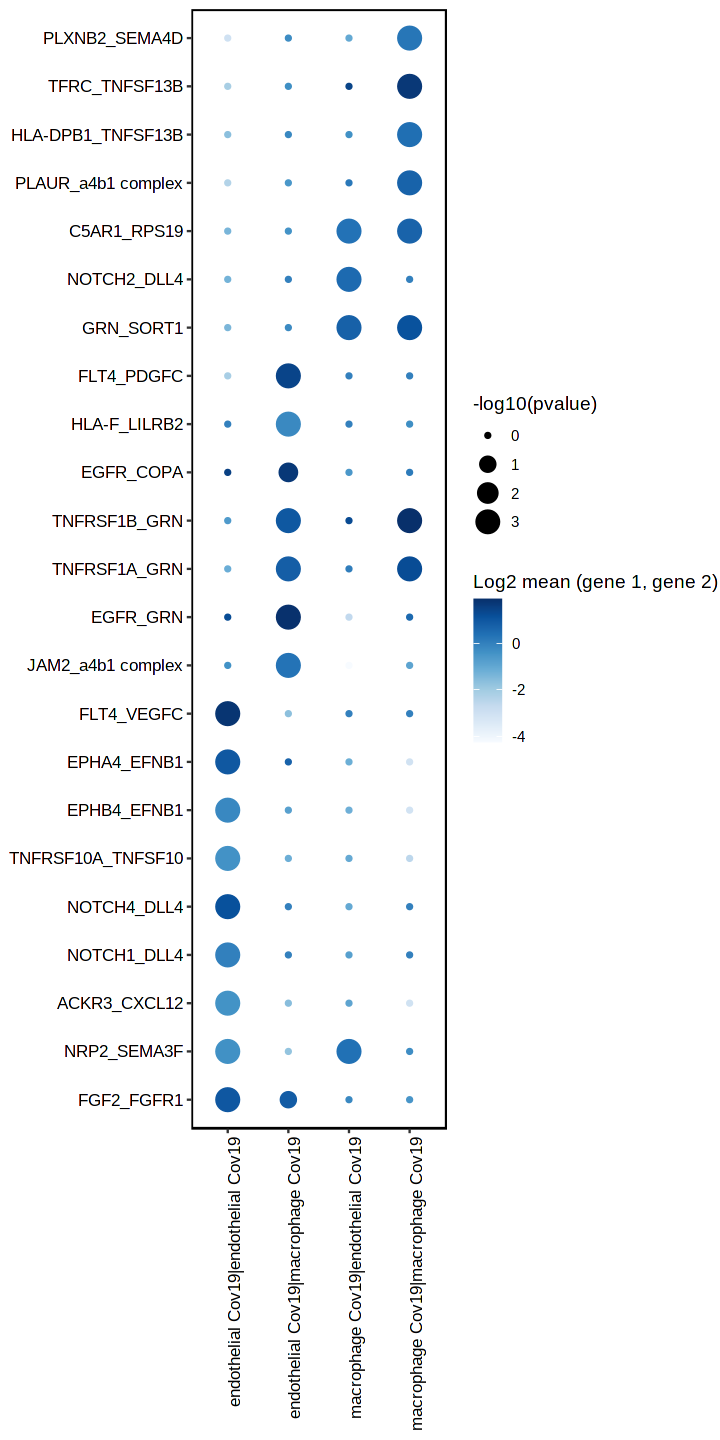

In [949]:
hh = 12
options(repr.plot.width=6, repr.plot.height=hh)

this_sample = 'heart'
df_enriched <- compareConditions(this_sample = this_sample)
interactionDotPlot(df_enriched)

#ggsave(file =paste('/mnt/ibm_lg/covid_tissue_atlas/figures/figure5/Cellphone_',this_sample,'.pdf',sep=""), width = 6, height = hh)

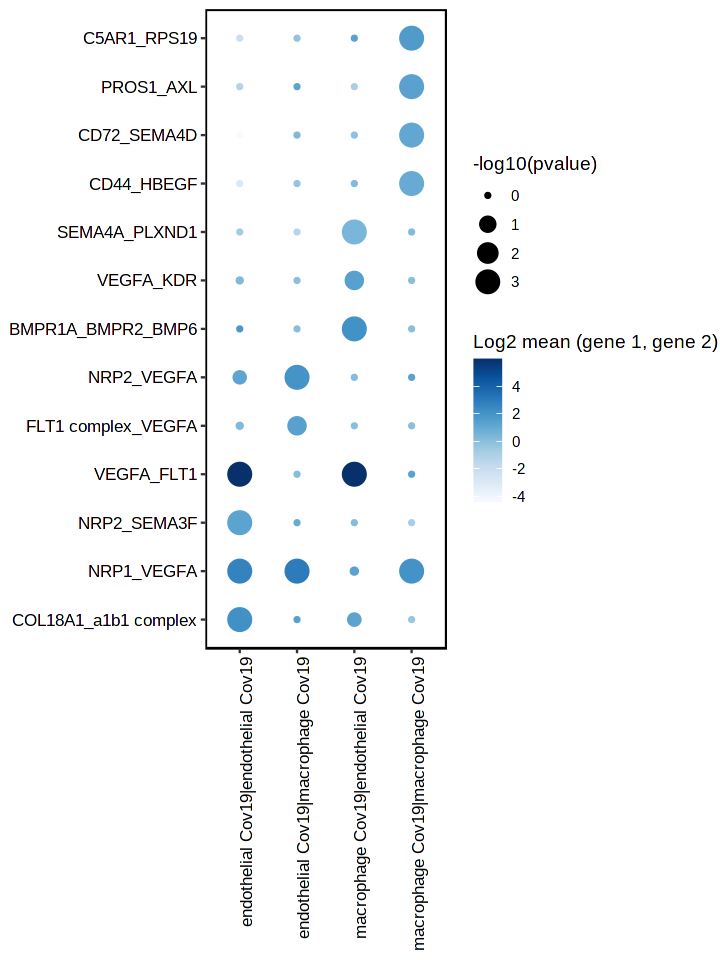

In [950]:
options(repr.plot.width=6, repr.plot.height=8)

this_sample = 'liver'
df_enriched <- compareConditions(this_sample = this_sample)
interactionDotPlot(df_enriched)

#ggsave(file =paste('/mnt/ibm_lg/covid_tissue_atlas/figures/figure5/Cellphone_',this_sample,'.pdf',sep=""), width = 6, height = 8)

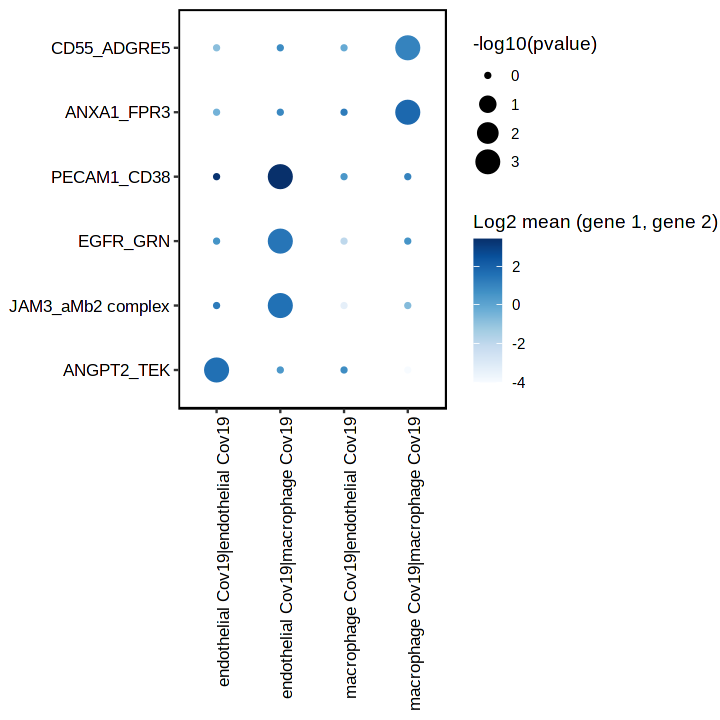

In [953]:
options(repr.plot.width=6, repr.plot.height=6)

this_sample ='lung'
df_enriched <- compareConditions(this_sample = this_sample)
interactionDotPlot(df_enriched)

#ggsave(file =paste('/mnt/ibm_lg/covid_tissue_atlas/figures/figure5/Cellphone_',this_sample,'.pdf',sep=""), width = 6, height = 6)